In [2]:
# !pip install pycocotools

%load_ext autoreload
%autoreload 
%matplotlib inline


from torchvision.datasets import CocoDetection
import torch.utils.data as data
import torch.utils.data as data
from PIL import Image
import os
import os.path
from albumentations import Resize, Compose

from retinanet.retinanet import RetinaNet

from torchvision import transforms
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
import json
import torch
import numpy as np 
from torchvision.transforms import ToTensor


import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn

device  = 'cuda' if torch.cuda.is_available() else 'cpu'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = 32

image_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])


class CocoDetection(data.Dataset):

    def __init__(self, root, annFile, transform=None, target_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.imw = 256
        self.imh = 256
        self.ids = list(self.coco.imgs.keys())
        self.aug = get_aug([Resize(256, 256)])
        self.encoder = DataEncoder()
#         self.encoder.anchor_areas =[8*8.,16*16.,32*32]


    def __getitem__(self, index):
  
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        
        annot = {'image': np.array(img), 
                 'bboxes': [b['bbox'] for b in target], 
                 'category_id':[b['category_id'] for b in target]}
    
        
        annot = self.aug(**annot)
        
        
        boxes = torch.Tensor(annot['bboxes'])
        labels = torch.Tensor(annot['category_id'])
        
        
        
        if boxes.shape[0] == 0:
            return self[index + 1]
            import pdb
            pdb.set_trace()
        if sum(labels>0) == 0:
            import pdb 
            pdb.set_trace()
            return self[index + 1]

        
        boxes = torch.cat([boxes[:, :2], boxes[:, :2] + boxes[:, 2:]], dim=1)
        encoded = self.encoder.encode(boxes, labels, torch.Tensor([256, 256]))
        
        how_many_encoded = (encoded[1]>0).sum()
        if  how_many_encoded <= 0:
            print(how_many_encoded)
            print("skipping")
            print(labels)
            return self[index + 1]
        
        return image_transform_train(annot['image']), encoded
    
    


    def __len__(self):
        return len(self.ids)
    
    
def get_aug(aug, min_area=0., min_visibility=0.):
        return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 
                                         'min_visibility': min_visibility, 
                                         'label_fields': ['category_id']})




    
ds = CocoDetection(root='/media/i008/ssd500/val2017',
                   annFile='/media/i008/ssd500/annotations/instances_val2017.json',
                   
                  )

dl = torch.utils.data.DataLoader(ds, batch_size=8)

def init_weights_retina(module, pi=0.01):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [3]:
# model= SimpleSSD(100)
model = RetinaNet(100)
model.freeze_bn()
for param in model.fpn.parameters():
    param.requires_grad = False

model = model.to(device)
criterion = FocalLoss(num_classes=100)

model = model.apply(init_weights_retina)
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)


In [9]:
collect = []

for epoch in range(50):
    for b in dl:
        optimizer.zero_grad()
        image, (bounding_boxes, labels) = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        collect.append(total_loss)



/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


cls loss 2016.5760498046875  loc loss 49.83682632446289
cls loss 2412.391845703125  loc loss 72.04943084716797
cls loss 2324.8935546875  loc loss 57.1633415222168
cls loss 2068.5458984375  loc loss 38.609886169433594
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 1984.1070556640625  loc loss 26.238601684570312
cls loss 2040.5955810546875  loc loss 63.22724533081055
cls loss 2308.67529296875  loc loss 66.28096008300781
cls loss 1941.0013427734375  loc loss 36.90963363647461
cls loss 2185.80517578125  loc loss 53.462684631347656
cls loss 3196.036376953125  loc loss 92.59921264648438
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.,  1.,  1.])
cls loss 1796.30224609375  loc loss 44.953792572021484
cls loss 1460.038818359375  loc loss 38.695281982421875
cls loss 1884.4219970703125  loc loss 54.11900329589844
cls loss 2156.44482421875  loc loss 86.153076171875
cls loss 1774.6898193359375  loc loss 42.878658294677734
cls loss 2036.60205078125  loc loss 73.9549789428711
cls loss 2207.2

tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 1266.58935546875  loc loss 42.9893684387207
cls loss 1488.732421875  loc loss 27.00591468811035
cls loss 1961.826171875  loc loss 47.76154708862305
cls loss 1954.0545654296875  loc loss 58.4026985168457
cls loss 1772.25048828125  loc loss 51.02895736694336
cls loss 1797.4892578125  loc loss 60.77574157714844
cls loss 1448.093017578125  loc loss 54.44807434082031
cls loss 1797.41015625  loc loss 60.801063537597656
cls loss 1796.172119140625  loc loss 50.35157775878906
cls loss 1671.287109375  loc loss 67.33851623535156
cls loss 1106.629150390625  loc loss 39.64860534667969
tensor(0)
skipping
tensor([85.])
cls loss 1946.774169921875  loc loss 60.51439666748047
cls loss 2144.438232421875  loc loss 71.40278625488281
cls loss 1912.0128173828125  loc loss 78.41940307617188
cls loss 1723.57470703125  loc loss 69.1744384765625
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  

cls loss 1407.4932861328125  loc loss 53.53163146972656
cls loss 1382.738037109375  loc loss 40.05186080932617
cls loss 1043.257080078125  loc loss 31.62001609802246
cls loss 1435.6650390625  loc loss 49.444000244140625
cls loss 1508.671630859375  loc loss 59.54993438720703
cls loss 1789.7010498046875  loc loss 44.24514389038086
cls loss 1927.220458984375  loc loss 69.84855651855469
cls loss 1864.212158203125  loc loss 77.26632690429688
cls loss 1657.11083984375  loc loss 51.460845947265625
cls loss 1456.199462890625  loc loss 76.40437316894531
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62.])
cls loss 1399.06005859375  loc loss 39.01949691772461
cls loss 1754.6949462890625  loc loss 52.20128631591797
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 1517.06396484375  loc loss 57.49260330200195
cls loss 1975.905029296875  loc loss 73.24713897705078
cls loss 1376.23193359375  loc loss 40.77899169921875


cls loss 1316.340576171875  loc loss 60.330753326416016
cls loss 1013.03662109375  loc loss 38.941280364990234
cls loss 1748.4423828125  loc loss 88.2361831665039
cls loss 2047.845947265625  loc loss 97.62325286865234
tensor(0)
skipping
tensor([15., 85.])
cls loss 1590.318115234375  loc loss 62.56393814086914
cls loss 1244.41064453125  loc loss 72.34661865234375
cls loss 1527.8463134765625  loc loss 64.49982452392578
cls loss 1537.64599609375  loc loss 58.330135345458984
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 940.6525268554688  loc loss 34.983123779296875
cls loss 1371.6998291015625  loc loss 40.843299865722656
cls loss 1301.48193359375  loc loss 46.771366119384766
cls loss 1161.16064453125  loc loss 37.59967041015625
cls loss 1191.1396484375  loc loss 46.682762145996094
cls loss 1561.240966796875  loc loss 53.496376037597656
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1., 35., 27., 27.,  1., 27.,  1.])
cls loss 2244.95654296875  loc loss 87.427490234375
cls loss 991.1

cls loss 1203.0703125  loc loss 63.486778259277344
cls loss 1522.6357421875  loc loss 47.43035125732422
cls loss 1784.868408203125  loc loss 69.01612854003906
cls loss 1178.3836669921875  loc loss 52.66206741333008
cls loss 1326.1259765625  loc loss 60.27587890625
cls loss 1667.921630859375  loc loss 84.78022766113281
cls loss 1082.208740234375  loc loss 57.73779296875
cls loss 1155.574462890625  loc loss 52.294986724853516
cls loss 1590.535400390625  loc loss 77.29119110107422
cls loss 1443.8153076171875  loc loss 75.73878479003906
cls loss 1737.5172119140625  loc loss 83.96986389160156
tensor(0)
skipping
tensor([5., 5.])
cls loss 884.2053833007812  loc loss 17.347482681274414
cls loss 863.1881103515625  loc loss 28.727426528930664
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 3., 6., 8., 8.])
cls loss 816.7869873046875  loc loss 23.12999153137207
cls loss 953.5985107421875  loc loss 32.58026885986328
cls loss 1470.03466796875  loc loss 77.9661636352539
cls 

cls loss 1229.748779296875  loc loss 50.250526428222656
cls loss 1140.12548828125  loc loss 60.58683395385742
cls loss 1009.051025390625  loc loss 56.29519271850586
cls loss 1172.84814453125  loc loss 55.17823028564453
cls loss 983.4962158203125  loc loss 49.89909362792969
cls loss 1394.4669189453125  loc loss 70.43942260742188
cls loss 1107.9560546875  loc loss 56.030433654785156
cls loss 1012.5638427734375  loc loss 35.64237594604492
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 976.39111328125  loc loss 24.649877548217773
cls loss 1017.5201416015625  loc loss 60.652984619140625
cls loss 1187.4365234375  loc loss 65.27082824707031
cls loss 835.0714111328125  loc loss 36.317806243896484
cls loss 1258.8006591796875  loc loss 52.784420013427734
cls loss 2005.73828125  loc loss 91.72499084472656
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.,  1.,  1.])
cls loss 1049.1273193359375  loc loss 42.820377349853516
cls loss 750.3115844726562  loc loss 35.13636016845703
cls loss 1025.

cls loss 1099.466796875  loc loss 47.173439025878906
cls loss 661.9341430664062  loc loss 24.82577133178711
cls loss 1085.3037109375  loc loss 53.52182388305664
cls loss 761.7889404296875  loc loss 31.127716064453125
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 721.440673828125  loc loss 42.32109832763672
cls loss 802.742431640625  loc loss 25.04288101196289
cls loss 1159.0638427734375  loc loss 46.213409423828125
cls loss 1153.068603515625  loc loss 54.768070220947266
cls loss 1170.19384765625  loc loss 48.75431442260742
cls loss 1057.2093505859375  loc loss 58.79637145996094
cls loss 901.9920654296875  loc loss 51.99557113647461
cls loss 1122.552734375  loc loss 58.03015899658203
cls loss 1088.831298828125  loc loss 49.133277893066406
cls loss 1096.0201416015625  loc loss 65.14909362792969
cls loss 654.0531005859375  loc loss 36.2346305847168
tensor(0)
skipping
tensor([85.])
cls loss 1

cls loss 1091.9786376953125  loc loss 64.98579406738281
tensor(0)
skipping
tensor([85., 85.])
cls loss 858.1666870117188  loc loss 45.49015808105469
cls loss 990.009033203125  loc loss 56.0897102355957
cls loss 903.8876953125  loc loss 35.52649688720703
cls loss 1040.734619140625  loc loss 56.05631637573242
cls loss 1003.3045043945312  loc loss 59.096378326416016
cls loss 929.0980224609375  loc loss 51.08946990966797
cls loss 972.9754638671875  loc loss 37.748130798339844
cls loss 674.34716796875  loc loss 30.226667404174805
cls loss 880.85986328125  loc loss 47.28546142578125
cls loss 986.8419189453125  loc loss 57.706790924072266
cls loss 1206.261962890625  loc loss 42.59917068481445
cls loss 1404.413330078125  loc loss 68.50941467285156
cls loss 1403.58935546875  loc loss 74.89811706542969
cls loss 1085.903564453125  loc loss 48.12944030761719
cls loss 1044.818359375  loc loss 74.16629028320312
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62

cls loss 1060.509033203125  loc loss 57.799415588378906
cls loss 941.62548828125  loc loss 52.874664306640625
cls loss 795.2351684570312  loc loss 22.79136085510254
cls loss 1162.7158203125  loc loss 61.920555114746094
cls loss 887.5679321289062  loc loss 58.03366470336914
cls loss 671.1451416015625  loc loss 37.392730712890625
cls loss 1259.2781982421875  loc loss 87.28884887695312
cls loss 1463.4010009765625  loc loss 94.12464141845703
tensor(0)
skipping
tensor([15., 85.])
cls loss 1149.093017578125  loc loss 60.423004150390625
cls loss 909.3734130859375  loc loss 69.93440246582031
cls loss 1175.955322265625  loc loss 62.84093475341797
cls loss 1073.357177734375  loc loss 57.158931732177734
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 638.3814697265625  loc loss 31.959074020385742
cls loss 951.3026123046875  loc loss 39.686767578125
cls loss 939.7115478515625  loc loss 44.99732971191406
cls loss 828.9278564453125  loc loss 36.45732498168945
cls loss 901.8833618164062  loc

cls loss 678.8379516601562  loc loss 22.017229080200195
cls loss 867.8887939453125  loc loss 51.3721809387207
cls loss 834.6557006835938  loc loss 32.22211456298828
cls loss 683.4349365234375  loc loss 34.91702651977539
cls loss 942.69384765625  loc loss 62.001319885253906
cls loss 1056.05908203125  loc loss 45.66594314575195
cls loss 1453.0263671875  loc loss 67.1636734008789
cls loss 848.272705078125  loc loss 50.483642578125
cls loss 960.548828125  loc loss 57.87587356567383
cls loss 1298.51953125  loc loss 82.71207427978516
cls loss 795.1876831054688  loc loss 55.76595687866211
cls loss 912.9970703125  loc loss 49.64521026611328
cls loss 1254.6973876953125  loc loss 74.12374114990234
cls loss 1113.7412109375  loc loss 73.51441192626953
cls loss 1385.079833984375  loc loss 80.42900085449219
tensor(0)
skipping
tensor([5., 5.])
cls loss 635.92236328125  loc loss 16.062917709350586
cls loss 599.5258178710938  loc loss 26.866722106933594
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
s

cls loss 760.8862915039062  loc loss 42.58271789550781
cls loss 837.462890625  loc loss 43.809844970703125
cls loss 743.4722900390625  loc loss 57.35616683959961
cls loss 1066.0963134765625  loc loss 49.023155212402344
cls loss 932.7998046875  loc loss 59.69430923461914
cls loss 779.1051025390625  loc loss 54.678810119628906
cls loss 888.8900146484375  loc loss 53.595481872558594
cls loss 792.7824096679688  loc loss 48.73936462402344
cls loss 1117.201416015625  loc loss 68.22228240966797
cls loss 842.9784545898438  loc loss 53.833648681640625
cls loss 772.7327880859375  loc loss 33.91044998168945
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 722.783203125  loc loss 23.51268768310547
cls loss 760.770751953125  loc loss 58.339111328125
cls loss 949.6943359375  loc loss 63.659812927246094
cls loss 609.3131103515625  loc loss 35.12607955932617
cls loss 952.8753662109375  loc loss 50.98606872558594
cls loss 1621.46630859375  loc loss 89.00625610351562
tensor(0)
skipping
tensor([ 1.,  

cls loss 725.80859375  loc loss 35.16393280029297
cls loss 778.94970703125  loc loss 47.25419616699219
tensor(0)
skipping
tensor([15.])
cls loss 891.8310546875  loc loss 45.961082458496094
cls loss 475.10528564453125  loc loss 23.52013397216797
cls loss 890.87158203125  loc loss 52.3006706237793
cls loss 597.1377563476562  loc loss 29.786895751953125
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 577.038818359375  loc loss 41.83327865600586
cls loss 616.1386108398438  loc loss 23.298667907714844
cls loss 952.6207275390625  loc loss 45.22518539428711
cls loss 918.2579345703125  loc loss 52.12345886230469
cls loss 962.3311767578125  loc loss 47.192771911621094
cls loss 893.3931884765625  loc loss 56.02123260498047
cls loss 736.77392578125  loc loss 49.94882583618164
cls loss 901.093017578125  loc loss 56.277381896972656
cls loss 884.099853515625  loc loss 47.65618133544922
cls loss 897.59008

cls loss 460.088623046875  loc loss 28.826169967651367
cls loss 1396.716796875  loc loss 92.29163360595703
cls loss 920.2939453125  loc loss 62.67556381225586
tensor(0)
skipping
tensor([85., 85.])
cls loss 737.5750122070312  loc loss 43.85192108154297
cls loss 829.133544921875  loc loss 54.24525451660156
cls loss 749.3388671875  loc loss 34.50169372558594
cls loss 863.6448364257812  loc loss 54.65543746948242
cls loss 868.4232177734375  loc loss 57.44148254394531
cls loss 805.3319091796875  loc loss 49.24049377441406
cls loss 783.7825317382812  loc loss 36.00572967529297
cls loss 576.4051513671875  loc loss 29.163652420043945
cls loss 725.1719970703125  loc loss 45.8696403503418
cls loss 817.4097290039062  loc loss 55.98063278198242
cls loss 975.1497192382812  loc loss 41.49675750732422
cls loss 1147.267333984375  loc loss 67.66680145263672
cls loss 1181.106201171875  loc loss 73.13595581054688
cls loss 916.401611328125  loc loss 46.28068161010742
cls loss 916.8937377929688  loc loss 7

cls loss 606.610107421875  loc loss 31.536006927490234
cls loss 702.0745849609375  loc loss 47.96617126464844
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 937.9324951171875  loc loss 55.58320999145508
cls loss 822.735107421875  loc loss 51.571659088134766
cls loss 640.3751220703125  loc loss 22.00880241394043
cls loss 1026.5491943359375  loc loss 60.57316970825195
cls loss 762.4977416992188  loc loss 56.02642822265625
cls loss 570.1954345703125  loc loss 36.15099334716797
cls loss 1136.798095703125  loc loss 85.40213775634766
cls loss 1293.409912109375  loc loss 91.40847778320312
tensor(0)
skipping
tensor([15., 85.])
cls loss 1010.5880737304688  loc loss 58.34590530395508
cls loss 815.8701782226562  loc loss 67.97864532470703
cls loss 1065.22216796875  loc loss 61.49565124511719
cls loss 900.0761108398438  loc loss 55.49082946777344
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 541.2095947265625  loc 

cls loss 885.8787231445312  loc loss 55.787391662597656
cls loss 985.6638793945312  loc loss 68.58963775634766
cls loss 800.8011474609375  loc loss 42.18102264404297
cls loss 1029.902099609375  loc loss 74.53230285644531
cls loss 555.9014282226562  loc loss 21.085121154785156
cls loss 754.0367431640625  loc loss 49.77759552001953
cls loss 718.2142333984375  loc loss 30.982404708862305
cls loss 612.0030517578125  loc loss 33.89726638793945
cls loss 843.2021484375  loc loss 60.3969612121582
cls loss 877.6090087890625  loc loss 44.40533447265625
cls loss 1259.905029296875  loc loss 65.9537582397461
cls loss 726.558349609375  loc loss 48.59241485595703
cls loss 823.500732421875  loc loss 56.13175964355469
cls loss 1178.495361328125  loc loss 80.95196533203125
cls loss 705.2840576171875  loc loss 54.56171798706055
cls loss 818.2264404296875  loc loss 47.75851821899414
cls loss 1139.7618408203125  loc loss 71.85681915283203
cls loss 1000.5286865234375  loc loss 71.49578094482422
cls loss 128

cls loss 777.36962890625  loc loss 35.07807922363281
cls loss 1247.52734375  loc loss 110.06932830810547
cls loss 774.3413696289062  loc loss 46.99276351928711
cls loss 955.9771728515625  loc loss 71.1491470336914
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 676.7438354492188  loc loss 40.454559326171875
cls loss 762.5366821289062  loc loss 42.72975158691406
cls loss 661.413818359375  loc loss 55.46731948852539
cls loss 923.758056640625  loc loss 48.16166687011719
cls loss 831.990478515625  loc loss 58.714263916015625
cls loss 706.8757934570312  loc loss 53.18603515625
cls loss 754.6320190429688  loc loss 52.20004653930664
cls loss 741.052001953125  loc loss 47.48213195800781
cls loss 996.3324584960938  loc loss 66.5657958984375
cls loss 774.463134765625  loc loss 51.96946716308594
cls loss 683.533203125  loc loss 32.27931213378906
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 598.7852783203125  loc loss 22.710926055908203
cls loss 668.8411865234375  loc loss 56.2781295776

cls loss 833.452392578125  loc loss 61.41560745239258
cls loss 619.462890625  loc loss 47.2347297668457
cls loss 875.5748291015625  loc loss 46.75438690185547
cls loss 789.2132568359375  loc loss 43.900115966796875
tensor(0)
skipping
tensor([44., 44.])
cls loss 656.2374877929688  loc loss 34.2348518371582
cls loss 718.6593017578125  loc loss 46.03764724731445
tensor(0)
skipping
tensor([15.])
cls loss 826.332763671875  loc loss 45.01247787475586
cls loss 408.90673828125  loc loss 22.48711395263672
cls loss 814.0497436523438  loc loss 51.308998107910156
cls loss 541.15283203125  loc loss 28.796762466430664
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 515.642333984375  loc loss 41.0608024597168
cls loss 522.6493530273438  loc loss 21.90782928466797
cls loss 872.0562744140625  loc loss 44.31081771850586
cls loss 838.51611328125  loc loss 50.09734344482422
cls loss 862.2991943359375  loc loss

cls loss 459.4467468261719  loc loss 29.215391159057617
cls loss 573.874755859375  loc loss 38.468833923339844
cls loss 756.2866821289062  loc loss 46.5713005065918
cls loss 664.7060546875  loc loss 43.053524017333984
cls loss 705.2789306640625  loc loss 44.042274475097656
cls loss 418.8412780761719  loc loss 27.771873474121094
cls loss 1270.079833984375  loc loss 89.3572006225586
cls loss 836.42919921875  loc loss 60.63380813598633
tensor(0)
skipping
tensor([85., 85.])
cls loss 699.2196655273438  loc loss 42.2982063293457
cls loss 746.917724609375  loc loss 52.855796813964844
cls loss 660.596923828125  loc loss 33.779998779296875
cls loss 796.57861328125  loc loss 53.44072341918945
cls loss 812.8916015625  loc loss 55.86902618408203
cls loss 749.0022583007812  loc loss 47.66718673706055
cls loss 690.8018798828125  loc loss 34.64338302612305
cls loss 524.2862548828125  loc loss 28.252639770507812
cls loss 660.0345458984375  loc loss 44.73781204223633
cls loss 735.4827880859375  loc los

cls loss 956.78857421875  loc loss 46.313720703125
tensor(0)
skipping
tensor([10.])
cls loss 518.7528686523438  loc loss 30.88434410095215
cls loss 698.1273803710938  loc loss 38.496315002441406
cls loss 832.0324096679688  loc loss 39.42436218261719
cls loss 533.7930908203125  loc loss 30.542238235473633
cls loss 633.9415893554688  loc loss 46.701419830322266
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 863.3258056640625  loc loss 53.57276916503906
cls loss 752.5081787109375  loc loss 50.47233581542969
cls loss 551.3125610351562  loc loss 21.293859481811523
cls loss 942.8944702148438  loc loss 59.36029052734375
cls loss 709.6151123046875  loc loss 54.286216735839844
cls loss 537.7083129882812  loc loss 35.108558654785156
cls loss 1072.150146484375  loc loss 83.20489501953125
cls loss 1220.5191650390625  loc loss 89.12471771240234
tensor(0)
skipping
tensor([15., 85.])
cls loss 910.06640625  loc loss 56.3481750488

cls loss 757.4122314453125  loc loss 42.099124908447266
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 489.78717041015625  loc loss 44.3372688293457
cls loss 769.3494873046875  loc loss 58.36556625366211
cls loss 529.999755859375  loc loss 34.38688659667969
cls loss 823.9339599609375  loc loss 54.19139099121094
cls loss 898.60498046875  loc loss 67.13141632080078
cls loss 743.959716796875  loc loss 40.9124641418457
cls loss 960.0059814453125  loc loss 73.00314331054688
cls loss 489.3408203125  loc loss 20.381229400634766
cls loss 698.9247436523438  loc loss 48.27677917480469
cls loss 648.411865234375  loc loss 30.035242080688477
cls loss 567.50634765625  loc loss 33.11202621459961
cls loss 782.5271606445312  loc loss 58.74909973144531
cls loss 774.0146484375  loc loss 43.42943572998047
cls loss 1115.122802734375  loc loss 64.91893768310547
cls loss 667.0838623046875  loc loss 47.0185432434082
cls loss 756.4606323242188  loc loss 54.71607971191406
cls loss 1108.884765625  loc loss 78.98

cls loss 568.664794921875  loc loss 41.74068069458008
tensor(0)
skipping
tensor([85.])
cls loss 1017.8305053710938  loc loss 71.39280700683594
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 674.3043212890625  loc loss 33.539310455322266
cls loss 1182.06591796875  loc loss 107.8525390625
cls loss 724.8986206054688  loc loss 45.85063552856445
cls loss 901.8193359375  loc loss 69.56111907958984
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 622.625244140625  loc loss 39.03832244873047
cls loss 704.1361083984375  loc loss 41.78300857543945
cls loss 612.394287109375  loc loss 53.25041198730469
cls loss 806.1875  loc loss 47.589805603027344
cls loss 765.236083984375  loc loss 57.64369583129883
cls loss 667.155029296875  loc loss 51.902000427246094
cls loss 687.06689453125  loc loss 50.890960693359375
cls loss 707.0474243164062  loc loss 46.032371520996094
cls loss 932.6812744140625  loc loss 65.0018539428711
cls lo

cls loss 720.5812377929688  loc loss 42.90199279785156
cls loss 916.0283813476562  loc loss 68.70826721191406
cls loss 1021.4345092773438  loc loss 61.95729064941406
cls loss 1809.92333984375  loc loss 127.0008544921875
cls loss 705.6519775390625  loc loss 37.21149826049805
cls loss 775.4681396484375  loc loss 59.374794006347656
cls loss 571.7000732421875  loc loss 45.44912338256836
cls loss 822.9866943359375  loc loss 45.48257064819336
cls loss 735.78564453125  loc loss 42.931121826171875
tensor(0)
skipping
tensor([44., 44.])
cls loss 602.7042236328125  loc loss 33.50471878051758
cls loss 670.1984252929688  loc loss 44.972740173339844
tensor(0)
skipping
tensor([15.])
cls loss 784.6889038085938  loc loss 44.29472351074219
cls loss 375.37640380859375  loc loss 21.732887268066406
cls loss 770.006591796875  loc loss 50.399620056152344
cls loss 502.30340576171875  loc loss 27.96206283569336
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tens

cls loss 700.3487548828125  loc loss 36.33540344238281
cls loss 725.519775390625  loc loss 41.38512420654297
cls loss 564.2737426757812  loc loss 27.340471267700195
cls loss 534.7313842773438  loc loss 31.12235450744629
cls loss 630.9041748046875  loc loss 40.28697967529297
cls loss 490.5780029296875  loc loss 34.19121551513672
cls loss 419.16986083984375  loc loss 28.141239166259766
cls loss 539.4006958007812  loc loss 37.21430969238281
cls loss 717.2938842773438  loc loss 45.28306579589844
cls loss 615.6405029296875  loc loss 42.2414665222168
cls loss 647.778564453125  loc loss 43.54230499267578
cls loss 390.28668212890625  loc loss 26.93706703186035
cls loss 1189.494384765625  loc loss 86.94596862792969
cls loss 790.9558715820312  loc loss 58.71862030029297
tensor(0)
skipping
tensor([85., 85.])
cls loss 673.3692016601562  loc loss 40.860626220703125
cls loss 701.925048828125  loc loss 51.59919357299805
cls loss 605.6319580078125  loc loss 33.135719299316406
cls loss 751.706604003906

cls loss 614.6672973632812  loc loss 31.22114372253418
cls loss 884.2939453125  loc loss 72.65419006347656
cls loss 1268.585205078125  loc loss 92.58256530761719
cls loss 1073.1162109375  loc loss 64.5833511352539
cls loss 639.8692626953125  loc loss 42.28854751586914
tensor(0)
skipping
tensor([85.])
cls loss 905.727294921875  loc loss 45.15772247314453
tensor(0)
skipping
tensor([10.])
cls loss 485.8885803222656  loc loss 29.794435501098633
cls loss 667.974853515625  loc loss 37.37114715576172
cls loss 760.5728149414062  loc loss 38.19378662109375
cls loss 494.09246826171875  loc loss 29.641223907470703
cls loss 598.2999267578125  loc loss 45.396820068359375
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 822.625  loc loss 51.638038635253906
cls loss 713.5955810546875  loc loss 49.373531341552734
cls loss 497.6285400390625  loc loss 20.629106521606445
cls loss 895.6930541992188  loc loss 58.14906311035156
cls loss 

cls loss 973.4139404296875  loc loss 86.92736053466797
cls loss 408.091064453125  loc loss 20.456256866455078
cls loss 451.48345947265625  loc loss 25.147634506225586
cls loss 625.0841064453125  loc loss 37.69622039794922
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 691.94140625  loc loss 41.45665740966797
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 459.27301025390625  loc loss 44.1224365234375
cls loss 735.2904052734375  loc loss 56.926979064941406
cls loss 502.4903259277344  loc loss 33.40621566772461
cls loss 781.1007080078125  loc loss 52.65339660644531
cls loss 836.818115234375  loc loss 65.67833709716797
cls loss 699.355224609375  loc loss 39.66740036010742
cls loss 900.009521484375  loc loss 71.52275085449219
cls loss 445.5755310058594  loc loss 19.7401065826416
cls loss 665.2874755859375  loc loss 46.879634857177734
cls loss 596.2965087890625  loc loss 29.218826293945312
cls loss 538.1968994140625  loc loss 32.5480842590332
cls loss 737.5176391601562  l

cls loss 717.0924682617188  loc loss 29.885019302368164
cls loss 528.0980224609375  loc loss 35.39482498168945
cls loss 1543.87158203125  loc loss 106.71778106689453
cls loss 674.44580078125  loc loss 48.85173034667969
cls loss 453.3152770996094  loc loss 40.90040588378906
cls loss 660.7364501953125  loc loss 36.87729263305664
cls loss 524.4893798828125  loc loss 40.66023254394531
tensor(0)
skipping
tensor([85.])
cls loss 955.5646362304688  loc loss 69.67403411865234
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 606.989501953125  loc loss 32.22077560424805
cls loss 1141.91064453125  loc loss 105.5927963256836
cls loss 693.6176147460938  loc loss 44.81496047973633
cls loss 866.31396484375  loc loss 67.97500610351562
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 584.1583251953125  loc loss 37.91666793823242
cls loss 675.216064453125  loc loss 40.893043518066406
cls loss 593.6051025390625  loc loss 50.94976425

tensor(0)
skipping
tensor([85.])
cls loss 902.3753662109375  loc loss 44.96723937988281
cls loss 773.4070434570312  loc loss 33.971473693847656
cls loss 568.0865478515625  loc loss 35.86750030517578
cls loss 515.756591796875  loc loss 23.531253814697266
cls loss 588.5774536132812  loc loss 35.8196907043457
cls loss 550.931396484375  loc loss 38.837276458740234
cls loss 680.6102905273438  loc loss 41.74052810668945
cls loss 857.326904296875  loc loss 67.47373962402344
cls loss 962.1458740234375  loc loss 60.755680084228516
cls loss 1747.57861328125  loc loss 124.6943130493164
cls loss 656.3585205078125  loc loss 36.207210540771484
cls loss 745.034423828125  loc loss 57.556556701660156
cls loss 540.570068359375  loc loss 43.64860916137695
cls loss 788.3294067382812  loc loss 44.3973503112793
cls loss 702.6177978515625  loc loss 42.050052642822266
tensor(0)
skipping
tensor([44., 44.])
cls loss 573.5277709960938  loc loss 32.779869079589844
cls loss 648.010009765625  loc loss 44.1315383911

cls loss 537.0904541015625  loc loss 41.136016845703125
cls loss 717.7703857421875  loc loss 45.01274108886719
cls loss 779.884765625  loc loss 57.91195297241211
cls loss 966.5878295898438  loc loss 86.68232727050781
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 671.1829833984375  loc loss 40.613433837890625
cls loss 688.56640625  loc loss 35.8499755859375
cls loss 704.3252563476562  loc loss 40.51171112060547
cls loss 534.8380126953125  loc loss 26.54974365234375
cls loss 511.9033203125  loc loss 30.375980377197266
cls loss 616.0961303710938  loc loss 39.504722595214844
cls loss 472.1402587890625  loc loss 32.69953918457031
cls loss 390.5634460449219  loc loss 27.088058471679688
cls loss 505.0332946777344  loc loss 35.9875373840332
cls loss 685.506103515625  loc loss 44.0037841796875
cls loss 571.2318115234375  loc loss 41.554161071777344
cls loss 605.0997924804688  loc loss 43.22465133666992
cls loss 365.7552795410156  loc loss 26.297815322875977
cls loss 1138.216796875  loc loss 84

cls loss 473.2985534667969  loc loss 21.21493911743164
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 955.748291015625  loc loss 58.17098617553711
cls loss 987.7687377929688  loc loss 83.3076171875
cls loss 661.542724609375  loc loss 55.82478713989258
cls loss 486.0109558105469  loc loss 36.5176887512207
tensor(0)
skipping
tensor([16.,  1.])
cls loss 568.24853515625  loc loss 30.67538070678711
cls loss 857.3563232421875  loc loss 70.85328674316406
cls loss 1223.54248046875  loc loss 90.21078491210938
cls loss 1041.7392578125  loc loss 62.629859924316406
cls loss 638.339111328125  loc loss 40.758602142333984
tensor(0)
skipping
tensor([85.])
cls loss 887.4532470703125  loc loss 44.32362747192383
tensor(0)
skipping
tensor([10.])
cls loss 483.90460205078125  loc loss 28.833141326904297
cls loss 659.3600463867188  loc loss 36.500064849853516
cls loss 720.564697265625  loc loss 37.189815521240234
cls loss 475.28521728515625  loc loss 28.888051986694336
cls loss 577.1387939453125  loc loss 44

cls loss 989.6505126953125  loc loss 76.7806167602539
cls loss 850.1920776367188  loc loss 47.852134704589844
cls loss 968.493896484375  loc loss 69.99951171875
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 621.3145141601562  loc loss 38.34792709350586
tensor(0)
skipping
tensor([13.])
cls loss 949.242431640625  loc loss 83.77495574951172
cls loss 384.3870849609375  loc loss 20.11937141418457
cls loss 426.8876953125  loc loss 24.515039443969727
cls loss 587.012451171875  loc loss 36.27705383300781
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 636.0732421875  loc loss 40.656612396240234
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 430.53485107421875  loc loss 43.32703399658203
cls loss 712.033935546875  loc loss 55.41184997558594
cls loss 484.4560852050781  loc loss 32.46731185913086
cls loss 750.90234375  loc loss 51.15383529663086
cls loss 801.7203369140625  loc loss 64.20068359375
cls loss 669.45947265625  loc loss 38.44415283203125
cls

cls loss 489.1407165527344  loc loss 18.07594108581543
cls loss 625.0986938476562  loc loss 45.939697265625
cls loss 503.16705322265625  loc loss 35.463661193847656
cls loss 859.689697265625  loc loss 67.76647186279297
cls loss 651.8021850585938  loc loss 29.217449188232422
cls loss 492.010498046875  loc loss 34.24498748779297
cls loss 1477.73486328125  loc loss 103.68883514404297
cls loss 629.5006103515625  loc loss 47.860862731933594
cls loss 431.61224365234375  loc loss 39.843875885009766
cls loss 610.542236328125  loc loss 36.38043212890625
cls loss 498.4713439941406  loc loss 39.68476104736328
tensor(0)
skipping
tensor([85.])
cls loss 915.46044921875  loc loss 68.03335571289062
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 563.8375244140625  loc loss 31.003576278686523
cls loss 1127.9044189453125  loc loss 103.44699096679688
cls loss 668.6837768554688  loc loss 43.91377258300781
cls loss 833.7696533203125  l

cls loss 832.2992553710938  loc loss 51.36707305908203
cls loss 799.4172973632812  loc loss 64.01864624023438
cls loss 1277.0169677734375  loc loss 87.08213806152344
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 878.1197509765625  loc loss 42.82765579223633
cls loss 738.6942749023438  loc loss 33.24102020263672
cls loss 547.1812744140625  loc loss 34.935970306396484
cls loss 482.7174072265625  loc loss 22.73768424987793
cls loss 550.6447143554688  loc loss 34.600860595703125
cls loss 533.512939453125  loc loss 38.08182144165039
cls loss 640.0659790039062  loc loss 40.57126998901367
cls loss 812.16650390625  loc loss 66.29235076904297
cls loss 909.2091064453125  loc loss 59.73716735839844
cls loss 1701.3289794921875  loc loss 122.41316986083984
cls loss 622.4405517578125  loc loss 35.35085678100586
cls loss 729.41650390625  loc loss 55.981658935546875
cls loss 519.94287109375  loc loss 41.93040466308594
cls loss 764.7050170898438  loc loss 43.44099044799805


cls loss 849.7779541015625  loc loss 67.44429779052734
cls loss 465.0279541015625  loc loss 29.996158599853516
cls loss 571.047607421875  loc loss 42.48106384277344
cls loss 663.502197265625  loc loss 50.18235397338867
cls loss 521.8737182617188  loc loss 40.686893463134766
cls loss 701.709228515625  loc loss 44.0440559387207
cls loss 769.725341796875  loc loss 56.7772216796875
cls loss 944.6934204101562  loc loss 85.4062728881836
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 656.7913818359375  loc loss 39.470794677734375
cls loss 671.7601318359375  loc loss 35.33836364746094
cls loss 681.771240234375  loc loss 39.653404235839844
cls loss 509.10614013671875  loc loss 25.828170776367188
cls loss 486.2821350097656  loc loss 29.652292251586914
cls loss 593.0194702148438  loc loss 38.84629440307617
cls loss 453.7874755859375  loc loss 31.44766616821289
cls loss 367.4892883300781  loc loss 26.054162979125977
cls loss 475.73785400390625  loc loss 34.75324249267578
cls loss 658.1587524414062

cls loss 560.003662109375  loc loss 31.77852439880371
cls loss 372.42864990234375  loc loss 19.188308715820312
cls loss 605.580810546875  loc loss 53.11094284057617
cls loss 668.6349487304688  loc loss 51.537906646728516
cls loss 513.885498046875  loc loss 33.35272979736328
cls loss 420.9036865234375  loc loss 20.649499893188477
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 911.3721923828125  loc loss 57.12836837768555
cls loss 955.6181030273438  loc loss 82.09391784667969
cls loss 637.186279296875  loc loss 54.503326416015625
cls loss 472.96771240234375  loc loss 35.58253479003906
tensor(0)
skipping
tensor([16.,  1.])
cls loss 548.7538452148438  loc loss 30.1700496673584
cls loss 841.92138671875  loc loss 69.28662872314453
cls loss 1211.0130615234375  loc loss 87.96055603027344
cls loss 1037.34765625  loc loss 60.785457611083984
cls loss 652.1590576171875  loc loss 39.15849685668945
tensor(0)
skipping
tensor([85.])
cls loss 881.432373046875  loc loss 43.711090087890625
tensor(0)
skip

cls loss 565.97998046875  loc loss 41.69053268432617
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 542.4107666015625  loc loss 31.040313720703125
cls loss 616.1471557617188  loc loss 40.987823486328125
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 968.2235107421875  loc loss 75.41486358642578
cls loss 818.7232666015625  loc loss 46.329429626464844
cls loss 926.5565185546875  loc loss 68.3851547241211
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 600.870849609375  loc loss 37.54734802246094
tensor(0)
skipping
tensor([13.])
cls loss 929.033935546875  loc loss 80.59056091308594
cls loss 361.13055419921875  loc loss 19.756107330322266
cls loss 407.40264892578125  loc loss 23.858362197875977
cls loss 565.2579345703125  loc loss 34.88823699951172
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 603.4588623046875  loc loss 39.74414825439453
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 4

cls loss 779.9404296875  loc loss 44.44498825073242
cls loss 924.3365478515625  loc loss 46.365699768066406
cls loss 822.94384765625  loc loss 42.33572769165039
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 649.123779296875  loc loss 39.75208282470703
cls loss 383.9210510253906  loc loss 31.16579818725586
tensor(0)
skipping
tensor([3.])
cls loss 425.67828369140625  loc loss 17.095745086669922
cls loss 589.4730224609375  loc loss 44.529476165771484
cls loss 476.6684875488281  loc loss 34.97876739501953
cls loss 827.115234375  loc loss 65.1827621459961
cls loss 608.7205810546875  loc loss 28.617202758789062
cls loss 470.70916748046875  loc loss 33.26290512084961
cls loss 1429.77294921875  loc loss 100.76632690429688
cls loss 602.534912109375  loc loss 46.902645111083984
cls loss 421.19140625  loc loss 38.732208251953125
cls loss 582.0323486328125  loc loss 35.87980270385742
cls loss 485.11419677734375  loc loss 38.793731689453125
tensor(0)
skipping
tensor([

cls loss 875.050048828125  loc loss 54.00775909423828
cls loss 839.2415771484375  loc loss 55.164329528808594
cls loss 766.3372192382812  loc loss 53.682884216308594
cls loss 821.158935546875  loc loss 59.663108825683594
cls loss 1113.49658203125  loc loss 82.32586669921875
cls loss 648.7701416015625  loc loss 43.26655197143555
cls loss 836.2500610351562  loc loss 50.564212799072266
cls loss 782.9515380859375  loc loss 62.64554214477539
cls loss 1246.0091552734375  loc loss 85.8818359375
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 843.735107421875  loc loss 40.74009323120117
cls loss 685.6455688476562  loc loss 32.52897644042969
cls loss 521.5711669921875  loc loss 34.126564025878906
cls loss 452.6127014160156  loc loss 21.95932960510254
cls loss 511.8424377441406  loc loss 33.51641845703125
cls loss 520.126220703125  loc loss 37.283443450927734
cls loss 607.9886474609375  loc loss 39.53101348876953
cls loss 786.094482421875  loc loss 65.12158966064453
cl

cls loss 746.558349609375  loc loss 52.426448822021484
cls loss 452.56158447265625  loc loss 21.176555633544922
cls loss 436.1955261230469  loc loss 28.041259765625
cls loss 832.7938232421875  loc loss 65.87873077392578
cls loss 457.7872619628906  loc loss 29.273164749145508
cls loss 550.5228271484375  loc loss 41.24955749511719
cls loss 651.5479736328125  loc loss 48.60801315307617
cls loss 505.83203125  loc loss 40.189430236816406
cls loss 684.1029052734375  loc loss 43.060848236083984
cls loss 749.67578125  loc loss 55.6444091796875
cls loss 924.9573364257812  loc loss 84.30873107910156
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 645.1165771484375  loc loss 38.45291519165039
cls loss 642.8092041015625  loc loss 34.84821701049805
cls loss 662.74755859375  loc loss 38.79233169555664
cls loss 489.6754150390625  loc loss 25.171958923339844
cls loss 470.7311706542969  loc loss 29.007089614868164
cls loss 575.6019897460938  loc loss 38.288536071777344
cls loss 441.2117919921875  loc lo

cls loss 333.3211669921875  loc loss 13.941156387329102
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 530.67236328125  loc loss 30.93758773803711
cls loss 354.1426696777344  loc loss 17.892148971557617
cls loss 588.153564453125  loc loss 51.63689041137695
cls loss 652.0426025390625  loc loss 50.396202087402344
cls loss 502.4249572753906  loc loss 32.87224578857422
cls loss 398.21893310546875  loc loss 20.105745315551758
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 892.7476806640625  loc loss 56.17221450805664
cls loss 929.6324462890625  loc loss 80.65908813476562
cls loss 623.933349609375  loc loss 53.04393768310547
cls loss 463.09527587890625  loc loss 34.76203918457031
tensor(0)
skipping
tensor([16.,  1.])
cls loss 540.6669921875  loc loss 29.621809005737305
cls loss 833.0487060546875  loc loss 67.87267303466797
cls loss 1208.722900390625  loc loss 85.84214782714844
cls loss 1034.734375  loc loss 59.00306701660156
cls loss 645.44140625  loc loss 37.564186096191406
tensor(0)
s

cls loss 632.44970703125  loc loss 44.55894088745117
cls loss 451.11224365234375  loc loss 39.65176773071289
cls loss 554.3677368164062  loc loss 41.17171096801758
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 531.847412109375  loc loss 30.270469665527344
cls loss 588.943603515625  loc loss 40.07575988769531
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 944.7485961914062  loc loss 74.05142974853516
cls loss 796.5199584960938  loc loss 44.84972381591797
cls loss 898.9166870117188  loc loss 66.80781555175781
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 586.687744140625  loc loss 36.87131118774414
tensor(0)
skipping
tensor([13.])
cls loss 917.6441650390625  loc loss 77.60832977294922
cls loss 345.23931884765625  loc loss 19.347463607788086
cls loss 396.27685546875  loc loss 23.21826934814453
cls loss 556.39208984375  loc loss 33.63541793823242
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])


cls loss 763.0775146484375  loc loss 43.1006965637207
cls loss 898.29443359375  loc loss 45.25556182861328
cls loss 793.394775390625  loc loss 41.322227478027344
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 629.524169921875  loc loss 38.907230377197266
cls loss 376.2421875  loc loss 30.678422927856445
tensor(0)
skipping
tensor([3.])
cls loss 391.195068359375  loc loss 16.311803817749023
cls loss 568.3163452148438  loc loss 43.241729736328125
cls loss 461.83984375  loc loss 34.47393798828125
cls loss 809.1926879882812  loc loss 62.60661315917969
cls loss 581.9937133789062  loc loss 28.08824348449707
cls loss 457.42462158203125  loc loss 32.41475296020508
cls loss 1392.6463623046875  loc loss 98.001220703125
cls loss 586.5941162109375  loc loss 45.88848114013672
cls loss 415.62591552734375  loc loss 37.607215881347656
cls loss 564.7020263671875  loc loss 35.380619049072266
cls loss 475.7292785644531  loc loss 37.966087341308594
tensor(0)
skipping
tensor([8

cls loss 786.692138671875  loc loss 52.39178466796875
tensor(0)
skipping
tensor([28.])
cls loss 877.7448120117188  loc loss 52.903480529785156
cls loss 827.6187744140625  loc loss 53.853111267089844
cls loss 766.9307861328125  loc loss 52.48020553588867
cls loss 816.5147094726562  loc loss 58.324256896972656
cls loss 1110.0556640625  loc loss 80.43927001953125
cls loss 633.1943359375  loc loss 42.685340881347656
cls loss 816.3118896484375  loc loss 49.82756805419922
cls loss 747.2589111328125  loc loss 61.280887603759766
cls loss 1175.167236328125  loc loss 84.78661346435547
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 794.7953491210938  loc loss 38.80443572998047
cls loss 633.0891723632812  loc loss 31.759950637817383
cls loss 501.5256042480469  loc loss 33.383209228515625
cls loss 433.1995849609375  loc loss 21.199642181396484
cls loss 490.2702941894531  loc loss 32.50911331176758
cls loss 510.86492919921875  loc loss 36.425228118896484
cls loss 588.9034

cls loss 405.0733642578125  loc loss 24.227487564086914
cls loss 541.5747680664062  loc loss 28.031551361083984
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 734.0552978515625  loc loss 51.174224853515625
cls loss 430.7681884765625  loc loss 20.762128829956055
cls loss 424.4071960449219  loc loss 27.666584014892578
cls loss 819.3341674804688  loc loss 64.324951171875
cls loss 448.29046630859375  loc loss 28.61817741394043
cls loss 521.3434448242188  loc loss 40.12018585205078
cls loss 628.773193359375  loc loss 47.12144088745117
cls loss 487.2914123535156  loc loss 39.650718688964844
cls loss 665.9669189453125  loc loss 42.142005920410156
cls loss 729.686279296875  loc loss 54.59566879272461
cls loss 910.097900390625  loc loss 83.20352172851562
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 636.66748046875  loc loss 37.56604766845703
cls loss 626.5804443359375  loc loss 34.30

cls loss 1032.8638916015625  loc loss 76.04893493652344
cls loss 604.858642578125  loc loss 46.93589782714844
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 544.1828002929688  loc loss 35.407615661621094
cls loss 320.34442138671875  loc loss 13.551525115966797
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 513.0613403320312  loc loss 30.142427444458008
cls loss 339.16827392578125  loc loss 16.62060546875
cls loss 575.5908813476562  loc loss 50.16143035888672
cls loss 639.1926879882812  loc loss 49.27257537841797
cls loss 495.71087646484375  loc loss 32.38127517700195
cls loss 386.2012023925781  loc loss 19.595722198486328
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 885.2136840820312  loc loss 55.296600341796875
cls loss 911.0855102539062  loc loss 79.19523620605469
cls loss 614.3914794921875  loc loss 51.63203048706055
cls loss 456.0693359375  loc loss 34.016319274902344
tensor(0)
skipping
tensor([16.,  1.])
cls loss 530.36

cls loss 600.7584838867188  loc loss 32.444183349609375
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 587.0281372070312  loc loss 45.49646759033203
cls loss 500.65863037109375  loc loss 30.508460998535156
cls loss 625.83740234375  loc loss 48.22814178466797
cls loss 1034.3399658203125  loc loss 62.91132354736328
cls loss 625.0390014648438  loc loss 43.48942184448242
cls loss 445.3896484375  loc loss 39.0899772644043
cls loss 545.8311767578125  loc loss 40.65979766845703
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 520.9739990234375  loc loss 29.530757904052734
cls loss 569.4458618164062  loc loss 39.25233840942383
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 925.8125  loc loss 72.62488555908203
cls loss 779.6907958984375  loc loss 43.472320556640625
cls loss 881.6466064453125  loc loss 65.31786346435547
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 575.6719970703125  loc 

cls loss 1152.1883544921875  loc loss 69.79389953613281
cls loss 1433.3873291015625  loc loss 98.3916244506836
cls loss 603.85693359375  loc loss 40.26169967651367
cls loss 843.3402709960938  loc loss 61.105613708496094
cls loss 893.25390625  loc loss 67.38099670410156
cls loss 673.190673828125  loc loss 40.4622802734375
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 757.5385131835938  loc loss 41.73222732543945
cls loss 890.5908203125  loc loss 44.223045349121094
cls loss 779.240234375  loc loss 40.40099334716797
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 616.8056640625  loc loss 38.07789611816406
cls loss 370.754638671875  loc loss 30.16457176208496
tensor(0)
skipping
tensor([3.])
cls loss 366.55865478515625  loc loss 15.664789199829102
cls loss 553.7830810546875  loc loss 42.00947570800781
cls loss 449.2890319824219  loc loss 34.005279541015625
cls loss 793.0466308593

cls loss 342.2112731933594  loc loss 21.996715545654297
cls loss 633.5050048828125  loc loss 49.54424285888672
cls loss 636.486083984375  loc loss 44.1113166809082
cls loss 478.5221862792969  loc loss 21.358325958251953
cls loss 813.7918701171875  loc loss 61.875328063964844
cls loss 784.6263427734375  loc loss 51.153724670410156
tensor(0)
skipping
tensor([28.])
cls loss 878.999267578125  loc loss 51.83345031738281
cls loss 818.0579833984375  loc loss 52.661170959472656
cls loss 765.5537719726562  loc loss 51.38764190673828
cls loss 805.6444702148438  loc loss 57.082096099853516
cls loss 1093.34375  loc loss 78.59004974365234
cls loss 616.3531494140625  loc loss 41.98368453979492
cls loss 784.7783203125  loc loss 49.123531341552734
cls loss 712.421142578125  loc loss 59.95270538330078
cls loss 1121.857421875  loc loss 83.73421478271484
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 762.75390625  loc loss 37.05265808105469
cls loss 603.9695434570312  loc loss

cls loss 545.9688720703125  loc loss 41.16050720214844
tensor(0)
skipping
tensor([85.])
cls loss 661.4127197265625  loc loss 32.04121780395508
tensor(0)
skipping
tensor([81.])
cls loss 788.8701171875  loc loss 52.6708984375
cls loss 490.815673828125  loc loss 33.80674362182617
cls loss 381.9219970703125  loc loss 23.5492000579834
cls loss 523.0396728515625  loc loss 27.57817268371582
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 710.5428466796875  loc loss 50.08778381347656
cls loss 407.25360107421875  loc loss 20.404197692871094
cls loss 410.0685729980469  loc loss 27.259225845336914
cls loss 808.038818359375  loc loss 62.8056755065918
cls loss 440.48486328125  loc loss 28.019678115844727
cls loss 500.5484619140625  loc loss 39.12640380859375
cls loss 614.579345703125  loc loss 45.75946807861328
cls loss 476.6623229980469  loc loss 39.03630447387695
cls loss 654.669982910156

cls loss 475.5218811035156  loc loss 32.4981689453125
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 616.9298095703125  loc loss 43.704593658447266
cls loss 577.8764038085938  loc loss 28.708221435546875
tensor(0)
skipping
tensor([85.])
cls loss 453.89385986328125  loc loss 32.6292724609375
cls loss 1008.7332763671875  loc loss 74.58843994140625
cls loss 593.9496459960938  loc loss 45.88916778564453
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 530.6456298828125  loc loss 34.0695686340332
cls loss 311.1265869140625  loc loss 13.222827911376953
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 500.58575439453125  loc loss 29.44028091430664
cls loss 326.3324890136719  loc loss 15.61690902709961
cls loss 564.3558349609375  loc loss 48.84327697753906
cls loss 628.77587890625  loc loss 48.170654296875
cls loss 491.1206970214844  loc loss 31.864919662475586
cls loss 378.4615783691406  loc loss 19.112337112426758
tensor(

cls loss 709.3570556640625  loc loss 47.63737487792969
cls loss 495.0438232421875  loc loss 33.364288330078125
tensor(0)
skipping
tensor([ 3.,  3.,  3.,  3., 11.,  3., 10., 10.,  3.,  3., 10.])
cls loss 586.5701904296875  loc loss 31.38848876953125
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 579.46435546875  loc loss 44.06204605102539
cls loss 494.25018310546875  loc loss 29.586448669433594
cls loss 623.154296875  loc loss 47.11064147949219
cls loss 1025.393798828125  loc loss 61.33970642089844
cls loss 618.7554931640625  loc loss 42.4193229675293
cls loss 440.4377746582031  loc loss 38.59778594970703
cls loss 540.580322265625  loc loss 40.11988067626953
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 510.2162170410156  loc loss 28.796939849853516
cls loss 554.5319213867188  loc loss 38.552730560302734
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 909.2077026367188  loc loss 71.11550903320312
cls lo

cls loss 329.53814697265625  loc loss 14.865055084228516
cls loss 418.5834045410156  loc loss 26.980693817138672
cls loss 759.29443359375  loc loss 47.63105010986328
cls loss 843.7508544921875  loc loss 65.43689727783203
cls loss 1128.8450927734375  loc loss 67.45406341552734
cls loss 1412.71923828125  loc loss 95.96427917480469
cls loss 590.8505859375  loc loss 39.02703094482422
cls loss 835.8104248046875  loc loss 60.025779724121094
cls loss 881.8477783203125  loc loss 65.94966125488281
cls loss 675.5814208984375  loc loss 39.90039825439453
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 751.3172607421875  loc loss 40.32342529296875
cls loss 876.778564453125  loc loss 43.257606506347656
cls loss 763.6328125  loc loss 39.6535530090332
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 605.1957397460938  loc loss 37.26613235473633
cls loss 365.14501953125  loc loss 29.66781616210

cls loss 672.158935546875  loc loss 48.984249114990234
cls loss 580.6953125  loc loss 44.64933776855469
cls loss 798.3511352539062  loc loss 68.5051040649414
cls loss 681.7259521484375  loc loss 46.1366081237793
cls loss 516.736328125  loc loss 32.6489143371582
cls loss 786.752685546875  loc loss 64.05024719238281
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 343.5812072753906  loc loss 21.546161651611328
cls loss 630.1822509765625  loc loss 48.56460952758789
cls loss 629.6387939453125  loc loss 43.384796142578125
cls loss 470.6331481933594  loc loss 20.684520721435547
cls loss 808.6769409179688  loc loss 60.14234924316406
cls loss 779.3936767578125  loc loss 50.00545120239258
tensor(0)
skipping
tensor([28.])
cls loss 871.3472290039062  loc loss 50.833675384521484
cls loss 804.865966796875  loc loss 51.50992965698242
cls loss 756.356689453125  loc loss 50.376949310302734
cls loss 790.1748046875  loc loss 55.877891540527344
cls loss 1071.189697265625  loc lo

cls loss 471.12786865234375  loc loss 36.075584411621094
cls loss 564.4637451171875  loc loss 37.29179000854492
cls loss 604.9865112304688  loc loss 46.97943115234375
cls loss 863.9674682617188  loc loss 52.19694137573242
cls loss 774.2874755859375  loc loss 58.53094482421875
cls loss 714.3344116210938  loc loss 42.05187225341797
tensor(0)
skipping
tensor([85.])
cls loss 538.4573974609375  loc loss 40.02345275878906
tensor(0)
skipping
tensor([85.])
cls loss 643.6182250976562  loc loss 31.63023567199707
tensor(0)
skipping
tensor([81.])
cls loss 768.6248779296875  loc loss 51.297611236572266
cls loss 476.8236389160156  loc loss 33.008689880371094
cls loss 356.833984375  loc loss 22.951871871948242
cls loss 508.7041931152344  loc loss 27.228435516357422
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 692.2660522460938  loc loss 49.079376220703125
cls loss 391.874755859375  loc los

cls loss 621.6250610351562  loc loss 38.21660232543945
cls loss 604.0634155273438  loc loss 46.94332504272461
cls loss 878.0769653320312  loc loss 51.33824920654297
cls loss 492.54241943359375  loc loss 30.823657989501953
cls loss 881.49072265625  loc loss 69.16231536865234
cls loss 529.5006103515625  loc loss 28.900432586669922
tensor(0)
skipping
tensor([85., 85.])
cls loss 463.0250244140625  loc loss 31.883167266845703
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 595.06982421875  loc loss 42.620933532714844
cls loss 548.4613037109375  loc loss 28.259918212890625
tensor(0)
skipping
tensor([85.])
cls loss 442.00146484375  loc loss 32.014835357666016
cls loss 988.0187377929688  loc loss 73.13658905029297
cls loss 585.184814453125  loc loss 44.83309555053711
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 519.4150390625  loc loss 32.792110443115234
cls loss 303.76226806640625  loc loss 12.891505241394043
tensor(0)
ski

cls loss 959.3170776367188  loc loss 73.77088928222656
cls loss 478.2935791015625  loc loss 38.409645080566406
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 647.8178100585938  loc loss 47.99192428588867
cls loss 569.571533203125  loc loss 40.808631896972656
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 697.3768310546875  loc loss 46.55353927612305
cls loss 489.3382873535156  loc loss 32.705230712890625
tensor(0)
skipping
tensor([ 3.,  3.,  3.,  3., 11.,  3., 10., 10.,  3.,  3., 10.])
cls loss 576.4535522460938  loc loss 30.45328140258789
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 575.0472412109375  loc loss 42.69470977783203
cls loss 491.19635009765625  loc loss 28.772157669067383
cls loss 619.9503173828125  loc loss 45.86595153808594
cls loss 1013.3613891601562  loc loss 59.801658630371094
cls loss 611.8644409179688  loc loss 41.406455993652344
cls loss 433.7282714843

cls loss 1035.480224609375  loc loss 73.92540740966797
cls loss 419.14678955078125  loc loss 25.39957046508789
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 590.8120727539062  loc loss 43.1456184387207
cls loss 700.3882446289062  loc loss 45.324275970458984
cls loss 329.88031005859375  loc loss 15.729034423828125
cls loss 443.6650695800781  loc loss 27.41348648071289
tensor(0)
skipping
tensor([51.,  1.])
cls loss 321.88360595703125  loc loss 14.437220573425293
cls loss 411.67913818359375  loc loss 26.235570907592773
cls loss 746.8118896484375  loc loss 46.3670768737793
cls loss 828.8270263671875  loc loss 63.84719467163086
cls loss 1107.8734130859375  loc loss 65.28258514404297
cls loss 1394.4259033203125  loc loss 93.62648010253906
cls loss 581.954833984375  loc loss 37.88750076293945
cls loss 828.724853515625  loc loss 59.098392486572266
cls loss 871.244873046875  loc loss 64.56258392333984
cls loss 673.653076171875  loc loss 39.35662078857422
tensor(0)
skipping
tensor([85., 8

cls loss 687.982421875  loc loss 51.75429153442383
cls loss 700.9127197265625  loc loss 42.70671844482422
cls loss 641.982666015625  loc loss 48.63481140136719
cls loss 942.2645263671875  loc loss 70.40293884277344
cls loss 685.3089599609375  loc loss 43.19973373413086
cls loss 875.1149291992188  loc loss 57.824947357177734
cls loss 1036.55078125  loc loss 66.91156005859375
cls loss 648.169189453125  loc loss 45.208412170410156
cls loss 664.2000732421875  loc loss 47.8427848815918
cls loss 571.9134521484375  loc loss 43.887237548828125
cls loss 789.221435546875  loc loss 67.34197998046875
cls loss 669.07666015625  loc loss 45.04665756225586
cls loss 514.2064208984375  loc loss 32.0523567199707
cls loss 779.664794921875  loc loss 62.746177673339844
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 344.3439636230469  loc loss 21.06903839111328
cls loss 626.7291259765625  loc loss 47.593746185302734
cls loss 620.8826904296875  loc loss 42.67303466796875
cls loss 4

cls loss 509.2933349609375  loc loss 41.520896911621094
cls loss 442.9810485839844  loc loss 35.53422546386719
cls loss 298.2632751464844  loc loss 15.017578125
cls loss 529.5003662109375  loc loss 32.33024978637695
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 492.561767578125  loc loss 28.96446990966797
cls loss 542.8565673828125  loc loss 42.207733154296875
cls loss 554.4168090820312  loc loss 37.78196716308594
cls loss 467.83856201171875  loc loss 35.45216369628906
cls loss 560.3192138671875  loc loss 36.19723892211914
cls loss 602.64306640625  loc loss 46.07427978515625
cls loss 853.3885498046875  loc loss 51.20320129394531
cls loss 756.1397705078125  loc loss 57.34709548950195
cls loss 699.6118774414062  loc loss 41.324928283691406
tensor(0)
skipping
tensor([85.])
cls loss 526.2310791015625  loc loss 38.984596252441406
tensor(0)
skipping
tensor([85.])
cls loss 622.0311279296875  loc loss 31.233827590942383
tensor(0)
skipping
tensor([81.])
cls loss 750.1958618164062  loc loss 5

cls loss 325.3808288574219  loc loss 22.07278823852539
cls loss 672.0921630859375  loc loss 49.409297943115234
cls loss 541.9328002929688  loc loss 41.385719299316406
tensor(0)
skipping
tensor([11.])
cls loss 335.0454406738281  loc loss 19.736371994018555
cls loss 435.47821044921875  loc loss 21.206565856933594
cls loss 447.4398498535156  loc loss 22.892486572265625
cls loss 634.7562866210938  loc loss 45.67319107055664
cls loss 621.634033203125  loc loss 37.202919006347656
cls loss 602.4203491210938  loc loss 45.63249969482422
cls loss 883.7296752929688  loc loss 50.09518814086914
cls loss 492.4268798828125  loc loss 30.052845001220703
cls loss 873.7838134765625  loc loss 67.52657318115234
cls loss 516.4833984375  loc loss 28.62630844116211
tensor(0)
skipping
tensor([85., 85.])
cls loss 446.7392272949219  loc loss 31.22901725769043
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 569.6402587890625  loc loss 41.60807418823242
cls loss 520.125  loc loss 27.838788986206055
t

cls loss 743.591796875  loc loss 37.709373474121094
cls loss 1004.9275512695312  loc loss 69.35289764404297
cls loss 630.1486206054688  loc loss 43.847801208496094
cls loss 851.30126953125  loc loss 52.217750549316406
cls loss 585.7340087890625  loc loss 41.438262939453125
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 774.58203125  loc loss 52.714412689208984
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38.,  1.])
cls loss 739.063232421875  loc loss 43.99723815917969
cls loss 946.6793212890625  loc loss 71.8353042602539
cls loss 473.79400634765625  loc loss 37.463706970214844
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 643.040283203125  loc loss 47.00025939941406
cls loss 563.2984619140625  loc loss 39.641998291015625
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 688.6123046875  loc loss 45.384010314941406
cls loss 485.81585693359375  loc loss 32.04581069946289
tensor(0)
skippi

cls loss 733.8056030273438  loc loss 53.931968688964844
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
         1.])
cls loss 465.3576965332031  loc loss 31.956951141357422
tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 1007.9002685546875  loc loss 70.01248931884766
cls loss 1023.625  loc loss 73.19217681884766
cls loss 412.18902587890625  loc loss 24.82838249206543
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 583.280517578125  loc loss 42.18279266357422
cls loss 690.8582763671875  loc loss 44.540252685546875
cls loss 324.44244384765625  loc loss 15.36141300201416
cls loss 435.2784729003906  loc loss 27.042177200317383
tensor(0)
skipping
tensor([51.,  1.])
cls loss 315.8952941894531  loc loss 14.044846534729004
cls loss 405.65716552734375  loc loss 25.516550064086914
cls loss 735.19677734375  loc loss 45.13756

cls loss 422.1832275390625  loc loss 30.05801010131836
cls loss 935.8029174804688  loc loss 68.18189239501953
cls loss 1108.92919921875  loc loss 73.64320373535156
cls loss 771.6309814453125  loc loss 54.94428253173828
tensor(0)
skipping
tensor([10., 10., 10., 10.,  3.,  3., 10.])
cls loss 505.03533935546875  loc loss 31.51055145263672
tensor(0)
skipping
tensor([7.])
cls loss 673.6007690429688  loc loss 50.118316650390625
cls loss 681.7457275390625  loc loss 41.88959503173828
cls loss 624.118408203125  loc loss 47.984588623046875
cls loss 906.371337890625  loc loss 69.33897399902344
cls loss 660.6089477539062  loc loss 42.55105209350586
cls loss 853.72607421875  loc loss 56.69157409667969
cls loss 1024.56884765625  loc loss 65.37315368652344
cls loss 633.067138671875  loc loss 44.367637634277344
cls loss 657.56298828125  loc loss 46.861141204833984
cls loss 563.7349853515625  loc loss 43.12908935546875
cls loss 780.0758056640625  loc loss 66.19468688964844
cls loss 657.055908203125  lo

cls loss 502.7911071777344  loc loss 31.555419921875
tensor(0)
skipping
tensor([42.,  1.])
cls loss 652.040771484375  loc loss 48.58375930786133
cls loss 583.93115234375  loc loss 35.072120666503906
cls loss 731.6659545898438  loc loss 40.58251953125
cls loss 833.2299194335938  loc loss 57.58738708496094
cls loss 742.687744140625  loc loss 50.150787353515625
cls loss 503.7660217285156  loc loss 40.951995849609375
cls loss 436.2226867675781  loc loss 35.11384201049805
cls loss 292.8684997558594  loc loss 14.670296669006348
cls loss 523.7298583984375  loc loss 31.60834503173828
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 492.3937072753906  loc loss 28.2724552154541
cls loss 540.8326416015625  loc loss 41.00636291503906
cls loss 554.0744018554688  loc loss 37.05699157714844
cls loss 466.00311279296875  loc loss 34.83074188232422
cls loss 556.1630859375  loc loss 35.19497299194336
cls loss 597.79541015625  loc loss 45.24200439453125
cls loss 838.7037353515625  loc loss 50.283649444580

cls loss 483.1876525878906  loc loss 33.76573944091797
cls loss 698.9151000976562  loc loss 45.606544494628906
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.])
cls loss 316.3953857421875  loc loss 21.34255027770996
cls loss 663.1668701171875  loc loss 48.36208724975586
cls loss 537.03515625  loc loss 40.5629768371582
tensor(0)
skipping
tensor([11.])
cls loss 332.322998046875  loc loss 19.512466430664062
cls loss 433.9593200683594  loc loss 20.743980407714844
cls loss 445.77490234375  loc loss 22.1444091796875
cls loss 633.7825927734375  loc loss 44.89560317993164
cls loss 622.8436889648438  loc loss 36.16576385498047
cls loss 601.479248046875  loc loss 44.422828674316406
cls loss 884.7388916015625  loc loss 48.93581008911133
cls loss 485.5057373046875  loc loss 29.31945037841797
cls loss 856.91748046875  loc loss 66.05809020996094
cls loss 497.36199951171875  loc loss 28.407119750976562
tensor(0)
skipping
tensor([85., 85.])


cls loss 361.52728271484375  loc loss 25.426259994506836
cls loss 411.6664123535156  loc loss 18.1921443939209
cls loss 716.7642822265625  loc loss 37.03313446044922
cls loss 989.0999755859375  loc loss 67.49162292480469
cls loss 609.60888671875  loc loss 43.14213943481445
cls loss 836.2930297851562  loc loss 50.748355865478516
cls loss 577.57421875  loc loss 40.72435760498047
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 759.7981567382812  loc loss 51.579498291015625
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38.,  1.])
cls loss 731.533203125  loc loss 42.97243118286133
cls loss 936.3082275390625  loc loss 70.0997085571289
cls loss 471.75665283203125  loc loss 36.62785720825195
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 640.1536254882812  loc loss 46.0654296875
cls loss 561.6800537109375  loc loss 38.52964782714844
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 682.229125976

cls loss 398.3728332519531  loc loss 27.577211380004883
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.])
cls loss 675.4959716796875  loc loss 51.26012420654297
cls loss 723.9866333007812  loc loss 53.116947174072266
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
         1.])
cls loss 452.47955322265625  loc loss 31.5880069732666
tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 998.000732421875  loc loss 68.90403747558594
cls loss 1015.3815307617188  loc loss 72.50613403320312
cls loss 407.0811767578125  loc loss 24.24339485168457
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 577.2096557617188  loc loss 41.2628173828125
cls loss 682.927978515625  loc loss 43.79182815551758
cls loss 319.2348937988281  loc loss 15.042093276977539
cls loss 428.301025390625  loc loss 26.66366195678711
tensor(0)
skipping
tensor([5

cls loss 887.8311767578125  loc loss 61.59115219116211
cls loss 567.7069702148438  loc loss 43.40299987792969
tensor(0)
skipping
tensor([ 3.,  3.,  9.,  9.,  9.,  6.,  6., 85., 85.,  8.,  1.,  1.,  1.,  1.,
         6.,  6.])
cls loss 416.1230773925781  loc loss 29.681907653808594
cls loss 924.5293579101562  loc loss 67.10067749023438
cls loss 1096.285888671875  loc loss 72.38594818115234
cls loss 762.5507202148438  loc loss 53.752532958984375
tensor(0)
skipping
tensor([10., 10., 10., 10.,  3.,  3., 10.])
cls loss 501.18890380859375  loc loss 30.757160186767578
tensor(0)
skipping
tensor([7.])
cls loss 656.601318359375  loc loss 48.521202087402344
cls loss 664.6158447265625  loc loss 41.08677673339844
cls loss 605.7702026367188  loc loss 47.35132598876953
cls loss 870.827880859375  loc loss 68.26321411132812
cls loss 639.462158203125  loc loss 41.89292907714844
cls loss 835.454345703125  loc loss 55.6031608581543
cls loss 1012.7852172851562  loc loss 64.00337219238281
cls loss 617.91400

cls loss 661.4500732421875  loc loss 39.75768280029297
cls loss 378.4773254394531  loc loss 22.623016357421875
tensor(0)
skipping
tensor([ 1., 35., 27.])
cls loss 630.199951171875  loc loss 41.42292022705078
cls loss 627.8340454101562  loc loss 52.3458137512207
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 492.30908203125  loc loss 30.64624786376953
tensor(0)
skipping
tensor([42.,  1.])
cls loss 639.7962646484375  loc loss 47.10887908935547
cls loss 569.2356567382812  loc loss 34.39510726928711
cls loss 713.33203125  loc loss 40.11072540283203
cls loss 815.90625  loc loss 56.654178619384766
cls loss 733.430908203125  loc loss 48.90179443359375
cls loss 497.5050964355469  loc loss 40.344703674316406
cls loss 430.0875244140625  loc loss 34.67966842651367
cls loss 289.031005859375  loc loss 14.340569496154785
cls loss 518.2659301757812  loc loss 30.94982147216797
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 492.3515319824219  loc loss 27.655364990234375
cls loss 540.2811279296875  lo

cls loss 728.107666015625  loc loss 39.4398078918457
cls loss 624.021484375  loc loss 43.89773941040039
cls loss 470.5254211425781  loc loss 24.309829711914062
cls loss 534.6084594726562  loc loss 27.446027755737305
cls loss 981.0146484375  loc loss 61.127967834472656
cls loss 814.4549560546875  loc loss 53.54254913330078
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42., 42., 42., 42., 42.,  1.,
         1.,  1.,  1., 42.,  1.,  1., 42.,  1.])
cls loss 472.20904541015625  loc loss 32.846397399902344
cls loss 690.3411865234375  loc loss 44.75335693359375
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.])
cls loss 308.6728515625  loc loss 20.679096221923828
cls loss 655.8043212890625  loc loss 47.26951599121094
cls loss 533.2257690429688  loc loss 39.74672317504883
tensor(0)
skipping
tensor([11.])
cls loss 330.1299743652344  loc loss 19.30104637145996
cls loss 433.92724609375  loc loss 20.310855865478516
cl

cls loss 430.6486511230469  loc loss 33.59585952758789
cls loss 774.17333984375  loc loss 53.597694396972656
cls loss 637.8825073242188  loc loss 44.38376998901367
cls loss 593.7487182617188  loc loss 40.81637954711914
cls loss 608.986572265625  loc loss 45.80073928833008
cls loss 834.9251098632812  loc loss 56.2275505065918
cls loss 811.1940307617188  loc loss 50.121620178222656
cls loss 388.9676513671875  loc loss 22.610363006591797
cls loss 678.73828125  loc loss 53.98112487792969
tensor(0)
skipping
tensor([ 1.,  1.,  1., 10.,  1., 18.])
cls loss 350.013916015625  loc loss 24.925703048706055
cls loss 400.3351745605469  loc loss 17.839733123779297
cls loss 694.1461181640625  loc loss 36.421913146972656
cls loss 976.3074340820312  loc loss 65.59719848632812
cls loss 593.6011962890625  loc loss 42.39799880981445
cls loss 825.934814453125  loc loss 49.44255447387695
cls loss 572.752685546875  loc loss 40.06936264038086
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 745.6578369

cls loss 836.44189453125  loc loss 65.49815368652344
cls loss 419.5514221191406  loc loss 16.41015625
cls loss 635.7691650390625  loc loss 34.65217208862305
cls loss 618.310791015625  loc loss 42.57530975341797
cls loss 495.0729675292969  loc loss 29.028892517089844
cls loss 305.6040954589844  loc loss 16.566728591918945
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 1054.7044677734375  loc loss 92.78522491455078
cls loss 621.240234375  loc loss 33.715694427490234
cls loss 920.0405883789062  loc loss 78.00952911376953
cls loss 389.0455322265625  loc loss 27.154558181762695
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.])
cls loss 668.09326171875  loc loss 50.341041564941406
cls loss 715.9481201171875  loc loss 52.373233795166016
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
         1.])


cls loss 584.3380126953125  loc loss 38.54105758666992
cls loss 509.1728210449219  loc loss 30.58641242980957
cls loss 559.759033203125  loc loss 28.988618850708008
cls loss 718.3583984375  loc loss 37.16475296020508
cls loss 409.71490478515625  loc loss 19.051259994506836
cls loss 570.2613525390625  loc loss 36.1766357421875
cls loss 631.4786376953125  loc loss 49.51185989379883
cls loss 537.2962646484375  loc loss 41.17585754394531
cls loss 1214.77392578125  loc loss 94.74199676513672
cls loss 877.348876953125  loc loss 60.0618896484375
cls loss 561.4482421875  loc loss 42.49385452270508
tensor(0)
skipping
tensor([ 3.,  3.,  9.,  9.,  9.,  6.,  6., 85., 85.,  8.,  1.,  1.,  1.,  1.,
         6.,  6.])
cls loss 409.5185546875  loc loss 29.344684600830078
cls loss 914.6732177734375  loc loss 66.05709838867188
cls loss 1082.4564208984375  loc loss 71.17253875732422
cls loss 752.5390625  loc loss 52.56776428222656
tensor(0)
skipping
tensor([10., 10., 10., 10.,  3.,  3., 10.])
cls loss 49

cls loss 458.9818115234375  loc loss 31.35726547241211
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 353.97412109375  loc loss 20.56488800048828
tensor(0)
skipping
tensor([11.])
cls loss 438.529541015625  loc loss 24.12983512878418
cls loss 314.96484375  loc loss 18.216136932373047
cls loss 684.323486328125  loc loss 55.89055252075195
cls loss 330.54620361328125  loc loss 15.033614158630371
cls loss 652.8880615234375  loc loss 38.73410415649414
cls loss 367.8847961425781  loc loss 22.387222290039062
tensor(0)
skipping
tensor([ 1., 35., 27.])
cls loss 618.4306030273438  loc loss 40.79107666015625
cls loss 620.7000732421875  loc loss 51.1746940612793
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 481.63916015625  loc loss 29.835968017578125
tensor(0)
skipping
tensor([42.,  1.])
cls loss 627.8712768554688  loc loss 45.75183868408203
cls loss 558.375244140625  loc loss 33.691688537597656
cls loss 701.0393676757812  loc loss 39.6783332

cls loss 398.408935546875  loc loss 19.380863189697266
cls loss 701.9367065429688  loc loss 45.63257598876953
cls loss 1409.1846923828125  loc loss 91.30950927734375
cls loss 472.7325134277344  loc loss 29.6766300201416
cls loss 629.0587158203125  loc loss 50.72494888305664
cls loss 467.3646240234375  loc loss 28.257286071777344
cls loss 487.3863830566406  loc loss 24.610652923583984
cls loss 786.2174072265625  loc loss 32.66139221191406
cls loss 713.1665649414062  loc loss 38.616615295410156
cls loss 611.85791015625  loc loss 43.064720153808594
cls loss 462.07806396484375  loc loss 23.800384521484375
cls loss 522.489990234375  loc loss 26.96299171447754
cls loss 957.9151611328125  loc loss 59.997413635253906
cls loss 800.465576171875  loc loss 52.115970611572266
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42., 42., 42., 42., 42.,  1.,
         1.,  1.,  1., 42.,  1.,  1., 42.,  1.])
cls loss 460.5914001464844  loc loss 31.988121032714844
cls loss 682.13012695312

cls loss 446.4292907714844  loc loss 22.327978134155273
cls loss 371.69384765625  loc loss 23.948261260986328
cls loss 364.232666015625  loc loss 16.130783081054688
cls loss 427.5047607421875  loc loss 34.76164245605469
cls loss 358.05450439453125  loc loss 14.359332084655762
cls loss 655.50341796875  loc loss 44.70412826538086
cls loss 572.5372924804688  loc loss 41.842132568359375
cls loss 861.42578125  loc loss 57.04069137573242
cls loss 424.78753662109375  loc loss 32.95928955078125
cls loss 765.4442138671875  loc loss 52.575958251953125
cls loss 633.22216796875  loc loss 43.43791198730469
cls loss 585.96142578125  loc loss 40.082820892333984
cls loss 601.22509765625  loc loss 44.718017578125
cls loss 823.086181640625  loc loss 55.130859375
cls loss 801.5674438476562  loc loss 49.257659912109375
cls loss 382.3310546875  loc loss 22.045988082885742
cls loss 671.4632568359375  loc loss 53.002471923828125
tensor(0)
skipping
tensor([ 1.,  1.,  1., 10.,  1., 18.])
cls loss 340.803649902

cls loss 402.72662353515625  loc loss 27.57140350341797
cls loss 743.454833984375  loc loss 50.41685485839844
cls loss 871.84814453125  loc loss 53.8380241394043
cls loss 332.40411376953125  loc loss 22.970911026000977
cls loss 834.4757690429688  loc loss 57.674530029296875
cls loss 598.2052001953125  loc loss 46.6939811706543
tensor(0)
skipping
tensor([85.])
cls loss 823.65869140625  loc loss 64.33887481689453
cls loss 414.6627197265625  loc loss 15.962862968444824
cls loss 625.874267578125  loc loss 33.88764190673828
cls loss 607.6707763671875  loc loss 41.709556579589844
cls loss 488.2185363769531  loc loss 28.42609405517578
cls loss 301.6351623535156  loc loss 16.35458755493164
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 1036.1815185546875  loc loss 90.83930969238281
cls loss 610.8662719726562  loc loss 33.05617141723633
cls loss 900.9342651367188  loc loss 76.50996398925781
cls loss 380.738525390625  loc loss 26.757389068603516
tensor(0)
skipping
t

cls loss 563.96044921875  loc loss 41.287818908691406
cls loss 565.9312133789062  loc loss 37.482421875
cls loss 862.1484375  loc loss 52.418426513671875
cls loss 406.01007080078125  loc loss 21.099401473999023
tensor(0)
skipping
tensor([10., 10., 10., 11., 15., 10., 10., 10., 10., 10.])
cls loss 919.6099853515625  loc loss 62.87709426879883
cls loss 515.551025390625  loc loss 35.66804504394531
tensor(0)
skipping
tensor([3.])
cls loss 575.3226318359375  loc loss 37.96100616455078
cls loss 506.6202392578125  loc loss 29.996007919311523
cls loss 553.9739990234375  loc loss 28.451496124267578
cls loss 709.4428100585938  loc loss 36.24201583862305
cls loss 400.8671875  loc loss 18.746532440185547
cls loss 556.176513671875  loc loss 35.831180572509766
cls loss 618.1806640625  loc loss 48.67252731323242
cls loss 527.1920166015625  loc loss 40.34140396118164
cls loss 1203.080078125  loc loss 92.8818359375
cls loss 866.5895385742188  loc loss 58.645301818847656
cls loss 555.0140380859375  loc 

cls loss 567.224365234375  loc loss 42.46625518798828
cls loss 490.2535705566406  loc loss 30.104881286621094
cls loss 662.93212890625  loc loss 50.95161056518555
cls loss 736.5694580078125  loc loss 50.518367767333984
cls loss 527.5811157226562  loc loss 34.37808609008789
cls loss 634.4844970703125  loc loss 45.80945587158203
cls loss 414.18157958984375  loc loss 27.501209259033203
cls loss 449.14837646484375  loc loss 30.83608627319336
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 351.826416015625  loc loss 20.084497451782227
tensor(0)
skipping
tensor([11.])
cls loss 434.9830322265625  loc loss 23.644350051879883
cls loss 311.8944091796875  loc loss 17.7276611328125
cls loss 676.0270385742188  loc loss 54.739505767822266
cls loss 324.04400634765625  loc loss 14.663496017456055
cls loss 644.8466186523438  loc loss 37.75633239746094
cls loss 359.21673583984375  loc loss 22.156221389770508
tensor(0)
skipping
tensor([ 1., 35., 27.])

cls loss 398.2763671875  loc loss 20.054771423339844
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
cls loss 441.374755859375  loc loss 32.21223068237305
cls loss 710.72998046875  loc loss 50.45875930786133
tensor(0)
skipping
tensor([ 2.,  1., 77., 31., 10., 10.,  1.,  4., 10.])
cls loss 392.711669921875  loc loss 19.02587127685547
cls loss 694.4892578125  loc loss 44.78748321533203
cls loss 1393.346923828125  loc loss 88.85585021972656
cls loss 465.73760986328125  loc loss 29.19285011291504
cls loss 621.60205078125  loc loss 49.6130256652832
cls loss 462.00738525390625  loc loss 27.513729095458984
cls loss 479.7718200683594  loc loss 24.10560417175293
cls loss 758.0174560546875  loc loss 32.0532112121582
cls loss 699.6715087890625  loc loss 37.79168701171875
cls loss 601.5632934570312  loc loss 42.2442626953125
cls loss 456.0657958984375  loc loss 23.288724899291992
cls loss 512.650146484375  loc loss 26.5047531

tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
cls loss 378.66546630859375  loc loss 17.273351669311523
cls loss 436.0490417480469  loc loss 21.828868865966797
cls loss 363.0107421875  loc loss 23.431177139282227
cls loss 358.7492980957031  loc loss 15.88688850402832
cls loss 418.9132080078125  loc loss 34.26642990112305
cls loss 347.9586181640625  loc loss 13.9723539352417
cls loss 643.016845703125  loc loss 43.861534118652344
cls loss 562.68505859375  loc loss 40.90926742553711
cls loss 849.8370361328125  loc loss 55.74263381958008
cls loss 419.0699462890625  loc loss 32.32775115966797
cls loss 756.7222290039062  loc loss 51.59520721435547
cls loss 627.3455810546875  loc loss 42.51449966430664
cls loss 576.8734130859375  loc loss 39.32453155517578
cls loss 591.072998046875  loc loss 43.71881866455078
cls loss 810.281005859375  loc loss 54.05249786376953
cls loss 790.8748168945312  loc loss 48.48383331298828
cls loss 376.7955322265625  loc

cls loss 444.11370849609375  loc loss 27.947399139404297
cls loss 651.6174926757812  loc loss 43.751121520996094
cls loss 665.1361083984375  loc loss 49.18982696533203
cls loss 397.3282470703125  loc loss 26.923160552978516
cls loss 731.3182373046875  loc loss 49.46440124511719
cls loss 857.3717041015625  loc loss 52.985084533691406
cls loss 326.48822021484375  loc loss 22.480894088745117
cls loss 824.8427734375  loc loss 56.64535140991211
cls loss 590.107177734375  loc loss 46.08085250854492
tensor(0)
skipping
tensor([85.])
cls loss 811.0496826171875  loc loss 63.22090148925781
cls loss 409.5184326171875  loc loss 15.5540771484375
cls loss 614.9012451171875  loc loss 33.20948028564453
cls loss 596.990966796875  loc loss 40.879066467285156
cls loss 481.8206787109375  loc loss 27.897804260253906
cls loss 298.3545227050781  loc loss 16.035236358642578
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 1020.3088989257812  loc loss 88.91603088378906
cls loss 601.7

cls loss 752.4677734375  loc loss 53.70191955566406
cls loss 613.2081909179688  loc loss 57.392127990722656
cls loss 440.888427734375  loc loss 31.38401985168457
cls loss 556.5682373046875  loc loss 40.53633499145508
cls loss 559.2186279296875  loc loss 36.732818603515625
cls loss 854.6452026367188  loc loss 51.28620147705078
cls loss 400.5185241699219  loc loss 20.551944732666016
tensor(0)
skipping
tensor([10., 10., 10., 11., 15., 10., 10., 10., 10., 10.])
cls loss 911.0281982421875  loc loss 61.10513687133789
cls loss 505.94110107421875  loc loss 35.19812774658203
tensor(0)
skipping
tensor([3.])
cls loss 565.9932861328125  loc loss 37.40758514404297
cls loss 503.74945068359375  loc loss 29.427764892578125
cls loss 548.37060546875  loc loss 27.919776916503906
cls loss 700.7494506835938  loc loss 35.38740539550781
cls loss 392.81951904296875  loc loss 18.44935417175293
cls loss 544.9236450195312  loc loss 35.486167907714844
cls loss 605.3045654296875  loc loss 47.74163818359375
cls los

cls loss 354.9993896484375  loc loss 18.483797073364258
cls loss 393.4744873046875  loc loss 25.113113403320312
cls loss 598.4761962890625  loc loss 40.078636169433594
tensor(0)
skipping
tensor([ 1., 42., 42.,  1.])
cls loss 564.1555786132812  loc loss 41.85968017578125
cls loss 483.25  loc loss 29.46865463256836
cls loss 652.5150756835938  loc loss 50.094051361083984
cls loss 729.5032958984375  loc loss 49.64730453491211
cls loss 521.248779296875  loc loss 33.990360260009766
cls loss 628.6968383789062  loc loss 45.10540771484375
cls loss 409.6953430175781  loc loss 27.152700424194336
cls loss 440.5778503417969  loc loss 30.318050384521484
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 348.76641845703125  loc loss 19.659534454345703
tensor(0)
skipping
tensor([11.])
cls loss 431.5007019042969  loc loss 23.156251907348633
cls loss 308.5965270996094  loc loss 17.261056900024414
cls loss 666.9010009765625  loc loss 53.621803283691406
c

cls loss 515.603515625  loc loss 34.64692687988281
tensor(0)
skipping
tensor([ 1., 35.])
cls loss 711.3507690429688  loc loss 47.00696563720703
cls loss 251.43887329101562  loc loss 14.0322265625
cls loss 390.6813659667969  loc loss 27.139142990112305
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 394.2339782714844  loc loss 19.42304229736328
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
cls loss 438.389404296875  loc loss 31.41082191467285
cls loss 705.6531982421875  loc loss 49.40170669555664
tensor(0)
skipping
tensor([ 2.,  1., 77., 31., 10., 10.,  1.,  4., 10.])
cls loss 385.6944580078125  loc loss 18.727699279785156
cls loss 687.0740356445312  loc loss 43.917213439941406
cls loss 1375.08349609375  loc loss 86.5477294921875
cls loss 458.8049621582031  loc loss 28.76044273376465
cls loss 614.7945556640625  loc loss 48.48046875
cls loss 457.3621520996094  loc loss 26.78965950012207
cls loss 473.0748291015625  

cls loss 1051.653076171875  loc loss 88.5927734375
cls loss 694.6331787109375  loc loss 50.062007904052734
cls loss 478.59063720703125  loc loss 23.873783111572266
cls loss 328.85986328125  loc loss 14.432624816894531
cls loss 366.83026123046875  loc loss 18.370166778564453
tensor(0)
skipping
tensor([ 3.,  3., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
cls loss 371.58673095703125  loc loss 16.843461990356445
cls loss 427.76806640625  loc loss 21.332866668701172
cls loss 356.3698425292969  loc loss 22.874521255493164
cls loss 354.47906494140625  loc loss 15.660940170288086
cls loss 411.1650390625  loc loss 33.74219512939453
cls loss 340.4517822265625  loc loss 13.609228134155273
cls loss 631.167724609375  loc loss 43.1116905

cls loss 748.2218017578125  loc loss 47.298423767089844
cls loss 800.6810302734375  loc loss 55.6072883605957
cls loss 640.1153564453125  loc loss 42.54072189331055
cls loss 528.1520385742188  loc loss 30.860864639282227
cls loss 820.2196655273438  loc loss 52.34723663330078
cls loss 531.5087890625  loc loss 27.594463348388672
cls loss 841.1048583984375  loc loss 65.26292419433594
cls loss 615.3124389648438  loc loss 35.17130661010742
cls loss 511.3804626464844  loc loss 37.42415237426758
cls loss 382.6279296875  loc loss 19.83123779296875
cls loss 441.07196044921875  loc loss 27.431468963623047
cls loss 643.7059326171875  loc loss 42.957969665527344
cls loss 658.0344848632812  loc loss 48.34137725830078
cls loss 391.7684020996094  loc loss 26.25668716430664
cls loss 719.8568725585938  loc loss 48.504432678222656
cls loss 843.0302734375  loc loss 52.21064758300781
cls loss 320.24664306640625  loc loss 21.965221405029297
cls loss 816.027099609375  loc loss 55.642852783203125
cls loss 58

cls loss 530.9403076171875  loc loss 32.072235107421875
tensor(0)
skipping
tensor([5.])
cls loss 616.8985595703125  loc loss 38.28639221191406
cls loss 341.95245361328125  loc loss 18.746109008789062
cls loss 767.1990966796875  loc loss 43.53550338745117
tensor(0)
skipping
tensor([9., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cls loss 673.9539794921875  loc loss 45.911380767822266
cls loss 687.721923828125  loc loss 44.713706970214844
tensor(0)
skipping
tensor([ 1., 42.])
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 617.0810546875  loc loss 44.833648681640625
cls loss 739.7810668945312  loc loss 52.69609451293945
cls loss 603.09326171875  loc loss 56.53944396972656
cls loss 433.54827880859375  loc loss 30.797588348388672
cls loss 548.1031494140625  loc loss 39.74823760986328
cls loss 552.3480224609375  loc loss 35.95038986206055
cls loss 847.2308349609375  loc loss 50.171871185302734
cls loss 395.0901184082031  loc loss 20.082721710205078
tensor(0)
skipping
tensor([10., 10., 10., 11., 15.

cls loss 852.9370727539062  loc loss 61.97121047973633
cls loss 1214.6197509765625  loc loss 83.38743591308594
cls loss 381.66156005859375  loc loss 19.540416717529297
tensor(0)
skipping
tensor([ 3., 10.,  8.,  8., 10., 10., 10.,  3.,  3., 14.])
cls loss 467.3833923339844  loc loss 22.14681625366211
cls loss 818.481201171875  loc loss 42.19760513305664
cls loss 356.9427490234375  loc loss 13.277204513549805
cls loss 526.8698120117188  loc loss 23.22434425354004
cls loss 698.047607421875  loc loss 41.850189208984375
cls loss 584.27978515625  loc loss 39.40544128417969
cls loss 346.42279052734375  loc loss 18.028871536254883
cls loss 385.61541748046875  loc loss 24.63337516784668
cls loss 587.84765625  loc loss 39.29355239868164
tensor(0)
skipping
tensor([ 1., 42., 42.,  1.])
cls loss 560.4036254882812  loc loss 41.2574348449707
cls loss 476.9701232910156  loc loss 28.87575340270996
cls loss 640.9849853515625  loc loss 49.280826568603516
cls loss 721.9996337890625  loc loss 48.7278938293

cls loss 448.1105041503906  loc loss 35.84171676635742
cls loss 641.2896118164062  loc loss 43.34843444824219
cls loss 933.7975463867188  loc loss 77.2222900390625
cls loss 435.3385925292969  loc loss 20.636154174804688
cls loss 545.045654296875  loc loss 34.2974739074707
cls loss 451.5640869140625  loc loss 25.28257179260254
cls loss 486.02337646484375  loc loss 29.72791862487793
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21.])
cls loss 522.91162109375  loc loss 30.4681339263916
cls loss 497.82073974609375  loc loss 22.808326721191406
cls loss 507.8807373046875  loc loss 34.06218719482422
tensor(0)
skipping
tensor([ 1., 35.])
cls loss 691.7702026367188  loc loss 45.601844787597656
cls loss 248.858642578125  loc loss 13.792238235473633
cls loss 386.9010009765625  loc loss 26.814910888671875
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 390.8533935546875  loc loss 18.857421875
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
    

cls loss 440.62982177734375  loc loss 29.507444381713867
cls loss 815.114013671875  loc loss 56.17763900756836
cls loss 650.5455322265625  loc loss 44.455284118652344
cls loss 448.1073303222656  loc loss 26.015769958496094
cls loss 656.4442749023438  loc loss 48.86696243286133
cls loss 422.7083740234375  loc loss 31.57265853881836
cls loss 679.2410278320312  loc loss 47.42338943481445
cls loss 479.53155517578125  loc loss 45.587440490722656
cls loss 508.4987487792969  loc loss 33.50761795043945
cls loss 1037.4378662109375  loc loss 87.10111999511719
cls loss 686.5181884765625  loc loss 49.434783935546875
cls loss 474.1448974609375  loc loss 23.449844360351562
cls loss 324.74652099609375  loc loss 14.158149719238281
cls loss 363.3919372558594  loc loss 17.898788452148438
tensor(0)
skipping
tensor([ 3.,  3., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 1

cls loss 608.947265625  loc loss 31.103490829467773
cls loss 345.9800109863281  loc loss 27.13251495361328
tensor(0)
skipping
tensor([16.])
cls loss 281.5992126464844  loc loss 9.780868530273438
tensor(0)
skipping
tensor([32.])
cls loss 539.6132202148438  loc loss 28.337520599365234
cls loss 463.4443664550781  loc loss 33.627525329589844
cls loss 610.244140625  loc loss 48.94606018066406
cls loss 542.1207275390625  loc loss 36.614688873291016
cls loss 446.56884765625  loc loss 28.950536727905273
cls loss 738.4548950195312  loc loss 46.31761169433594
cls loss 789.5133056640625  loc loss 54.67953109741211
cls loss 630.37841796875  loc loss 41.64189529418945
cls loss 517.9141845703125  loc loss 30.257770538330078
cls loss 808.323974609375  loc loss 51.367095947265625
cls loss 526.4542236328125  loc loss 27.121665954589844
cls loss 834.4349365234375  loc loss 63.52924346923828
cls loss 607.1591186523438  loc loss 34.43058395385742
cls loss 505.5845031738281  loc loss 36.98042297363281
cls 

cls loss 661.815673828125  loc loss 53.00396728515625
cls loss 854.1534423828125  loc loss 61.387718200683594
cls loss 858.595947265625  loc loss 65.87413024902344
cls loss 526.299072265625  loc loss 30.447811126708984
cls loss 828.15283203125  loc loss 60.531497955322266
cls loss 486.24761962890625  loc loss 31.208803176879883
tensor(0)
skipping
tensor([ 1., 36.])
cls loss 586.1356201171875  loc loss 33.09334945678711
cls loss 525.305908203125  loc loss 37.09996032714844
cls loss 518.2191162109375  loc loss 31.484111785888672
tensor(0)
skipping
tensor([5.])
cls loss 613.8007202148438  loc loss 37.618919372558594
cls loss 335.84710693359375  loc loss 18.276918411254883
cls loss 758.747314453125  loc loss 42.61162567138672
tensor(0)
skipping
tensor([9., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cls loss 661.7724609375  loc loss 44.793426513671875
cls loss 671.3353271484375  loc loss 43.97889709472656
tensor(0)
skipping
tensor([ 1., 42.])
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 608.276

cls loss 618.01806640625  loc loss 42.436641693115234
cls loss 218.47718811035156  loc loss 16.479137420654297
cls loss 562.0279541015625  loc loss 36.633358001708984
cls loss 543.6464233398438  loc loss 43.04237365722656
tensor(0)
skipping
tensor([ 1., 38.])
tensor(0)
skipping
tensor([16., 16., 16., 16., 16., 16.,  9.,  9.,  9., 16., 16., 16., 85.,  9.])
cls loss 537.459716796875  loc loss 35.38549041748047
cls loss 605.40283203125  loc loss 48.405792236328125
cls loss 836.2391357421875  loc loss 60.20785903930664
cls loss 1191.09912109375  loc loss 81.69593811035156
cls loss 376.56622314453125  loc loss 19.24310874938965
tensor(0)
skipping
tensor([ 3., 10.,  8.,  8., 10., 10., 10.,  3.,  3., 14.])
cls loss 461.4759521484375  loc loss 21.76003646850586
cls loss 810.4388427734375  loc loss 41.42632293701172
cls loss 351.798583984375  loc loss 13.031874656677246
cls loss 518.7462158203125  loc loss 22.74060821533203
cls loss 684.4805908203125  loc loss 41.0555305480957
cls loss 575.6909

cls loss 614.9013671875  loc loss 38.375
cls loss 350.2679443359375  loc loss 21.760835647583008
cls loss 609.678955078125  loc loss 33.97407531738281
cls loss 722.0538330078125  loc loss 58.15274429321289
cls loss 596.2513427734375  loc loss 38.23617935180664
cls loss 543.4895629882812  loc loss 29.238527297973633
tensor(0)
skipping
tensor([85., 85.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])
cls loss 495.53594970703125  loc loss 36.51158142089844
cls loss 445.5775146484375  loc loss 35.20318603515625
cls loss 630.0718994140625  loc loss 42.7743034362793
cls loss 926.8822631835938  loc loss 76.14945220947266
cls loss 429.5418701171875  loc loss 20.361328125
cls loss 542.0738525390625  loc loss 33.78105926513672
cls loss 442.33673095703125  loc loss 24.704484939575195
cls loss 477.7787780761719  loc loss 29.285144805908203
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21.])
cls loss 513.3453979492188  loc loss 30.018707275390625
cls loss 487.40679931640625  loc 

cls loss 888.5364990234375  loc loss 78.1811294555664
cls loss 1099.57275390625  loc loss 107.6839599609375
cls loss 576.5125732421875  loc loss 39.1836051940918
cls loss 518.443115234375  loc loss 34.810508728027344
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  3.,  3.,  3.,  3., 10.])
cls loss 300.4344177246094  loc loss 17.4306640625
cls loss 550.312255859375  loc loss 29.401531219482422
tensor(0)
skipping
tensor([3., 3., 1., 1., 1., 3., 3., 3., 3.])
cls loss 433.8103332519531  loc loss 28.69605827331543
cls loss 807.1884765625  loc loss 54.95478439331055
cls loss 642.8480834960938  loc loss 43.570945739746094
cls loss 437.7999267578125  loc loss 25.544736862182617
cls loss 649.142333984375  loc loss 47.60367202758789
cls loss 415.98333740234375  loc loss 30.994625091552734
cls loss 670.3919677734375  loc loss 46.43889236450195
cls loss 470.6065673828125  loc loss 45.0338020324707
cls loss 505.3525085449219  loc loss 32.758941650390625
cls loss 1023.8923950195312  loc loss 85.5547

cls loss 754.5616455078125  loc loss 39.44632339477539
cls loss 632.4111328125  loc loss 46.632911682128906
tensor(0)
skipping
tensor([38., 38.,  1., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., 18., 18.,  1.])
cls loss 503.7713623046875  loc loss 24.856704711914062
cls loss 463.32568359375  loc loss 22.79476547241211
cls loss 833.271728515625  loc loss 62.08735656738281
cls loss 650.2493896484375  loc loss 35.807254791259766
cls loss 596.3951416015625  loc loss 30.573989868164062
cls loss 342.97943115234375  loc loss 26.86319351196289
tensor(0)
skipping
tensor([16.])
cls loss 276.42742919921875  loc loss 9.680291175842285
tensor(0)
skipping
tensor([32.])
cls loss 533.4082641601562  loc loss 28.03025245666504
cls loss 457.0556640625  loc loss 33.15208053588867
cls loss 601.0762939453125  loc loss 47.985050201416016
cls loss 527.9856567382812  loc loss 35.877593994140625
cls loss 437.21630859375  loc loss 28.21970558166504
cls loss 728.912109375  loc loss 45.

cls loss 338.0626220703125  loc loss 20.49834442138672
cls loss 639.48193359375  loc loss 32.37647247314453
cls loss 515.8870849609375  loc loss 29.487701416015625
tensor(0)
skipping
tensor([19., 19., 19., 19., 19., 19., 19.])
cls loss 650.9225463867188  loc loss 34.525691986083984
tensor(0)
skipping
tensor([56.])
cls loss 1102.1590576171875  loc loss 71.2125244140625
cls loss 656.9429321289062  loc loss 52.15544509887695
cls loss 843.8612670898438  loc loss 60.16721725463867
cls loss 845.9502563476562  loc loss 64.7939453125
cls loss 522.39306640625  loc loss 29.818828582763672
cls loss 817.5079345703125  loc loss 59.35403060913086
cls loss 477.02593994140625  loc loss 30.92635154724121
tensor(0)
skipping
tensor([ 1., 36.])
cls loss 580.2692260742188  loc loss 32.49831771850586
cls loss 521.3759765625  loc loss 36.312286376953125
cls loss 506.9327087402344  loc loss 30.891036987304688
tensor(0)
skipping
tensor([5.])
cls loss 609.2042236328125  loc loss 36.93058776855469
cls loss 329.4

cls loss 678.727294921875  loc loss 41.866729736328125
cls loss 343.1298828125  loc loss 14.872520446777344
cls loss 838.1820068359375  loc loss 53.606632232666016
cls loss 446.1147155761719  loc loss 23.259126663208008
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 715.5972900390625  loc loss 38.06494903564453
cls loss 326.4825134277344  loc loss 21.6791934967041
cls loss 609.594970703125  loc loss 41.81303024291992
cls loss 213.65676879882812  loc loss 16.226591110229492
cls loss 551.29248046875  loc loss 35.78969192504883
cls loss 533.3370971679688  loc loss 42.463592529296875
tensor(0)
skipping
tensor([ 1., 38.])
tensor(0)
skipping
tensor([16., 16., 16., 16., 16., 16.,  9.,  9.,  9., 16., 16., 16., 85.,  9.])
cls loss 530.0975952148438  loc loss 34.88603973388672
cls loss 598.1038818359375  loc loss 47.46143341064453
cls loss 820.1300048828125  loc loss 58.504425048828125
cls loss 1167.65625  loc loss 80.03430938720703
cls loss 370.89605712890625  loc loss 18.93829345703125
tensor(

cls loss 512.6900024414062  loc loss 26.182106018066406
cls loss 443.2717590332031  loc loss 28.353633880615234
cls loss 454.1278076171875  loc loss 25.471412658691406
cls loss 484.16943359375  loc loss 32.90245056152344
cls loss 447.3762512207031  loc loss 19.06751251220703
cls loss 741.6572265625  loc loss 52.91659927368164
cls loss 606.2701416015625  loc loss 37.88359451293945
cls loss 344.5614318847656  loc loss 21.529787063598633
cls loss 599.1591796875  loc loss 33.3847770690918
cls loss 710.3594360351562  loc loss 57.382179260253906
cls loss 591.3358154296875  loc loss 37.6486930847168
cls loss 536.6083984375  loc loss 28.70184326171875
tensor(0)
skipping
tensor([85., 85.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])
cls loss 489.76141357421875  loc loss 35.81779479980469
cls loss 443.1870422363281  loc loss 34.57123565673828
cls loss 618.7820434570312  loc loss 42.12907028198242
cls loss 920.541259765625  loc loss 75.15022277832031
cls loss 422.9394226074219  lo

cls loss 296.7212829589844  loc loss 20.05194091796875
cls loss 624.191162109375  loc loss 47.67164611816406
cls loss 451.16064453125  loc loss 31.728153228759766
cls loss 508.6986083984375  loc loss 32.528167724609375
cls loss 634.1893920898438  loc loss 44.03342819213867
tensor(0)
skipping
tensor([85.])
cls loss 705.3896484375  loc loss 30.329898834228516
tensor(0)
skipping
tensor([85.])
cls loss 875.119384765625  loc loss 76.89862060546875
cls loss 1088.9718017578125  loc loss 105.7611083984375
cls loss 570.6942749023438  loc loss 38.11705017089844
cls loss 513.1154174804688  loc loss 34.147647857666016
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  3.,  3.,  3.,  3., 10.])
cls loss 295.6584777832031  loc loss 17.187850952148438
cls loss 545.90576171875  loc loss 28.63433074951172
tensor(0)
skipping
tensor([3., 3., 1., 1., 1., 3., 3., 3., 3.])
cls loss 428.2542419433594  loc loss 27.840682983398438
cls loss 800.144287109375  loc loss 53.70899200439453
cls loss 635.725830078125  loc

cls loss 321.8214111328125  loc loss 13.639530181884766
cls loss 522.3485107421875  loc loss 34.19365310668945
cls loss 468.7546691894531  loc loss 31.129661560058594
cls loss 826.563232421875  loc loss 57.31108474731445
tensor(0)
skipping
tensor([19.,  7.])
cls loss 469.13848876953125  loc loss 25.4478702545166
cls loss 879.0216064453125  loc loss 57.36402130126953
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 739.6592407226562  loc loss 38.52165222167969
cls loss 625.48095703125  loc loss 45.78354263305664
tensor(0)
skipping
tensor([38., 38.,  1., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., 18., 18.,  1.])
cls loss 493.5735168457031  loc loss 24.3815975189209
cls loss 457.5279541015625  loc loss 22.30353546142578
cls loss 825.8662109375  loc loss 60.800724029541016
cls loss 641.5050048828125  loc loss 35.18385314941406
cls loss 585.2162475585938  loc loss 30.05365753173828
cls loss 340.713623046875  loc loss 26.574016571044922
tensor(0)
skipping
tensor([

cls loss 407.72064208984375  loc loss 20.652843475341797
cls loss 583.0479125976562  loc loss 37.944847106933594
cls loss 539.803955078125  loc loss 32.98404312133789
tensor(0)
skipping
tensor([5., 5., 5., 5., 5., 5., 5.])
cls loss 386.90679931640625  loc loss 26.184764862060547
cls loss 466.7957763671875  loc loss 26.773818969726562
tensor(0)
skipping
tensor([13.])
cls loss 322.19964599609375  loc loss 20.14472198486328
tensor(0)
skipping
tensor([10.])
tensor(0)
skipping
tensor([44., 10.,  1.,  1.,  1.])
cls loss 332.0363464355469  loc loss 20.12792205810547
cls loss 630.9942626953125  loc loss 31.662450790405273
cls loss 509.3427734375  loc loss 28.976964950561523
tensor(0)
skipping
tensor([19., 19., 19., 19., 19., 19., 19.])
cls loss 641.8458251953125  loc loss 33.636474609375
tensor(0)
skipping
tensor([56.])
cls loss 1081.5440673828125  loc loss 70.24596405029297
cls loss 651.5814208984375  loc loss 51.28141784667969
cls loss 832.7632446289062  loc loss 58.97028350830078
cls loss 8

cls loss 460.8940124511719  loc loss 30.501049041748047
cls loss 512.006103515625  loc loss 35.94287109375
cls loss 721.703369140625  loc loss 50.79026412963867
cls loss 609.83984375  loc loss 30.438270568847656
cls loss 587.442626953125  loc loss 33.37688064575195
cls loss 664.9401245117188  loc loss 43.71199035644531
cls loss 479.12713623046875  loc loss 35.90631866455078
cls loss 876.6673583984375  loc loss 64.44041442871094
cls loss 447.9671325683594  loc loss 23.049991607666016
tensor(0)
skipping
tensor([85.])
cls loss 670.888427734375  loc loss 41.32091522216797
cls loss 336.8726501464844  loc loss 14.41965389251709
cls loss 826.4512329101562  loc loss 52.45121765136719
cls loss 439.0293273925781  loc loss 22.95722770690918
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 706.7938232421875  loc loss 37.232635498046875
cls loss 323.7052917480469  loc loss 21.27858543395996
cls loss 601.1195678710938  loc loss 41.109039306640625
cls loss 209.57595825195312  loc loss 15.96056747436523

cls loss 635.8994750976562  loc loss 42.10252380371094
cls loss 567.5167846679688  loc loss 47.56965637207031
cls loss 461.3148193359375  loc loss 37.1462516784668
cls loss 604.302001953125  loc loss 45.536109924316406
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 343.610595703125  loc loss 19.993459701538086
tensor(0)
skipping
tensor([85., 85.])
cls loss 503.2580261230469  loc loss 23.977060317993164
cls loss 800.7084350585938  loc loss 42.69898223876953
cls loss 976.842529296875  loc loss 73.94792175292969
cls loss 504.33837890625  loc loss 25.71010971069336
cls loss 437.0569763183594  loc loss 28.041027069091797
cls loss 446.65374755859375  loc loss 24.848003387451172
cls loss 476.90521240234375  loc loss 31.718303680419922
cls loss 440.22637939453125  loc loss 18.718564987182617
cls loss 731.849853515625  loc loss 51.79352951049805
cls loss 598.1389770507812  loc loss 37.36832809448242
cls loss 340.1788024902344  loc loss 21.2

tensor(0)
skipping
tensor([85.,  2.,  2.])
cls loss 263.5473327636719  loc loss 10.035076141357422
cls loss 697.571044921875  loc loss 43.47066879272461
cls loss 492.3087463378906  loc loss 23.136573791503906
cls loss 771.6527709960938  loc loss 56.90147399902344
cls loss 328.63092041015625  loc loss 19.14516830444336
tensor(0)
skipping
tensor([16., 16., 16., 19., 19., 19., 16.])
cls loss 343.7197265625  loc loss 14.735029220581055
cls loss 275.91217041015625  loc loss 11.815328598022461
cls loss 421.05389404296875  loc loss 21.72537612915039
cls loss 549.2275390625  loc loss 36.791019439697266
cls loss 292.2813415527344  loc loss 19.521862030029297
cls loss 616.0874633789062  loc loss 47.13079071044922
cls loss 444.1820983886719  loc loss 31.05231475830078
cls loss 498.890625  loc loss 31.84898567199707
cls loss 626.7239379882812  loc loss 43.16511535644531
tensor(0)
skipping
tensor([85.])
cls loss 691.666015625  loc loss 29.851354598999023
tensor(0)
skipping
tensor([85.])
cls loss 86

cls loss 714.322998046875  loc loss 55.32699203491211
cls loss 613.810791015625  loc loss 46.91663360595703
cls loss 426.9587097167969  loc loss 26.644580841064453
cls loss 564.4846801757812  loc loss 33.102352142333984
tensor(0)
skipping
tensor([85.])
cls loss 756.3821411132812  loc loss 50.643951416015625
cls loss 628.4786376953125  loc loss 43.02096176147461
cls loss 391.2793884277344  loc loss 22.660886764526367
cls loss 325.85211181640625  loc loss 18.589876174926758
cls loss 472.62445068359375  loc loss 27.505483627319336
cls loss 628.6182861328125  loc loss 39.56901931762695
tensor(0)
skipping
tensor([15.])
cls loss 318.7682800292969  loc loss 13.163396835327148
cls loss 518.4481201171875  loc loss 33.608734130859375
cls loss 462.76971435546875  loc loss 30.69417381286621
cls loss 815.5674438476562  loc loss 56.4384765625
tensor(0)
skipping
tensor([19.,  7.])
cls loss 462.7263488769531  loc loss 24.745853424072266
cls loss 859.5302734375  loc loss 56.52544403076172
tensor(0)
ski

cls loss 500.28594970703125  loc loss 30.341670989990234
cls loss 455.88482666015625  loc loss 27.61908531188965
cls loss 367.7109375  loc loss 14.566535949707031
cls loss 452.06964111328125  loc loss 30.069427490234375
cls loss 690.611572265625  loc loss 52.294864654541016
cls loss 554.4661865234375  loc loss 34.469295501708984
cls loss 512.8218383789062  loc loss 38.16178894042969
cls loss 572.9549560546875  loc loss 34.13156509399414
cls loss 821.791748046875  loc loss 58.18854904174805
cls loss 603.7901000976562  loc loss 45.25979995727539
cls loss 700.9594116210938  loc loss 39.48081970214844
cls loss 400.4561462402344  loc loss 20.2642822265625
cls loss 574.7205200195312  loc loss 37.21435546875
cls loss 531.2613525390625  loc loss 32.15093994140625
tensor(0)
skipping
tensor([5., 5., 5., 5., 5., 5., 5.])
cls loss 379.0938720703125  loc loss 25.675622940063477
cls loss 461.7572021484375  loc loss 26.141767501831055
tensor(0)
skipping
tensor([13.])
cls loss 319.81951904296875  loc 

cls loss 650.186279296875  loc loss 30.413005828857422
tensor(0)
skipping
tensor([3., 3., 3., 3., 3., 3.])
cls loss 547.2344970703125  loc loss 34.33852767944336
cls loss 382.7159423828125  loc loss 21.1564884185791
cls loss 301.7388916015625  loc loss 14.575977325439453
cls loss 509.244384765625  loc loss 38.37826919555664
cls loss 392.718017578125  loc loss 20.64463233947754
cls loss 457.34283447265625  loc loss 30.025394439697266
cls loss 505.3485412597656  loc loss 35.16262435913086
cls loss 713.9046630859375  loc loss 49.845577239990234
cls loss 602.2086181640625  loc loss 29.853031158447266
cls loss 582.280029296875  loc loss 32.651763916015625
cls loss 656.0370483398438  loc loss 42.978553771972656
cls loss 469.68475341796875  loc loss 35.23455810546875
cls loss 862.823486328125  loc loss 63.45917892456055
cls loss 438.8250732421875  loc loss 22.42169761657715
tensor(0)
skipping
tensor([85.])
cls loss 663.457763671875  loc loss 40.78418731689453
cls loss 331.781005859375  loc lo

cls loss 483.2396545410156  loc loss 29.187070846557617
cls loss 294.0076904296875  loc loss 11.72160816192627
cls loss 471.72332763671875  loc loss 26.74716567993164
cls loss 401.6043701171875  loc loss 18.002002716064453
tensor(0)
skipping
tensor([ 1.,  1., 35.])
cls loss 481.10211181640625  loc loss 23.640249252319336
cls loss 639.8976440429688  loc loss 35.20327377319336
cls loss 628.2097778320312  loc loss 41.460899353027344
cls loss 559.8804321289062  loc loss 46.78226089477539
cls loss 457.4185791015625  loc loss 36.488975524902344
cls loss 599.0933837890625  loc loss 44.969383239746094
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 339.59136962890625  loc loss 19.69875144958496
tensor(0)
skipping
tensor([85., 85.])
cls loss 494.7861328125  loc loss 23.323894500732422
cls loss 790.6661987304688  loc loss 41.96759796142578
cls loss 960.7861328125  loc loss 73.0083236694336
cls loss 495.477294921875  loc loss 25.26058006286621

cls loss 453.72979736328125  loc loss 33.4033203125
cls loss 430.392333984375  loc loss 38.09105682373047
cls loss 391.1656188964844  loc loss 30.338937759399414
cls loss 427.97662353515625  loc loss 34.12942886352539
cls loss 429.59759521484375  loc loss 34.135677337646484
tensor(0)
skipping
tensor([85.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
cls loss 255.728515625  loc loss 9.765841484069824
cls loss 691.9094848632812  loc loss 42.80290603637695
cls loss 484.81884765625  loc loss 22.567148208618164
cls loss 760.9544677734375  loc loss 55.91387176513672
cls loss 323.78546142578125  loc loss 18.610397338867188
tensor(0)
skipping
tensor([16., 16., 16., 19., 19., 19., 16.])
cls loss 338.447509765625  loc loss 14.45312213897705
cls loss 271.371337890625  loc loss 11.444719314575195
cls loss 416.99639892578125  loc loss 21.360761642456055
cls loss 543.3173217773438  loc loss 36.16843795776367
cls loss 286.859375  loc loss 18.998043060302734
c

cls loss 307.72174072265625  loc loss 15.037826538085938
cls loss 516.7738647460938  loc loss 40.11366271972656
cls loss 805.0679931640625  loc loss 58.05996322631836
cls loss 491.30303955078125  loc loss 36.4370002746582
tensor(0)
skipping
tensor([42., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42.])
cls loss 562.632080078125  loc loss 30.737092971801758
cls loss 704.537841796875  loc loss 54.249141693115234
cls loss 609.9968872070312  loc loss 45.71674346923828
cls loss 418.7817687988281  loc loss 26.210668563842773
cls loss 554.7100219726562  loc loss 32.17671203613281
tensor(0)
skipping
tensor([85.])
cls loss 748.814208984375  loc loss 49.78129196166992
cls loss 622.7955322265625  loc loss 42.37560272216797
cls loss 384.61993408203125  loc loss 22.115234375
cls loss 318.78289794921875  loc loss 18.429039001464844
cls loss 464.21124267578125  loc loss 27.02081298828125
cls loss 618.0257568359375  loc loss 38.56510543823242
tensor(0)
skipping
tensor([15.])
cls loss 315.369049072265

cls loss 326.83447265625  loc loss 23.35845947265625
cls loss 468.593505859375  loc loss 34.85378646850586
cls loss 654.7384033203125  loc loss 52.20177459716797
cls loss 418.995849609375  loc loss 26.865772247314453
cls loss 615.5384521484375  loc loss 46.72245788574219
cls loss 592.1226196289062  loc loss 42.73927307128906
cls loss 631.78564453125  loc loss 37.00185775756836
cls loss 495.00396728515625  loc loss 29.74021339416504
cls loss 448.03472900390625  loc loss 27.1664981842041
cls loss 362.5388488769531  loc loss 14.238951683044434
cls loss 447.9934387207031  loc loss 29.492143630981445
cls loss 685.2024536132812  loc loss 50.841102600097656
cls loss 547.513916015625  loc loss 33.812950134277344
cls loss 505.1485595703125  loc loss 37.46583557128906
cls loss 565.169677734375  loc loss 33.67699432373047
cls loss 809.8247680664062  loc loss 57.53369140625
cls loss 598.4627685546875  loc loss 44.44441223144531
cls loss 692.1160888671875  loc loss 38.76831817626953
cls loss 394.25

cls loss 556.1614990234375  loc loss 39.25571823120117
cls loss 358.76300048828125  loc loss 21.815597534179688
tensor(0)
skipping
tensor([85.])
cls loss 669.7396240234375  loc loss 41.1813850402832
cls loss 779.843994140625  loc loss 37.616966247558594
cls loss 679.652587890625  loc loss 47.47277069091797
cls loss 679.9268798828125  loc loss 51.71284866333008
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
cls loss 639.2791137695312  loc loss 29.738754272460938
tensor(0)
skipping
tensor([3., 3., 3., 3., 3., 3.])
cls loss 539.1915893554688  loc loss 33.670135498046875
cls loss 379.4359436035156  loc loss 20.884044647216797
cls loss 297.11712646484375  loc loss 14.228018760681152
cls loss 501.1805725097656  loc loss 37.76428985595703
cls loss 385.16961669921875  loc loss 20.0966320037

cls loss 687.2265014648438  loc loss 56.21385192871094
cls loss 507.6249694824219  loc loss 36.55730056762695
cls loss 677.632568359375  loc loss 53.57875061035156
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62.])
cls loss 490.72747802734375  loc loss 24.281784057617188
cls loss 595.3341674804688  loc loss 33.89804458618164
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 609.791015625  loc loss 35.87749099731445
cls loss 651.9176025390625  loc loss 48.54682159423828
cls loss 460.91864013671875  loc loss 22.98171615600586
cls loss 516.5816650390625  loc loss 42.48478317260742
cls loss 477.7763671875  loc loss 28.656978607177734
cls loss 288.4925537109375  loc loss 11.445898056030273
cls loss 463.53265380859375  loc loss 26.255596160888672
cls loss 397.1219787597656  loc loss 17.693288803100586
tensor(0)
skipping
tensor([ 1.,  1., 35.])
cls loss 470.26318359375  loc loss 23.313262939453125
cls loss 632

cls loss 596.6851196289062  loc loss 43.010498046875
cls loss 537.0234985351562  loc loss 29.56236457824707
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 347.083984375  loc loss 16.86121940612793
cls loss 363.1054992675781  loc loss 25.892345428466797
cls loss 460.7149658203125  loc loss 28.21692657470703
cls loss 376.8858337402344  loc loss 21.35841178894043
cls loss 438.3890380859375  loc loss 25.93865966796875
cls loss 582.970703125  loc loss 36.156837463378906
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1., 35., 27., 27.,  1., 27.,  1.])
cls loss 733.8017578125  loc loss 53.43516540527344
cls loss 394.45843505859375  loc loss 25.213729858398438
cls loss 445.4790954589844  loc loss 32.763999938964844
cls loss 424.73614501953125  loc loss 37.53830337524414
cls loss 385.2998962402344  loc loss 29.73797035217285
cls loss 421.9291687011719  loc loss 33.4536247253418
cls loss 424.74322509765625  loc loss 33.5010986328125
tensor(0)
skipping
tensor([85.])
tensor(0)
skipping
tenso

cls loss 456.3853759765625  loc loss 34.37689208984375
cls loss 536.5272216796875  loc loss 31.66242027282715
cls loss 614.0658569335938  loc loss 47.92817306518555
cls loss 693.2749633789062  loc loss 48.44143295288086
cls loss 850.9783935546875  loc loss 44.847381591796875
tensor(0)
skipping
tensor([5., 5.])
cls loss 250.10821533203125  loc loss 10.191112518310547
cls loss 319.03570556640625  loc loss 14.38609790802002
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 3., 6., 8., 8.])
cls loss 266.10595703125  loc loss 14.15527057647705
cls loss 356.70654296875  loc loss 17.457181930541992
cls loss 672.5457153320312  loc loss 44.49105453491211
cls loss 303.68646240234375  loc loss 14.893157005310059
cls loss 512.209228515625  loc loss 39.45486068725586
cls loss 790.833984375  loc loss 57.24873352050781
cls loss 485.70184326171875  loc loss 35.6495361328125
tensor(0)
skipping
tensor([42., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42.])
cls loss 555.8060302734

cls loss 633.0863037109375  loc loss 42.17938232421875
cls loss 518.0015869140625  loc loss 29.42127227783203
cls loss 422.73321533203125  loc loss 18.970876693725586
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 318.18292236328125  loc loss 17.787147521972656
cls loss 441.70098876953125  loc loss 36.38471603393555
cls loss 650.6004028320312  loc loss 44.38033676147461
cls loss 377.72021484375  loc loss 20.87225341796875
cls loss 509.85931396484375  loc loss 31.387557983398438
cls loss 954.8900146484375  loc loss 50.789939880371094
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.,  1.,  1.])
cls loss 484.66845703125  loc loss 31.147640228271484
cls loss 323.05462646484375  loc loss 22.86817741394043
cls loss 462.3781433105469  loc loss 34.16383743286133
cls loss 643.5076904296875  loc loss 51.32450866699219
cls loss 411.8053283691406  loc loss 26.370222091674805
cls loss 609.9559936523438  loc loss 46.04998779296875
cls loss 584.8866577148438  loc loss 41.81955337524414
cls los

cls loss 354.109130859375  loc loss 25.41786003112793
cls loss 290.90936279296875  loc loss 12.251520156860352
cls loss 535.5072021484375  loc loss 30.590808868408203
cls loss 567.734619140625  loc loss 33.03742980957031
cls loss 510.87890625  loc loss 33.40864944458008
cls loss 522.366943359375  loc loss 28.200149536132812
cls loss 416.5584716796875  loc loss 32.07915496826172
cls loss 579.7876586914062  loc loss 37.884765625
cls loss 425.0172119140625  loc loss 28.621700286865234
cls loss 548.9638671875  loc loss 38.63512420654297
cls loss 354.98883056640625  loc loss 21.323514938354492
tensor(0)
skipping
tensor([85.])
cls loss 662.3422241210938  loc loss 40.4874382019043
cls loss 773.1492919921875  loc loss 36.815467834472656
cls loss 671.1271362304688  loc loss 46.74507141113281
cls loss 673.2384643554688  loc loss 51.25413513183594
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
tensor(0

cls loss 599.0961303710938  loc loss 37.62080764770508
cls loss 540.544921875  loc loss 33.59752655029297
cls loss 432.3779296875  loc loss 25.432781219482422
cls loss 324.8310241699219  loc loss 20.237503051757812
cls loss 496.09912109375  loc loss 29.36922836303711
cls loss 523.9666748046875  loc loss 35.404502868652344
cls loss 557.4729614257812  loc loss 31.031137466430664
cls loss 692.6495971679688  loc loss 50.80534744262695
cls loss 680.086669921875  loc loss 55.49469757080078
cls loss 500.09796142578125  loc loss 35.929405212402344
cls loss 673.1121215820312  loc loss 52.977752685546875
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62.])
cls loss 484.18621826171875  loc loss 23.800918579101562
cls loss 586.86376953125  loc loss 33.590492248535156
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 605.1494750976562  loc loss 35.387107849121094
cls loss 642.9391479492188  loc loss 47.82366180419922


cls loss 314.10015869140625  loc loss 14.396574020385742
cls loss 660.1340942382812  loc loss 42.83686447143555
cls loss 507.7984619140625  loc loss 33.835723876953125
cls loss 363.2243957519531  loc loss 20.306169509887695
cls loss 749.357666015625  loc loss 48.288490295410156
cls loss 904.9910888671875  loc loss 61.71377182006836
tensor(0)
skipping
tensor([15., 85.])
cls loss 551.6728515625  loc loss 35.928436279296875
cls loss 579.2968139648438  loc loss 42.616661071777344
cls loss 590.3458862304688  loc loss 42.376304626464844
cls loss 528.6923217773438  loc loss 29.0891170501709
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 341.0740661621094  loc loss 16.32832908630371
cls loss 357.9065856933594  loc loss 25.54264259338379
cls loss 452.8180236816406  loc loss 27.70679473876953
cls loss 370.7227783203125  loc loss 20.895536422729492
cls loss 428.3158264160156  loc loss 25.308218002319336
cls loss 575.8237915039062  loc loss 35.506248474121094
tensor(0)
skipping
tensor([ 

cls loss 516.3104248046875  loc loss 31.2080135345459
cls loss 401.76556396484375  loc loss 19.841123580932617
cls loss 439.98516845703125  loc loss 23.037059783935547
cls loss 548.262939453125  loc loss 32.944007873535156
cls loss 506.2921447753906  loc loss 24.738054275512695
cls loss 697.71142578125  loc loss 45.528961181640625
cls loss 446.4495849609375  loc loss 29.399600982666016
cls loss 571.485595703125  loc loss 40.83112335205078
cls loss 871.9580688476562  loc loss 52.21235275268555
cls loss 447.71826171875  loc loss 33.6592903137207
cls loss 525.84423828125  loc loss 31.167755126953125
cls loss 602.212158203125  loc loss 47.18722152709961
cls loss 685.016845703125  loc loss 47.82683563232422
cls loss 837.9435424804688  loc loss 44.056907653808594
tensor(0)
skipping
tensor([5., 5.])
cls loss 243.72500610351562  loc loss 10.06607723236084
cls loss 312.526611328125  loc loss 14.043886184692383
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 3., 6., 8., 

cls loss 648.89892578125  loc loss 43.722373962402344
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 415.22698974609375  loc loss 22.434162139892578
cls loss 448.8055419921875  loc loss 29.77973175048828
cls loss 440.3540954589844  loc loss 31.369958877563477
cls loss 463.6993103027344  loc loss 34.01105499267578
cls loss 480.193359375  loc loss 37.88456344604492
cls loss 502.1900634765625  loc loss 36.05147171020508
cls loss 460.57684326171875  loc loss 35.24810791015625
cls loss 509.18475341796875  loc loss 29.410945892333984
cls loss 626.547119140625  loc loss 41.43563461303711
cls loss 503.6185607910156  loc loss 28.91592788696289
cls loss 410.34674072265625  loc loss 18.68238067626953
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 313.312744140625  loc loss 17.54789924621582
cls loss 437.50634765625  loc loss 35.88662338256836
cls loss 645.1522827148438  loc loss 43.5932731628418
cls loss 367.9572448730469  loc loss 20.30171775817871
cls loss 501.31939697265625  loc loss

cls loss 449.2546691894531  loc loss 27.752315521240234
cls loss 590.8855590820312  loc loss 33.32200622558594
cls loss 511.10052490234375  loc loss 29.223817825317383
tensor(0)
skipping
tensor([44., 44.])
cls loss 471.75732421875  loc loss 22.66343116760254
cls loss 488.5410461425781  loc loss 32.826541900634766
tensor(0)
skipping
tensor([15.])
cls loss 548.3272705078125  loc loss 26.65555191040039
cls loss 270.9653015136719  loc loss 15.554535865783691
cls loss 549.7069091796875  loc loss 31.86886978149414
cls loss 308.0553894042969  loc loss 18.03230857849121
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 348.6537780761719  loc loss 24.784664154052734
cls loss 282.3436279296875  loc loss 12.056239128112793
cls loss 523.1861572265625  loc loss 30.173301696777344
cls loss 558.5255126953125  loc loss 32.37933349609375
cls loss 502.51312255859375  loc loss 32.97333908081055
cls loss 504.886

cls loss 262.0684509277344  loc loss 16.83623504638672
cls loss 350.8456115722656  loc loss 22.842296600341797
cls loss 483.31536865234375  loc loss 29.25347137451172
cls loss 398.4199523925781  loc loss 31.670801162719727
cls loss 421.19921875  loc loss 32.93367004394531
cls loss 259.4156494140625  loc loss 18.333765029907227
cls loss 874.5516357421875  loc loss 61.919769287109375
cls loss 551.6263427734375  loc loss 36.63911819458008
tensor(0)
skipping
tensor([85., 85.])
cls loss 475.2966613769531  loc loss 24.52597999572754
cls loss 520.53271484375  loc loss 34.6653938293457
cls loss 415.17822265625  loc loss 25.2158203125
cls loss 609.6865234375  loc loss 40.18212890625
cls loss 589.6185913085938  loc loss 36.84074783325195
cls loss 535.544677734375  loc loss 32.93608093261719
cls loss 424.7973937988281  loc loss 25.12503433227539
cls loss 319.23822021484375  loc loss 19.96828269958496
cls loss 488.642822265625  loc loss 28.736177444458008
cls loss 519.4118041992188  loc loss 34.92

cls loss 480.85296630859375  loc loss 25.152587890625
tensor(0)
skipping
tensor([85.])
cls loss 572.9269409179688  loc loss 32.61982727050781
tensor(0)
skipping
tensor([10.])
cls loss 354.57916259765625  loc loss 18.443735122680664
cls loss 518.4239501953125  loc loss 25.495899200439453
cls loss 467.97930908203125  loc loss 29.355514526367188
cls loss 346.19647216796875  loc loss 20.437854766845703
cls loss 445.8536682128906  loc loss 29.00470733642578
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 611.28515625  loc loss 33.71383285522461
cls loss 468.94683837890625  loc loss 28.378257751464844
cls loss 309.88037109375  loc loss 14.172720909118652
cls loss 652.8936157226562  loc loss 42.19244384765625
cls loss 500.7041320800781  loc loss 33.11677932739258
cls loss 359.11712646484375  loc loss 19.714536666870117
cls loss 735.3909912109375  loc loss 47.27265167236328
cls loss 885.464599609375  loc loss 60.6798934936

cls loss 434.7698059082031  loc loss 23.20905876159668
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 435.03729248046875  loc loss 28.679519653320312
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 349.369873046875  loc loss 25.478626251220703
cls loss 489.73345947265625  loc loss 35.32417297363281
cls loss 379.74090576171875  loc loss 21.103147506713867
cls loss 555.051513671875  loc loss 29.39569854736328
cls loss 579.682373046875  loc loss 43.77423095703125
cls loss 473.8870544433594  loc loss 25.38901138305664
cls loss 687.017822265625  loc loss 48.71895217895508
cls loss 272.12872314453125  loc loss 11.924102783203125
cls loss 509.5819396972656  loc loss 30.748497009277344
cls loss 394.8232116699219  loc loss 19.536531448364258
cls loss 434.62786865234375  loc loss 22.92003631591797
cls loss 543.9118041992188  loc loss 32.37552261352539
cls loss 497.620849609375  loc loss 24.125028610229492
cls loss 687.698486328125  loc loss 44.87440872192383
cls loss 438.84179

cls loss 456.5403137207031  loc loss 35.2201042175293
cls loss 357.55975341796875  loc loss 24.763286590576172
cls loss 439.396240234375  loc loss 25.146039962768555
cls loss 401.2370910644531  loc loss 28.410579681396484
tensor(0)
skipping
tensor([85.])
cls loss 724.0445556640625  loc loss 48.077178955078125
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 378.9682312011719  loc loss 18.32707977294922
cls loss 914.2618408203125  loc loss 72.78959655761719
cls loss 495.7185974121094  loc loss 32.203880310058594
cls loss 639.315185546875  loc loss 42.75675964355469
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 406.21636962890625  loc loss 21.88373565673828
cls loss 439.74310302734375  loc loss 29.30388832092285
cls loss 430.4173583984375  loc loss 30.705406188964844
cls loss 455.0550537109375  loc loss 33.27067947387695
cls loss 470.5357666015625  loc loss 37.20316696166992
cls loss 497.10888671875  loc loss 35

cls loss 360.85614013671875  loc loss 24.580923080444336
cls loss 318.6159973144531  loc loss 12.088897705078125
cls loss 356.96392822265625  loc loss 24.696733474731445
cls loss 397.5135498046875  loc loss 24.66124725341797
cls loss 469.05328369140625  loc loss 28.939170837402344
cls loss 619.5540161132812  loc loss 48.545021057128906
cls loss 695.6195068359375  loc loss 44.74836730957031
cls loss 1273.6177978515625  loc loss 84.22962951660156
cls loss 514.3596801757812  loc loss 26.596691131591797
cls loss 624.8712158203125  loc loss 44.060569763183594
cls loss 443.6175537109375  loc loss 27.471200942993164
cls loss 586.4558715820312  loc loss 32.906681060791016
cls loss 503.06658935546875  loc loss 28.71602439880371
tensor(0)
skipping
tensor([44., 44.])
cls loss 464.45477294921875  loc loss 22.173418045043945
cls loss 483.33673095703125  loc loss 32.16773986816406
tensor(0)
skipping
tensor([15.])
cls loss 534.03955078125  loc loss 26.056167602539062
cls loss 262.47540283203125  loc 

cls loss 525.7371826171875  loc loss 30.334074020385742
cls loss 598.5089721679688  loc loss 40.28990173339844
cls loss 721.74169921875  loc loss 63.937339782714844
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 528.7706298828125  loc loss 27.355655670166016
cls loss 445.9764404296875  loc loss 25.268280029296875
cls loss 510.3498229980469  loc loss 26.82108497619629
cls loss 387.7159423828125  loc loss 19.19095230102539
cls loss 343.01483154296875  loc loss 21.68189811706543
cls loss 375.7557373046875  loc loss 29.251428604125977
cls loss 314.68572998046875  loc loss 22.282928466796875
cls loss 256.35699462890625  loc loss 16.5653133392334
cls loss 344.7384033203125  loc loss 22.397111892700195
cls loss 471.9607238769531  loc loss 28.687639236450195
cls loss 394.4571533203125  loc loss 31.174583435058594
cls loss 415.794677734375  loc loss 32.24874496459961
cls loss 255.5755615234375  loc loss 17.84649658203125
cls loss 863.3799438476562  loc loss 60.7133674621582
cls loss 539.0094604

cls loss 411.78009033203125  loc loss 24.203567504882812
cls loss 296.3079833984375  loc loss 14.447280883789062
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 673.1171875  loc loss 41.970523834228516
cls loss 729.720703125  loc loss 60.14673614501953
cls loss 462.74169921875  loc loss 34.521766662597656
cls loss 370.8326721191406  loc loss 25.70889663696289
tensor(0)
skipping
tensor([16.,  1.])
cls loss 413.22076416015625  loc loss 19.453920364379883
cls loss 636.4047241210938  loc loss 48.662715911865234
cls loss 937.9638061523438  loc loss 61.70365905761719
cls loss 789.73876953125  loc loss 41.159645080566406
cls loss 474.1114501953125  loc loss 24.68758773803711
tensor(0)
skipping
tensor([85.])
cls loss 561.193603515625  loc loss 31.8392391204834
tensor(0)
skipping
tensor([10.])
cls loss 347.986572265625  loc loss 18.00231170654297
cls loss 509.939697265625  loc loss 25.06706428527832
cls loss 460.2789306640625  loc loss 28.948747634887695
cls loss 340.800537109375  loc loss 19.88

cls loss 440.6575012207031  loc loss 32.087379455566406
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 720.271484375  loc loss 49.759700775146484
cls loss 626.3663330078125  loc loss 29.575544357299805
cls loss 679.9539184570312  loc loss 49.12506866455078
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 429.9788818359375  loc loss 26.63774299621582
tensor(0)
skipping
tensor([13.])
cls loss 676.6395263671875  loc loss 53.06444549560547
cls loss 235.5459442138672  loc loss 12.292476654052734
cls loss 319.11614990234375  loc loss 15.664904594421387
cls loss 424.123291015625  loc loss 22.943012237548828
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 429.7216491699219  loc loss 28.201406478881836
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 345.4617919921875  loc loss 25.125272750854492
cls loss 481.7219543457031  loc loss 34.8343505859375
cls loss 375.6331481933594  loc loss 20.841629028320312
c

cls loss 573.5758056640625  loc loss 31.000951766967773
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 489.67523193359375  loc loss 28.814138412475586
cls loss 276.30560302734375  loc loss 22.768735885620117
tensor(0)
skipping
tensor([3.])
cls loss 220.68240356445312  loc loss 11.943706512451172
cls loss 414.20758056640625  loc loss 27.130287170410156
cls loss 348.16387939453125  loc loss 25.978256225585938
cls loss 642.761962890625  loc loss 41.89297866821289
cls loss 397.7783203125  loc loss 22.042991638183594
cls loss 347.0962219238281  loc loss 24.42652702331543
cls loss 1039.832763671875  loc loss 69.59686279296875
cls loss 448.1435852050781  loc loss 34.72636032104492
cls loss 354.01220703125  loc loss 24.26248550415039
cls loss 433.12530517578125  loc loss 24.685379028320312
cls loss 397.9623107910156  loc loss 27.94739532470703
tensor(0)
skipping
tensor([85.])
cls loss 714.2059326171875  loc loss 47.23271560668945
tensor(0)
skipping
tensor([85.,  9

cls loss 740.3619995117188  loc loss 37.827476501464844
cls loss 620.4519653320312  loc loss 37.613319396972656
cls loss 620.4071044921875  loc loss 40.7193489074707
cls loss 623.0982055664062  loc loss 39.149375915527344
cls loss 858.77978515625  loc loss 56.923980712890625
cls loss 491.371337890625  loc loss 30.23178482055664
cls loss 621.1190185546875  loc loss 36.64093017578125
cls loss 521.472412109375  loc loss 42.89371871948242
cls loss 855.4599609375  loc loss 67.04634857177734
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 588.43505859375  loc loss 24.113998413085938
cls loss 436.5321044921875  loc loss 23.122346878051758
cls loss 347.55633544921875  loc loss 24.230587005615234
cls loss 308.8083801269531  loc loss 11.927289962768555
cls loss 347.15313720703125  loc loss 24.401281356811523
cls loss 388.629638671875  loc loss 24.318296432495117
cls loss 450.9327697753906  loc loss 28.381290435791016
cls loss 603.571044921875  loc loss 47.9054641723632

cls loss 426.823486328125  loc loss 22.57023048400879
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 547.4974365234375  loc loss 38.45233917236328
cls loss 325.8696594238281  loc loss 17.309772491455078
cls loss 341.5474548339844  loc loss 19.397855758666992
cls loss 651.926513671875  loc loss 47.49546813964844
cls loss 331.05633544921875  loc loss 20.547794342041016
cls loss 413.6380615234375  loc loss 27.027606964111328
cls loss 513.829833984375  loc loss 33.380035400390625
cls loss 406.47412109375  loc loss 28.25950813293457
cls loss 518.1722412109375  loc loss 29.70229721069336
cls loss 592.9263916015625  loc loss 39.523948669433594
cls loss 713.1144409179688  loc loss 62.959129333496094
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 520.435791015625  loc loss 26.793224334716797
cls loss 440.8533630371094  loc loss 24.70958137512207
cls loss 499.69287109375  loc loss 26.40

cls loss 353.890869140625  loc loss 24.819713592529297
cls loss 801.9554443359375  loc loss 54.408607482910156
cls loss 490.617919921875  loc loss 31.339813232421875
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 406.82965087890625  loc loss 20.481948852539062
cls loss 253.09173583984375  loc loss 9.389751434326172
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 374.03179931640625  loc loss 21.537057876586914
cls loss 205.27719116210938  loc loss 11.532768249511719
cls loss 478.7776794433594  loc loss 33.0613899230957
cls loss 561.589599609375  loc loss 35.04473876953125
cls loss 404.93670654296875  loc loss 23.788833618164062
cls loss 289.4708251953125  loc loss 14.273024559020996
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 667.3548583984375  loc loss 41.312744140625
cls loss 722.3418579101562  loc loss 58.871036529541016
cls loss 457.7860107421875  loc loss 33.7778434753418
cls loss 367.70855712890625  loc loss 25.26517868

cls loss 442.7531433105469  loc loss 21.733989715576172
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 453.4913024902344  loc loss 27.391422271728516
cls loss 387.36053466796875  loc loss 21.9420223236084
cls loss 481.6087646484375  loc loss 31.16419792175293
cls loss 702.8587036132812  loc loss 39.84963607788086
cls loss 466.48193359375  loc loss 28.283185958862305
cls loss 350.5534362792969  loc loss 28.24089241027832
cls loss 457.61669921875  loc loss 28.984535217285156
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 356.08782958984375  loc loss 19.835309982299805
cls loss 436.6541442871094  loc loss 31.81060791015625
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 706.6300048828125  loc loss 48.873477935791016
cls loss 614.163818359375  loc loss 29.106739044189453
cls loss 670.0888671875  loc loss 48.44841003417969
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 422.0087890625

cls loss 612.883544921875  loc loss 43.53349685668945
cls loss 858.9893188476562  loc loss 46.14423751831055
cls loss 1052.0252685546875  loc loss 70.05022430419922
cls loss 449.23809814453125  loc loss 27.19617462158203
cls loss 654.7030029296875  loc loss 48.10350036621094
cls loss 697.617919921875  loc loss 47.31858825683594
cls loss 545.956787109375  loc loss 31.624752044677734
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 565.31396484375  loc loss 24.877763748168945
cls loss 644.7349853515625  loc loss 32.284706115722656
cls loss 568.5635986328125  loc loss 30.55068588256836
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 478.98309326171875  loc loss 28.43661880493164
cls loss 266.6968994140625  loc loss 22.371280670166016
tensor(0)
skipping
tensor([3.])
cls loss 211.9586181640625  loc loss 11.798447608947754
cls loss 402.156005859375  loc loss 26.46354866027832
cls los

cls loss 673.270751953125  loc loss 51.44584274291992
cls loss 517.274658203125  loc loss 32.261661529541016
cls loss 421.04840087890625  loc loss 24.626073837280273
cls loss 636.1039428710938  loc loss 47.83824157714844
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 305.087890625  loc loss 14.363794326782227
cls loss 483.24273681640625  loc loss 34.277099609375
cls loss 478.98638916015625  loc loss 30.816436767578125
cls loss 323.52392578125  loc loss 15.287376403808594
cls loss 616.7234497070312  loc loss 40.4614143371582
cls loss 660.1805419921875  loc loss 35.45035934448242
tensor(0)
skipping
tensor([28.])
cls loss 737.9912109375  loc loss 37.161163330078125
cls loss 607.8880004882812  loc loss 36.997657775878906
cls loss 609.4681396484375  loc loss 40.1487922668457
cls loss 613.859130859375  loc loss 38.34254455566406
cls loss 843.8292236328125  loc loss 55.860321044921875
cls loss 487.0813903808594  loc loss 29.720386505126953
cls loss 615.317626953125

cls loss 452.30303955078125  loc loss 27.2108211517334
cls loss 485.08367919921875  loc loss 34.181968688964844
cls loss 669.5176391601562  loc loss 39.542293548583984
cls loss 568.1032104492188  loc loss 42.80081558227539
cls loss 525.3604736328125  loc loss 31.72355842590332
tensor(0)
skipping
tensor([85.])
cls loss 413.6083984375  loc loss 27.876829147338867
tensor(0)
skipping
tensor([85.])
cls loss 499.4416809082031  loc loss 24.200544357299805
tensor(0)
skipping
tensor([81.])
cls loss 598.05517578125  loc loss 35.541866302490234
cls loss 371.71624755859375  loc loss 25.306270599365234
cls loss 268.923828125  loc loss 14.963111877441406
cls loss 416.74591064453125  loc loss 22.246065139770508
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 539.4735107421875  loc loss 37.9286994934082
cls loss 318.7248229980469  loc loss 17.16744041442871
cls loss 333.799560546875  loc loss 

cls loss 561.998779296875  loc loss 34.25267028808594
cls loss 464.71575927734375  loc loss 26.093029022216797
cls loss 473.1722106933594  loc loss 31.576416015625
cls loss 687.3797607421875  loc loss 35.359230041503906
cls loss 347.0599670410156  loc loss 20.360538482666016
cls loss 719.9581298828125  loc loss 48.576202392578125
cls loss 347.76171875  loc loss 22.105915069580078
tensor(0)
skipping
tensor([85., 85.])
cls loss 329.3566589355469  loc loss 21.782493591308594
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 423.41876220703125  loc loss 30.328523635864258
cls loss 392.91961669921875  loc loss 23.04318618774414
tensor(0)
skipping
tensor([85.])
cls loss 349.277099609375  loc loss 24.40205955505371
cls loss 787.0623779296875  loc loss 53.43364715576172
cls loss 482.90655517578125  loc loss 30.760021209716797
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 396.8030090332031  loc loss 19.98284339904785
cls loss 2

cls loss 534.601806640625  loc loss 31.022197723388672
cls loss 736.4691162109375  loc loss 54.863670349121094
cls loss 407.87786865234375  loc loss 27.15188217163086
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 547.8331909179688  loc loss 34.52311706542969
cls loss 462.37371826171875  loc loss 28.14892578125
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 530.157958984375  loc loss 30.27061653137207
cls loss 358.37017822265625  loc loss 23.593603134155273
tensor(0)
skipping
tensor([ 3.,  3.,  3.,  3., 11.,  3., 10., 10.,  3.,  3., 10.])
cls loss 431.16583251953125  loc loss 21.31691551208496
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 446.56121826171875  loc loss 26.67803192138672
cls loss 377.5032043457031  loc loss 21.81808853149414
cls loss 475.21441650390625  loc loss 30.831453323364258
cls loss 690.62744140625  loc loss 38.943138122558594
cls loss 458.2086181640625

tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 842.4697875976562  loc loss 54.348846435546875
cls loss 831.4766845703125  loc loss 62.90884780883789
cls loss 321.3810119628906  loc loss 18.874536514282227
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 482.1514587402344  loc loss 30.501937866210938
cls loss 576.4283447265625  loc loss 33.54841613769531
cls loss 240.80941772460938  loc loss 12.07219123840332
cls loss 319.4632568359375  loc loss 20.310359954833984
tensor(0)
skipping
tensor([51.,  1.])
cls loss 237.45040893554688  loc loss 9.809232711791992
cls loss 334.3350830078125  loc loss 18.12322998046875
cls loss 587.3072509765625  loc loss 33.29650115966797
cls loss 597.549560546875  loc loss 42.63976287841797
cls loss 851.662353515625  loc loss 45.48781204223633
cls loss 1040.61572265625  loc loss 68.98112487792969
cls loss 437.75921630859375  loc loss 26.785900115966797
cls loss 637.8544921875  loc loss 47.579437255859375
cls loss 687.5687866210938  loc loss 46.3650588

cls loss 411.2333984375  loc loss 21.39031219482422
tensor(0)
skipping
tensor([7.])
cls loss 495.24102783203125  loc loss 32.27082061767578
cls loss 506.0048828125  loc loss 30.377033233642578
cls loss 477.9074401855469  loc loss 39.5465087890625
cls loss 691.1536865234375  loc loss 55.023372650146484
cls loss 450.5709533691406  loc loss 31.130708694458008
cls loss 658.73486328125  loc loss 42.30194091796875
cls loss 828.532958984375  loc loss 48.07709884643555
cls loss 496.2967224121094  loc loss 33.10038757324219
cls loss 538.2510986328125  loc loss 38.36288070678711
cls loss 434.3915100097656  loc loss 32.05769348144531
cls loss 667.3990478515625  loc loss 50.709503173828125
cls loss 507.8143005371094  loc loss 31.808313369750977
cls loss 415.0008850097656  loc loss 24.256078720092773
cls loss 624.70166015625  loc loss 47.038978576660156
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 302.1643371582031  loc loss 14.136542320251465
cls loss 472.7763671875  

cls loss 540.06884765625  loc loss 33.463321685791016
cls loss 684.6893920898438  loc loss 42.524208068847656
cls loss 604.8916625976562  loc loss 35.66128921508789
cls loss 405.9458923339844  loc loss 29.479244232177734
cls loss 349.5987548828125  loc loss 26.174306869506836
cls loss 215.83924865722656  loc loss 10.348132133483887
cls loss 407.0125732421875  loc loss 22.43602180480957
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 393.79937744140625  loc loss 23.306724548339844
cls loss 451.59161376953125  loc loss 29.51845932006836
cls loss 441.9093933105469  loc loss 27.581501007080078
cls loss 366.61358642578125  loc loss 25.45845603942871
cls loss 444.19732666015625  loc loss 26.873249053955078
cls loss 479.82513427734375  loc loss 33.49399185180664
cls loss 664.3988037109375  loc loss 38.91246032714844
cls loss 562.1869506835938  loc loss 42.110931396484375
cls loss 514.487548828125  loc loss 31.228694915771484
tensor(0)
skipping
tensor([85.])
cls loss 404.50958251953125  loc l

cls loss 359.8927001953125  loc loss 25.49603843688965
cls loss 548.3014526367188  loc loss 32.37189865112305
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.])
cls loss 236.76480102539062  loc loss 13.542750358581543
cls loss 550.392822265625  loc loss 34.87840270996094
cls loss 415.01019287109375  loc loss 30.235595703125
tensor(0)
skipping
tensor([11.])
cls loss 260.583984375  loc loss 15.31330680847168
cls loss 307.4361572265625  loc loss 15.134777069091797
cls loss 329.18621826171875  loc loss 14.999387741088867
cls loss 551.6312255859375  loc loss 33.57432174682617
cls loss 449.27337646484375  loc loss 25.50174903869629
cls loss 467.4314270019531  loc loss 30.906797409057617
cls loss 672.782958984375  loc loss 34.63271713256836
cls loss 343.05859375  loc loss 19.943099975585938
cls loss 714.8016357421875  loc loss 47.54622268676758
cls loss 342.5799865722656  loc loss 21.61507225036621
tensor(0)
skipping
tensor([85., 85.

cls loss 575.3331298828125  loc loss 39.93742752075195
tensor(0)
skipping
tensor([ 1.,  1.,  1., 10.,  1., 18.])
cls loss 275.2480163574219  loc loss 18.20896339416504
cls loss 351.55267333984375  loc loss 14.341638565063477
cls loss 604.8263549804688  loc loss 30.710330963134766
cls loss 805.1756591796875  loc loss 45.565773010253906
cls loss 472.32000732421875  loc loss 32.19953536987305
cls loss 685.3982543945312  loc loss 34.43158721923828
cls loss 493.5903625488281  loc loss 32.750282287597656
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 595.8236083984375  loc loss 37.75189208984375
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38.,  1.])
cls loss 517.731689453125  loc loss 30.424203872680664
cls loss 725.1394653320312  loc loss 54.12481689453125
cls loss 400.97796630859375  loc loss 26.70902442932129
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 542.0587768554688  loc loss 33.885597229003906
cls loss 452.9776611328125  loc loss 27.6065444946

cls loss 865.2701416015625  loc loss 66.72918701171875
cls loss 502.523193359375  loc loss 26.01310920715332
cls loss 746.0986328125  loc loss 57.98505401611328
cls loss 314.2630615234375  loc loss 22.273054122924805
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.])
cls loss 526.1820068359375  loc loss 39.31931686401367
cls loss 552.3443603515625  loc loss 41.53496551513672
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
         1.])
cls loss 338.082275390625  loc loss 25.53417205810547
tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 822.962646484375  loc loss 53.50222396850586
cls loss 821.5804443359375  loc loss 62.309757232666016
cls loss 314.5069885253906  loc loss 18.663984298706055
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 478.576171875  loc loss 29.97091293334961
cls loss 570.703125  loc loss 32.99

cls loss 513.5885009765625  loc loss 35.45456314086914
cls loss 436.5455322265625  loc loss 31.143756866455078
cls loss 1027.619873046875  loc loss 70.00503540039062
cls loss 698.979248046875  loc loss 45.22123718261719
cls loss 461.79266357421875  loc loss 31.965755462646484
tensor(0)
skipping
tensor([ 3.,  3.,  9.,  9.,  9.,  6.,  6., 85., 85.,  8.,  1.,  1.,  1.,  1.,
         6.,  6.])
cls loss 303.76690673828125  loc loss 24.760831832885742
cls loss 747.9404296875  loc loss 52.62754440307617
cls loss 892.596435546875  loc loss 54.59514236450195
cls loss 591.7205810546875  loc loss 41.077266693115234
tensor(0)
skipping
tensor([10., 10., 10., 10.,  3.,  3., 10.])
cls loss 400.3538818359375  loc loss 20.9970645904541
tensor(0)
skipping
tensor([7.])
cls loss 486.49774169921875  loc loss 31.601625442504883
cls loss 495.67950439453125  loc loss 29.706172943115234
cls loss 475.66162109375  loc loss 39.17255783081055
cls loss 691.3739013671875  loc loss 54.39291763305664
cls loss 441.5868

cls loss 224.27159118652344  loc loss 13.133960723876953
cls loss 539.480712890625  loc loss 41.73542404174805
cls loss 244.7083740234375  loc loss 11.47075366973877
cls loss 538.8579711914062  loc loss 29.350772857666016
cls loss 296.47161865234375  loc loss 18.148080825805664
tensor(0)
skipping
tensor([ 1., 35., 27.])
cls loss 503.59124755859375  loc loss 28.90104866027832
cls loss 550.657958984375  loc loss 40.671207427978516
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 369.10406494140625  loc loss 20.750686645507812
tensor(0)
skipping
tensor([42.,  1.])
cls loss 464.4499816894531  loc loss 31.787696838378906
cls loss 453.5799560546875  loc loss 25.1481990814209
cls loss 532.25390625  loc loss 33.01293182373047
cls loss 676.6888427734375  loc loss 41.56727600097656
cls loss 593.473388671875  loc loss 34.95283126831055
cls loss 398.59503173828125  loc loss 28.76276969909668
cls loss 342.6047668457031  loc loss 25.597631454467773
cls loss 209.8622589111328  loc loss 10.0921821594238

cls loss 501.5584716796875  loc loss 36.89401626586914
cls loss 372.6068115234375  loc loss 18.240285873413086
cls loss 358.5869140625  loc loss 17.617708206176758
cls loss 507.9065246582031  loc loss 26.506629943847656
cls loss 522.407470703125  loc loss 28.241790771484375
cls loss 459.093505859375  loc loss 32.949893951416016
cls loss 377.1145935058594  loc loss 18.011629104614258
cls loss 382.34722900390625  loc loss 21.08951187133789
cls loss 723.190185546875  loc loss 44.4647216796875
cls loss 647.77783203125  loc loss 37.74679183959961
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42., 42., 42., 42., 42.,  1.,
         1.,  1.,  1., 42.,  1.,  1., 42.,  1.])
cls loss 356.34954833984375  loc loss 25.261821746826172
cls loss 539.07763671875  loc loss 31.639741897583008
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.])
cls loss 233.57546997070312  loc loss 13.241792678833008
cls loss 542.2223510742188 

cls loss 349.6686096191406  loc loss 26.917219161987305
cls loss 270.0220947265625  loc loss 10.867398262023926
cls loss 530.2138061523438  loc loss 35.249244689941406
cls loss 469.35919189453125  loc loss 29.598419189453125
cls loss 709.827880859375  loc loss 43.671485900878906
cls loss 357.2416076660156  loc loss 24.813966751098633
cls loss 625.7952880859375  loc loss 39.950042724609375
cls loss 487.6163024902344  loc loss 33.28455352783203
cls loss 478.40435791015625  loc loss 30.45728302001953
cls loss 468.95770263671875  loc loss 32.79331588745117
cls loss 620.8541259765625  loc loss 41.38709259033203
cls loss 618.034423828125  loc loss 38.3619270324707
cls loss 297.66162109375  loc loss 15.893198013305664
cls loss 566.951171875  loc loss 39.12272262573242
tensor(0)
skipping
tensor([ 1.,  1.,  1., 10.,  1., 18.])
cls loss 269.32354736328125  loc loss 17.841360092163086
cls loss 343.27069091796875  loc loss 14.110336303710938
cls loss 598.2711181640625  loc loss 30.183786392211914


cls loss 578.7591552734375  loc loss 38.68873596191406
cls loss 705.034912109375  loc loss 43.55885314941406
cls loss 259.7930603027344  loc loss 16.14832878112793
cls loss 680.0228271484375  loc loss 45.28736877441406
cls loss 511.5184020996094  loc loss 34.93782424926758
tensor(0)
skipping
tensor([85.])
cls loss 672.682373046875  loc loss 50.8631706237793
cls loss 319.16302490234375  loc loss 11.954429626464844
cls loss 473.82659912109375  loc loss 25.85978126525879
cls loss 477.69830322265625  loc loss 31.205039978027344
cls loss 382.8902587890625  loc loss 21.987751007080078
cls loss 223.85218811035156  loc loss 12.090932846069336
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 857.9843139648438  loc loss 65.26947021484375
cls loss 494.455810546875  loc loss 25.576519012451172
cls loss 740.18359375  loc loss 57.075035095214844
cls loss 310.23089599609375  loc loss 22.143383026123047
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.])
cls loss 518.61682

cls loss 455.47760009765625  loc loss 28.201499938964844
cls loss 718.4285888671875  loc loss 38.2442626953125
cls loss 317.59234619140625  loc loss 15.773408889770508
tensor(0)
skipping
tensor([10., 10., 10., 11., 15., 10., 10., 10., 10., 10.])
cls loss 703.0608520507812  loc loss 45.09518814086914
cls loss 406.82550048828125  loc loss 29.65594482421875
tensor(0)
skipping
tensor([3.])
cls loss 432.4373779296875  loc loss 30.428781509399414
cls loss 395.62823486328125  loc loss 21.59313201904297
cls loss 441.475341796875  loc loss 21.89000129699707
cls loss 554.8087768554688  loc loss 25.552734375
cls loss 275.0345764160156  loc loss 14.177186012268066
cls loss 450.2900695800781  loc loss 29.69759750366211
cls loss 505.58026123046875  loc loss 35.0920295715332
cls loss 430.60736083984375  loc loss 30.588651657104492
cls loss 1016.9293212890625  loc loss 68.4384994506836
cls loss 688.21923828125  loc loss 44.50294494628906
cls loss 454.0914306640625  loc loss 31.577022552490234
tensor(0

cls loss 502.31353759765625  loc loss 32.41572570800781
cls loss 381.4554443359375  loc loss 22.804821014404297
cls loss 526.5977172851562  loc loss 40.65481948852539
cls loss 615.3309936523438  loc loss 37.412353515625
cls loss 422.53094482421875  loc loss 26.804039001464844
cls loss 519.1593017578125  loc loss 37.81906509399414
cls loss 325.3133544921875  loc loss 22.97700309753418
cls loss 343.9972839355469  loc loss 25.020723342895508
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 250.46835327148438  loc loss 15.672516822814941
tensor(0)
skipping
tensor([11.])
cls loss 353.9520263671875  loc loss 16.77661895751953
cls loss 217.93994140625  loc loss 13.045184135437012
cls loss 530.9788818359375  loc loss 40.904476165771484
cls loss 239.202880859375  loc loss 11.28638744354248
cls loss 528.2130126953125  loc loss 29.00440216064453
cls loss 290.7350158691406  loc loss 17.80299949645996
tensor(0)
skipping
tensor([ 1., 35., 27.])
cl

cls loss 339.7981872558594  loc loss 21.456905364990234
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 322.004150390625  loc loss 13.90864372253418
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
cls loss 370.1612548828125  loc loss 23.164213180541992
cls loss 611.2286376953125  loc loss 37.442195892333984
tensor(0)
skipping
tensor([ 2.,  1., 77., 31., 10., 10.,  1.,  4., 10.])
cls loss 301.91668701171875  loc loss 13.887062072753906
cls loss 566.5953369140625  loc loss 32.341922760009766
cls loss 1159.2034912109375  loc loss 64.06706237792969
cls loss 347.4423828125  loc loss 24.10563087463379
cls loss 492.82330322265625  loc loss 36.27849578857422
cls loss 364.3026123046875  loc loss 17.696269989013672
cls loss 349.4486389160156  loc loss 17.271385192871094
cls loss 496.6627502441406  loc loss 26.182512283325195
cls loss 509.69964599609375  loc loss 27.68747329711914
cls loss 450.2561950683594  loc loss 32.26655

cls loss 247.1317596435547  loc loss 10.941625595092773
cls loss 300.43701171875  loc loss 14.363226890563965
tensor(0)
skipping
tensor([ 3.,  3., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
cls loss 244.35276794433594  loc loss 11.596796035766602
cls loss 332.74420166015625  loc loss 14.441987991333008
cls loss 276.6272277832031  loc loss 16.02175521850586
cls loss 290.9818115234375  loc loss 12.6793794631958
cls loss 345.1866760253906  loc loss 26.486766815185547
cls loss 263.6308288574219  loc loss 10.717495918273926
cls loss 523.586181640625  loc loss 34.67167282104492
cls loss 467.61175537109375  loc loss 28.912647247314453
cls loss 701.7567138671875  loc loss 43.05738830566406
cls loss 353.32305908203125  loc loss 24.4

cls loss 515.947265625  loc loss 33.628963470458984
cls loss 412.12335205078125  loc loss 23.801307678222656
cls loss 652.8712158203125  loc loss 41.367271423339844
cls loss 452.63421630859375  loc loss 22.438669204711914
cls loss 768.722900390625  loc loss 48.70165252685547
cls loss 508.21588134765625  loc loss 27.683006286621094
cls loss 405.2879638671875  loc loss 30.93616485595703
cls loss 312.9456481933594  loc loss 14.389995574951172
cls loss 352.9034423828125  loc loss 22.6688232421875
cls loss 525.3268432617188  loc loss 34.56033706665039
cls loss 561.1842041015625  loc loss 38.05437088012695
cls loss 317.3943176269531  loc loss 19.462427139282227
cls loss 570.2254638671875  loc loss 38.32984924316406
cls loss 694.12158203125  loc loss 43.12630844116211
cls loss 256.108642578125  loc loss 15.846620559692383
cls loss 670.52587890625  loc loss 44.4290657043457
cls loss 506.1083068847656  loc loss 34.31509017944336
tensor(0)
skipping
tensor([85.])
cls loss 664.5977783203125  loc l

cls loss 467.15289306640625  loc loss 30.110485076904297
cls loss 255.03652954101562  loc loss 14.280879974365234
cls loss 615.0313110351562  loc loss 32.88821029663086
tensor(0)
skipping
tensor([9., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cls loss 528.8549194335938  loc loss 34.660186767578125
cls loss 501.8762512207031  loc loss 34.90865707397461
tensor(0)
skipping
tensor([ 1., 42.])
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 534.1546630859375  loc loss 35.87509536743164
cls loss 601.4896240234375  loc loss 40.89297103881836
cls loss 512.3976440429688  loc loss 43.955562591552734
cls loss 365.197998046875  loc loss 24.09670066833496
cls loss 419.98626708984375  loc loss 29.552648544311523
cls loss 451.56146240234375  loc loss 27.807971954345703
cls loss 712.715087890625  loc loss 38.05629348754883
cls loss 312.5389099121094  loc loss 15.703907012939453
tensor(0)
skipping
tensor([10., 10., 10., 11., 15., 10., 10., 10., 10., 10.])
cls loss 687.0  loc loss 44.63326644897461
cls loss 40

cls loss 1026.518798828125  loc loss 64.18675231933594
cls loss 284.6009521484375  loc loss 15.437183380126953
tensor(0)
skipping
tensor([ 3., 10.,  8.,  8., 10., 10., 10.,  3.,  3., 14.])
cls loss 300.97418212890625  loc loss 16.586000442504883
cls loss 574.626708984375  loc loss 33.7395133972168
cls loss 259.5343933105469  loc loss 10.003530502319336
cls loss 420.846923828125  loc loss 18.08163833618164
cls loss 554.0302124023438  loc loss 33.4251594543457
cls loss 473.2855224609375  loc loss 29.00787925720215
cls loss 261.1019287109375  loc loss 13.80349063873291
cls loss 331.36419677734375  loc loss 18.012643814086914
cls loss 530.0158081054688  loc loss 29.49650764465332
tensor(0)
skipping
tensor([ 1., 42., 42.,  1.])
cls loss 497.5513000488281  loc loss 31.835060119628906
cls loss 376.4324645996094  loc loss 22.47757339477539
cls loss 520.0906372070312  loc loss 39.94646453857422
cls loss 604.999755859375  loc loss 36.870906829833984
cls loss 417.82366943359375  loc loss 26.29470

cls loss 412.5057373046875  loc loss 27.253799438476562
cls loss 521.6740112304688  loc loss 32.57240295410156
cls loss 833.031005859375  loc loss 63.3890495300293
cls loss 333.3077697753906  loc loss 16.58113670349121
cls loss 430.9900817871094  loc loss 27.06493377685547
cls loss 349.4184265136719  loc loss 18.931610107421875
cls loss 367.3172607421875  loc loss 24.755189895629883
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21.])
cls loss 389.62371826171875  loc loss 24.962554931640625
cls loss 370.02593994140625  loc loss 18.621912002563477
cls loss 394.7596435546875  loc loss 25.825746536254883
tensor(0)
skipping
tensor([ 1., 35.])
cls loss 517.428466796875  loc loss 31.945777893066406
cls loss 195.61550903320312  loc loss 10.31213665008545
cls loss 337.333251953125  loc loss 21.014659881591797
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 317.66741943359375  loc loss 13.683172225952148
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1., 

cls loss 471.2920837402344  loc loss 21.473020553588867
tensor(0)
skipping
tensor([3., 3., 1., 1., 1., 3., 3., 3., 3.])
cls loss 363.832763671875  loc loss 19.168291091918945
cls loss 704.2992553710938  loc loss 43.40598678588867
cls loss 559.4517822265625  loc loss 34.06129837036133
cls loss 357.4139404296875  loc loss 20.9372501373291
cls loss 559.8377685546875  loc loss 37.69462585449219
cls loss 336.702392578125  loc loss 24.12828826904297
cls loss 535.0338134765625  loc loss 37.005577087402344
cls loss 408.2466125488281  loc loss 37.376983642578125
cls loss 403.313720703125  loc loss 25.576587677001953
cls loss 849.7275390625  loc loss 67.62097930908203
cls loss 562.5379638671875  loc loss 41.363407135009766
cls loss 380.88818359375  loc loss 18.45977783203125
cls loss 242.33984375  loc loss 10.84704303741455
cls loss 296.0979919433594  loc loss 14.18157958984375
tensor(0)
skipping
tensor([ 3.,  3., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10.,

cls loss 370.8184814453125  loc loss 17.230539321899414
cls loss 710.4053955078125  loc loss 47.631736755371094
cls loss 530.34814453125  loc loss 29.280445098876953
cls loss 432.8070983886719  loc loss 25.436267852783203
cls loss 285.4814758300781  loc loss 22.327972412109375
tensor(0)
skipping
tensor([16.])
cls loss 188.5376739501953  loc loss 8.0562744140625
tensor(0)
skipping
tensor([32.])
cls loss 452.8632507324219  loc loss 24.248424530029297
cls loss 379.2799072265625  loc loss 26.592205047607422
cls loss 484.7542419433594  loc loss 37.274757385253906
cls loss 429.3623046875  loc loss 27.89038848876953
cls loss 359.34130859375  loc loss 21.339353561401367
cls loss 588.9736938476562  loc loss 33.45455551147461
cls loss 683.913330078125  loc loss 43.338321685791016
cls loss 509.27398681640625  loc loss 32.89547348022461
cls loss 405.79754638671875  loc loss 23.51966667175293
cls loss 644.8509521484375  loc loss 40.6307373046875
cls loss 447.18701171875  loc loss 21.9423828125
cls 

cls loss 453.13189697265625  loc loss 27.276166915893555
tensor(0)
skipping
tensor([56.])
cls loss 912.2806396484375  loc loss 59.12101745605469
cls loss 580.2025146484375  loc loss 43.12178039550781
cls loss 743.0139770507812  loc loss 47.7302360534668
cls loss 717.298828125  loc loss 52.94213104248047
cls loss 469.78338623046875  loc loss 24.859519958496094
cls loss 732.6973876953125  loc loss 47.15938949584961
cls loss 413.50531005859375  loc loss 27.054113388061523
tensor(0)
skipping
tensor([ 1., 36.])
cls loss 520.002685546875  loc loss 26.07839584350586
cls loss 426.3167419433594  loc loss 28.396198272705078
cls loss 405.58734130859375  loc loss 25.20648765563965
tensor(0)
skipping
tensor([5.])
cls loss 456.85479736328125  loc loss 29.292404174804688
cls loss 249.37808227539062  loc loss 13.925374984741211
cls loss 601.8231201171875  loc loss 32.727378845214844
tensor(0)
skipping
tensor([9., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cls loss 521.4967651367188  loc loss 35.765892028808

cls loss 329.3161926269531  loc loss 20.810077667236328
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 538.197509765625  loc loss 31.848840713500977
cls loss 264.70166015625  loc loss 17.806392669677734
cls loss 537.0150756835938  loc loss 34.339115142822266
cls loss 180.8565673828125  loc loss 14.059284210205078
cls loss 437.0341796875  loc loss 28.48736572265625
cls loss 431.3843994140625  loc loss 36.87852096557617
tensor(0)
skipping
tensor([ 1., 38.])
tensor(0)
skipping
tensor([16., 16., 16., 16., 16., 16.,  9.,  9.,  9., 16., 16., 16., 85.,  9.])
cls loss 447.6280517578125  loc loss 31.39016342163086
cls loss 489.11041259765625  loc loss 44.71807098388672
cls loss 654.8472900390625  loc loss 48.62249755859375
cls loss 1017.2030639648438  loc loss 68.04121398925781
cls loss 278.80322265625  loc loss 15.579891204833984
tensor(0)
skipping
tensor([ 3., 10.,  8.,  8., 10., 10., 10.,  3.,  3., 14.])
cls loss 294.9989929199219  loc loss 21.001522064208984
cls loss 561.3978271484375  loc 

cls loss 375.51129150390625  loc loss 21.444000244140625
cls loss 390.3426513671875  loc loss 25.025897979736328
cls loss 338.0626220703125  loc loss 16.318424224853516
cls loss 618.20947265625  loc loss 44.31831741333008
cls loss 525.5266723632812  loc loss 31.425737380981445
cls loss 234.70266723632812  loc loss 18.76494789123535
cls loss 498.96234130859375  loc loss 30.652956008911133
cls loss 608.736328125  loc loss 49.22251892089844
cls loss 479.091064453125  loc loss 32.7935676574707
cls loss 405.50250244140625  loc loss 24.5705509185791
tensor(0)
skipping
tensor([85., 85.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])
cls loss 401.8273620605469  loc loss 29.802759170532227
cls loss 408.20965576171875  loc loss 29.265914916992188
cls loss 516.5116577148438  loc loss 32.65500259399414
cls loss 828.5093994140625  loc loss 67.9326171875
cls loss 327.79583740234375  loc loss 16.460052490234375
cls loss 424.30645751953125  loc loss 24.455289840698242
cls loss 344.012298

cls loss 524.0399169921875  loc loss 40.69535446166992
cls loss 387.01336669921875  loc loss 26.584714889526367
cls loss 404.1668701171875  loc loss 26.280323028564453
cls loss 521.5671997070312  loc loss 34.94716262817383
tensor(0)
skipping
tensor([85.])
cls loss 538.9849853515625  loc loss 26.456375122070312
tensor(0)
skipping
tensor([85.])
cls loss 750.315673828125  loc loss 62.915470123291016
cls loss 972.0576171875  loc loss 87.95830535888672
cls loss 499.92559814453125  loc loss 27.914997100830078
cls loss 444.37957763671875  loc loss 26.584609985351562
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  3.,  3.,  3.,  3., 10.])
cls loss 218.28196716308594  loc loss 13.553772926330566
cls loss 465.35101318359375  loc loss 21.655231475830078
tensor(0)
skipping
tensor([3., 3., 1., 1., 1., 3., 3., 3., 3.])
cls loss 360.28216552734375  loc loss 20.82851791381836
cls loss 695.5684204101562  loc loss 44.50326919555664
cls loss 554.0505981445312  loc loss 36.51470184326172
cls loss 352.8665

cls loss 249.10360717773438  loc loss 10.30715560913086
cls loss 431.99908447265625  loc loss 28.185773849487305
cls loss 369.4330749511719  loc loss 27.365068435668945
cls loss 672.8076171875  loc loss 47.74587631225586
tensor(0)
skipping
tensor([19.,  7.])
cls loss 327.1256103515625  loc loss 20.111597061157227
cls loss 692.781005859375  loc loss 50.867881774902344
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 621.4204711914062  loc loss 32.32389831542969
cls loss 533.5942993164062  loc loss 41.97328186035156
tensor(0)
skipping
tensor([38., 38.,  1., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., 18., 18.,  1.])
cls loss 369.79083251953125  loc loss 24.319412231445312
cls loss 364.0546569824219  loc loss 23.10791778564453
cls loss 702.5958251953125  loc loss 54.92858123779297
cls loss 525.9603271484375  loc loss 34.90386199951172
cls loss 424.1672058105469  loc loss 29.300241470336914
cls loss 282.2292175292969  loc loss 22.317873001098633
tensor(0)
skippin

cls loss 583.9923095703125  loc loss 32.327232360839844
cls loss 347.8972473144531  loc loss 17.622819900512695
cls loss 488.8055114746094  loc loss 31.631206512451172
cls loss 446.84271240234375  loc loss 28.990612030029297
tensor(0)
skipping
tensor([5., 5., 5., 5., 5., 5., 5.])
cls loss 292.4656982421875  loc loss 20.943191528320312
cls loss 376.4763488769531  loc loss 21.620779037475586
tensor(0)
skipping
tensor([13.])
cls loss 264.93267822265625  loc loss 15.006606101989746
tensor(0)
skipping
tensor([10.])
tensor(0)
skipping
tensor([44., 10.,  1.,  1.,  1.])
cls loss 248.04800415039062  loc loss 16.802892684936523
cls loss 440.6044921875  loc loss 25.150497436523438
cls loss 406.1939697265625  loc loss 23.07992172241211
tensor(0)
skipping
tensor([19., 19., 19., 19., 19., 19., 19.])
cls loss 441.7217102050781  loc loss 26.855382919311523
tensor(0)
skipping
tensor([56.])
cls loss 898.0343017578125  loc loss 62.181583404541016
cls loss 574.50732421875  loc loss 42.05009460449219
cls l

cls loss 432.7022399902344  loc loss 42.16887283325195
cls loss 331.73150634765625  loc loss 21.94330596923828
cls loss 397.58184814453125  loc loss 35.518558502197266
cls loss 449.5319519042969  loc loss 39.98596954345703
cls loss 608.0176391601562  loc loss 54.48509979248047
cls loss 524.3788452148438  loc loss 34.281578063964844
cls loss 485.1068115234375  loc loss 32.685882568359375
cls loss 503.56396484375  loc loss 35.38922882080078
cls loss 359.6011962890625  loc loss 28.499221801757812
cls loss 716.2037353515625  loc loss 53.61631774902344
cls loss 326.33807373046875  loc loss 22.807174682617188
tensor(0)
skipping
tensor([85.])
cls loss 574.2047119140625  loc loss 38.72910690307617
cls loss 261.3050537109375  loc loss 16.896751403808594
cls loss 650.727294921875  loc loss 59.69766616821289
cls loss 324.35662841796875  loc loss 25.94440269470215
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 530.048828125  loc loss 38.79667663574219
cls loss 261.1469421386719  loc loss 20.031906

cls loss 544.8864135742188  loc loss 28.5069637298584
cls loss 530.5615234375  loc loss 34.74816131591797
cls loss 473.2306213378906  loc loss 42.536834716796875
cls loss 380.18017578125  loc loss 31.102582931518555
cls loss 517.0849609375  loc loss 42.26898193359375
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 285.87518310546875  loc loss 19.010364532470703
tensor(0)
skipping
tensor([85., 85.])
cls loss 425.0609130859375  loc loss 19.576929092407227
cls loss 679.220458984375  loc loss 42.78186798095703
cls loss 809.9564208984375  loc loss 63.45895004272461
cls loss 416.931884765625  loc loss 22.841611862182617
cls loss 359.293212890625  loc loss 22.410560607910156
cls loss 374.7362976074219  loc loss 20.892202377319336
cls loss 390.19671630859375  loc loss 26.81938362121582
cls loss 336.37835693359375  loc loss 16.839923858642578
cls loss 614.0604248046875  loc loss 47.74717330932617
cls loss 523.2677001953125  loc loss 33.58730

tensor(0)
skipping
tensor([85.,  2.,  2.])
cls loss 192.57882690429688  loc loss 8.968320846557617
cls loss 597.82177734375  loc loss 39.16576385498047
cls loss 371.087158203125  loc loss 22.466773986816406
cls loss 643.0657958984375  loc loss 53.01243591308594
cls loss 247.7262420654297  loc loss 15.596565246582031
tensor(0)
skipping
tensor([16., 16., 16., 19., 19., 19., 16.])
cls loss 256.29022216796875  loc loss 13.118432998657227
cls loss 211.4210662841797  loc loss 9.209298133850098
cls loss 355.6524658203125  loc loss 17.36355972290039
cls loss 470.8663635253906  loc loss 30.86578369140625
cls loss 182.38446044921875  loc loss 15.4453763961792
cls loss 517.6327514648438  loc loss 39.41065979003906
cls loss 383.4577331542969  loc loss 26.881662368774414
cls loss 398.30938720703125  loc loss 25.324228286743164
cls loss 515.4076538085938  loc loss 34.00153350830078
tensor(0)
skipping
tensor([85.])
cls loss 531.0685424804688  loc loss 26.296432495117188
tensor(0)
skipping
tensor([85.

cls loss 603.9081420898438  loc loss 50.02400207519531
cls loss 561.5868530273438  loc loss 38.20907211303711
cls loss 358.2784423828125  loc loss 22.237627029418945
cls loss 467.3662414550781  loc loss 24.95448875427246
tensor(0)
skipping
tensor([85.])
cls loss 674.1328125  loc loss 45.27147674560547
cls loss 532.45703125  loc loss 39.609798431396484
cls loss 321.0195617675781  loc loss 19.00689697265625
cls loss 269.803466796875  loc loss 18.5029354095459
cls loss 352.84674072265625  loc loss 26.30729866027832
cls loss 504.86529541015625  loc loss 41.05986785888672
tensor(0)
skipping
tensor([15.])
cls loss 244.57305908203125  loc loss 9.445696830749512
cls loss 425.62811279296875  loc loss 26.916776657104492
cls loss 365.05511474609375  loc loss 25.972909927368164
cls loss 665.378662109375  loc loss 45.698280334472656
tensor(0)
skipping
tensor([19.,  7.])
cls loss 321.39599609375  loc loss 19.787363052368164
cls loss 679.275634765625  loc loss 50.31180953979492
tensor(0)
skipping
ten

cls loss 471.29541015625  loc loss 30.846332550048828
cls loss 389.0854797363281  loc loss 27.07845115661621
cls loss 315.28448486328125  loc loss 23.343721389770508
cls loss 268.1016540527344  loc loss 13.628657341003418
cls loss 393.04132080078125  loc loss 25.898801803588867
cls loss 596.47119140625  loc loss 42.52888870239258
cls loss 472.17156982421875  loc loss 26.462661743164062
cls loss 429.197021484375  loc loss 32.24032211303711
cls loss 482.0400390625  loc loss 29.163482666015625
cls loss 699.2569580078125  loc loss 51.707603454589844
cls loss 542.7972412109375  loc loss 36.51005935668945
cls loss 582.0965576171875  loc loss 33.318885803222656
cls loss 349.9939270019531  loc loss 17.015403747558594
cls loss 486.79254150390625  loc loss 31.74848175048828
cls loss 442.6189270019531  loc loss 29.62150764465332
tensor(0)
skipping
tensor([5., 5., 5., 5., 5., 5., 5.])
cls loss 287.554443359375  loc loss 20.125062942504883
cls loss 370.2003173828125  loc loss 22.104782104492188
ten

cls loss 570.7147216796875  loc loss 47.0432014465332
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
cls loss 470.4408264160156  loc loss 25.387882232666016
tensor(0)
skipping
tensor([3., 3., 3., 3., 3., 3.])
cls loss 449.5094909667969  loc loss 27.927852630615234
cls loss 300.14892578125  loc loss 18.638320922851562
cls loss 227.2685089111328  loc loss 12.700904846191406
cls loss 428.2205505371094  loc loss 37.06515121459961
cls loss 326.60015869140625  loc loss 19.05990982055664
cls loss 394.4469909667969  loc loss 32.49827575683594
cls loss 445.74371337890625  loc loss 35.0601692199707
cls loss 600.4901123046875  loc loss 53.043304443359375
cls loss 519.4395751953125  loc loss 31.72745132446289
cls loss 479.4103698730469  loc loss 31.510738372802734
cls loss 498.1248779296875  lo

cls loss 481.249755859375  loc loss 34.70851135253906
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 540.2504272460938  loc loss 31.675222396850586
cls loss 574.49560546875  loc loss 42.215919494628906
cls loss 394.2154235839844  loc loss 19.98821258544922
cls loss 464.1063232421875  loc loss 38.34922790527344
cls loss 442.01904296875  loc loss 27.850597381591797
cls loss 250.8873748779297  loc loss 11.413505554199219
cls loss 369.66278076171875  loc loss 23.41908836364746
cls loss 306.55804443359375  loc loss 15.002610206604004
tensor(0)
skipping
tensor([ 1.,  1., 35.])
cls loss 338.50872802734375  loc loss 20.461000442504883
cls loss 538.5730590820312  loc loss 28.13176727294922
cls loss 524.55078125  loc loss 33.73139953613281
cls loss 469.61865234375  loc loss 39.76678466796875
cls loss 376.5284729003906  loc loss 29.940372467041016
cls loss 511.5423583984375  loc loss 41.164493560791016
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.

cls loss 369.4141845703125  loc loss 22.98287010192871
cls loss 321.166015625  loc loss 18.3585205078125
cls loss 353.92291259765625  loc loss 21.30051040649414
cls loss 510.04351806640625  loc loss 30.665992736816406
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1., 35., 27., 27.,  1., 27.,  1.])
cls loss 579.947998046875  loc loss 46.89846420288086
cls loss 348.47247314453125  loc loss 22.56395721435547
cls loss 377.6019287109375  loc loss 28.402090072631836
cls loss 363.7127685546875  loc loss 31.95246696472168
cls loss 335.13800048828125  loc loss 22.445960998535156
cls loss 373.21173095703125  loc loss 27.14697265625
cls loss 385.02783203125  loc loss 26.800365447998047
tensor(0)
skipping
tensor([85.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
cls loss 191.7666778564453  loc loss 8.087993621826172
cls loss 594.3017578125  loc loss 36.851829528808594
cls loss 365.29412841796875  loc loss 19.762191772460938
cls loss 636.6791381835938  loc los

cls loss 181.6800994873047  loc loss 9.900666236877441
cls loss 257.1750793457031  loc loss 11.824893951416016
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 3., 6., 8., 8.])
cls loss 198.30032348632812  loc loss 10.888638496398926
cls loss 263.78070068359375  loc loss 14.145021438598633
cls loss 530.3367309570312  loc loss 36.227935791015625
cls loss 219.3385467529297  loc loss 12.817821502685547
cls loss 458.95941162109375  loc loss 33.80240249633789
cls loss 659.7222900390625  loc loss 50.2703971862793
cls loss 428.27496337890625  loc loss 30.130577087402344
tensor(0)
skipping
tensor([42., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42.])
cls loss 458.8515625  loc loss 25.82649803161621
cls loss 595.9805908203125  loc loss 48.86045837402344
cls loss 557.1767578125  loc loss 37.74393081665039
cls loss 355.765380859375  loc loss 21.508407592773438
cls loss 464.89208984375  loc loss 24.617958068847656
tensor(0)
skipping
tensor([85.])
cls loss 671.966613769531

cls loss 355.84869384765625  loc loss 32.9979133605957
cls loss 539.94189453125  loc loss 39.0402717590332
cls loss 289.42779541015625  loc loss 17.186843872070312
cls loss 453.41815185546875  loc loss 31.039823532104492
cls loss 825.0088500976562  loc loss 44.8032341003418
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.,  1.,  1.])
cls loss 477.70489501953125  loc loss 27.131534576416016
cls loss 304.10198974609375  loc loss 18.916845321655273
cls loss 425.185546875  loc loss 27.828636169433594
cls loss 546.56787109375  loc loss 44.019222259521484
cls loss 344.3858642578125  loc loss 21.85854148864746
cls loss 531.6699829101562  loc loss 39.71144104003906
cls loss 483.0578308105469  loc loss 36.913421630859375
cls loss 464.7176513671875  loc loss 30.954845428466797
cls loss 384.1842346191406  loc loss 26.434972763061523
cls loss 309.7318115234375  loc loss 23.151897430419922
cls loss 260.3167724609375  loc loss 12.35011100769043
cls loss 387.750244140625  loc loss 25.25473594665527

cls loss 213.4518585205078  loc loss 11.516886711120605
cls loss 402.9366455078125  loc loss 29.04450225830078
cls loss 470.13299560546875  loc loss 28.106557846069336
cls loss 415.47344970703125  loc loss 28.60686683654785
cls loss 354.6300354003906  loc loss 24.117544174194336
cls loss 366.1691589355469  loc loss 28.35116958618164
cls loss 493.05645751953125  loc loss 33.68814468383789
cls loss 347.6211242675781  loc loss 24.311138153076172
cls loss 469.3187255859375  loc loss 35.954750061035156
cls loss 328.97393798828125  loc loss 21.946744918823242
tensor(0)
skipping
tensor([85.])
cls loss 562.315185546875  loc loss 35.374534606933594
cls loss 677.42529296875  loc loss 34.67118835449219
cls loss 575.2489013671875  loc loss 42.20825958251953
cls loss 564.7661743164062  loc loss 46.6879997253418
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 

cls loss 509.4715270996094  loc loss 32.159454345703125
cls loss 471.25042724609375  loc loss 30.01949691772461
cls loss 338.717529296875  loc loss 23.983646392822266
cls loss 284.6715087890625  loc loss 18.004676818847656
cls loss 405.3546142578125  loc loss 27.09630584716797
cls loss 469.29302978515625  loc loss 33.31853485107422
cls loss 443.22882080078125  loc loss 25.879817962646484
cls loss 560.7116088867188  loc loss 39.434139251708984
cls loss 598.153564453125  loc loss 45.13985061645508
cls loss 418.695068359375  loc loss 29.794404983520508
cls loss 607.4381103515625  loc loss 48.041141510009766
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62.])
cls loss 393.5291748046875  loc loss 19.896028518676758
cls loss 472.522216796875  loc loss 34.09524154663086
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 532.9696044921875  loc loss 30.671926498413086
cls loss 573.2703247070312  loc loss 41.402854

cls loss 261.5907287597656  loc loss 12.158235549926758
cls loss 579.9765625  loc loss 36.88197708129883
cls loss 430.53009033203125  loc loss 28.261554718017578
cls loss 340.5502624511719  loc loss 16.63372802734375
cls loss 659.10693359375  loc loss 39.01811218261719
cls loss 758.4594116210938  loc loss 52.81614303588867
tensor(0)
skipping
tensor([15., 85.])
cls loss 501.4534912109375  loc loss 29.448226928710938
cls loss 482.67303466796875  loc loss 36.87636947631836
cls loss 492.82476806640625  loc loss 34.95132827758789
cls loss 403.6107482910156  loc loss 25.0643310546875
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 278.70489501953125  loc loss 12.57316780090332
cls loss 283.2303161621094  loc loss 22.78665542602539
cls loss 364.6798095703125  loc loss 22.47669219970703
cls loss 316.56884765625  loc loss 18.050762176513672
cls loss 350.00604248046875  loc loss 21.395139694213867
cls loss 504.1663513183594  loc loss 29.517274856567383
tensor(0)
skipping
tensor([ 1.,  1

cls loss 406.37127685546875  loc loss 30.988845825195312
cls loss 321.9027099609375  loc loss 20.135482788085938
cls loss 353.49908447265625  loc loss 20.610267639160156
cls loss 492.51483154296875  loc loss 30.467790603637695
cls loss 400.92462158203125  loc loss 20.997188568115234
cls loss 572.3651123046875  loc loss 40.16352081298828
cls loss 375.1187744140625  loc loss 23.606834411621094
cls loss 492.553955078125  loc loss 34.12826156616211
cls loss 713.54638671875  loc loss 43.699649810791016
cls loss 378.70269775390625  loc loss 29.498390197753906
cls loss 459.0986328125  loc loss 25.993206024169922
cls loss 537.9293823242188  loc loss 41.17525863647461
cls loss 618.9593505859375  loc loss 44.09169006347656
cls loss 689.9945068359375  loc loss 42.00325393676758
tensor(0)
skipping
tensor([5., 5.])
cls loss 178.39761352539062  loc loss 9.553840637207031
cls loss 253.66278076171875  loc loss 10.946529388427734
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 

cls loss 554.9924926757812  loc loss 39.585289001464844
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 325.0304870605469  loc loss 21.438541412353516
cls loss 383.17901611328125  loc loss 31.0443115234375
cls loss 407.2881164550781  loc loss 32.47645568847656
cls loss 433.866455078125  loc loss 28.339982986450195
cls loss 483.08026123046875  loc loss 34.23344802856445
cls loss 456.29412841796875  loc loss 31.650026321411133
cls loss 401.46600341796875  loc loss 30.02853775024414
cls loss 412.8370056152344  loc loss 24.47077178955078
cls loss 527.2559814453125  loc loss 36.97610092163086
cls loss 399.1676940917969  loc loss 25.20427131652832
cls loss 307.3538513183594  loc loss 16.650575637817383
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 242.0469970703125  loc loss 17.207386016845703
cls loss 346.5653381347656  loc loss 31.812789916992188
cls loss 521.7545776367188  loc loss 38.12498474121094
cls loss 279.58123779296875  loc loss 16.86585807800293
cls loss 449.35147094726

cls loss 533.7216186523438  loc loss 39.31743240356445
cls loss 373.09564208984375  loc loss 23.107128143310547
cls loss 493.4024658203125  loc loss 28.628435134887695
cls loss 418.5086669921875  loc loss 25.82275390625
tensor(0)
skipping
tensor([44., 44.])
cls loss 363.88507080078125  loc loss 20.12262725830078
cls loss 409.80419921875  loc loss 31.141088485717773
tensor(0)
skipping
tensor([15.])
cls loss 412.10150146484375  loc loss 25.480695724487305
cls loss 216.7025146484375  loc loss 15.939520835876465
cls loss 427.2923889160156  loc loss 32.61515808105469
cls loss 263.2598571777344  loc loss 13.669137954711914
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 291.91778564453125  loc loss 18.92184066772461
cls loss 211.25160217285156  loc loss 10.901683807373047
cls loss 396.4895324707031  loc loss 28.452537536621094
cls loss 465.364013671875  loc loss 27.459190368652344
cls loss 409.35

cls loss 316.91375732421875  loc loss 26.430456161499023
cls loss 241.51023864746094  loc loss 19.414541244506836
cls loss 216.42276000976562  loc loss 15.634033203125
cls loss 282.1651916503906  loc loss 20.640857696533203
cls loss 388.81109619140625  loc loss 26.82526397705078
cls loss 348.29400634765625  loc loss 29.086868286132812
cls loss 369.4574890136719  loc loss 25.742650985717773
cls loss 213.96778869628906  loc loss 14.649765014648438
cls loss 763.0965576171875  loc loss 49.90169143676758
cls loss 425.614501953125  loc loss 29.445703506469727
tensor(0)
skipping
tensor([85., 85.])
cls loss 385.8033447265625  loc loss 19.768938064575195
cls loss 455.1787414550781  loc loss 27.734817504882812
cls loss 368.1300964355469  loc loss 21.778947830200195
cls loss 568.6946411132812  loc loss 36.615501403808594
cls loss 510.9291687011719  loc loss 31.248451232910156
cls loss 480.1580810546875  loc loss 29.45027732849121
cls loss 340.08978271484375  loc loss 23.576589584350586
cls loss 2

cls loss 636.803466796875  loc loss 42.90208435058594
cls loss 856.4566650390625  loc loss 53.38605880737305
cls loss 693.4806518554688  loc loss 38.0057373046875
cls loss 392.0501708984375  loc loss 21.916641235351562
tensor(0)
skipping
tensor([85.])
cls loss 439.6956787109375  loc loss 27.790267944335938
tensor(0)
skipping
tensor([10.])
cls loss 267.79693603515625  loc loss 16.848403930664062
cls loss 411.78204345703125  loc loss 20.97039794921875
cls loss 386.69677734375  loc loss 23.847923278808594
cls loss 258.19140625  loc loss 15.984210968017578
cls loss 360.37933349609375  loc loss 23.5018367767334
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 443.820068359375  loc loss 27.50646209716797
cls loss 387.4932556152344  loc loss 22.793045043945312
cls loss 258.6536560058594  loc loss 11.913688659667969
cls loss 574.1015625  loc loss 36.515907287597656
cls loss 429.50421142578125  loc loss 28.181577682495117
cl

cls loss 593.1956176757812  loc loss 48.0908203125
cls loss 161.4680938720703  loc loss 10.148311614990234
cls loss 247.60906982421875  loc loss 13.685463905334473
cls loss 330.49847412109375  loc loss 21.00738525390625
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 359.984375  loc loss 25.642715454101562
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 299.5000915527344  loc loss 21.159320831298828
cls loss 437.4545593261719  loc loss 30.0191707611084
cls loss 345.60125732421875  loc loss 18.331398010253906
cls loss 495.3775939941406  loc loss 24.016773223876953
cls loss 523.3472900390625  loc loss 35.310264587402344
cls loss 387.9912414550781  loc loss 21.564382553100586
cls loss 610.986328125  loc loss 41.57501220703125
cls loss 211.5849609375  loc loss 9.789340019226074
cls loss 401.0421142578125  loc loss 29.100017547607422
cls loss 316.4229736328125  loc loss 19.736833572387695
cls loss 345.12713623046875  loc loss 19.84389877319336
cls loss 485.97479248046875  

cls loss 647.932861328125  loc loss 38.590782165527344
cls loss 282.54327392578125  loc loss 21.668292999267578
cls loss 312.69158935546875  loc loss 26.410066604614258
cls loss 889.7579345703125  loc loss 67.19699096679688
cls loss 381.57366943359375  loc loss 31.376541137695312
cls loss 279.70611572265625  loc loss 24.05554962158203
cls loss 330.878173828125  loc loss 20.937837600708008
cls loss 309.3386535644531  loc loss 25.51833724975586
tensor(0)
skipping
tensor([85.])
cls loss 576.5069580078125  loc loss 42.71878433227539
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 268.5131530761719  loc loss 16.899696350097656
cls loss 815.7802734375  loc loss 65.1287612915039
cls loss 433.8463134765625  loc loss 29.40290641784668
cls loss 543.7744140625  loc loss 37.82271957397461
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 318.1043701171875  loc loss 20.085588455200195
cls loss 396.7183837890625  loc loss 29.5

cls loss 464.60443115234375  loc loss 36.68083572387695
cls loss 761.5496826171875  loc loss 58.397613525390625
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 462.8903503417969  loc loss 19.97577476501465
cls loss 360.9680480957031  loc loss 19.42193031311035
cls loss 264.5461120605469  loc loss 20.605985641479492
cls loss 243.70655822753906  loc loss 10.831600189208984
cls loss 277.5190124511719  loc loss 22.022369384765625
cls loss 340.68560791015625  loc loss 22.020809173583984
cls loss 344.3745422363281  loc loss 26.54069709777832
cls loss 501.4009094238281  loc loss 43.496665954589844
cls loss 626.4442749023438  loc loss 37.427608489990234
cls loss 1063.6690673828125  loc loss 73.29822540283203
cls loss 431.75103759765625  loc loss 21.387859344482422
cls loss 545.9229125976562  loc loss 38.763492584228516
cls loss 383.9791564941406  loc loss 22.64209747314453
cls loss 516.4156494140625  loc loss 27.72520637512207
cls loss 428.19024658203125  loc loss 25

cls loss 583.539794921875  loc loss 41.629371643066406
cls loss 282.5845947265625  loc loss 18.061601638793945
cls loss 360.1655578613281  loc loss 22.141460418701172
cls loss 456.10546875  loc loss 31.308876037597656
cls loss 329.4403381347656  loc loss 24.959203720092773
cls loss 445.04888916015625  loc loss 25.800945281982422
cls loss 491.56597900390625  loc loss 32.8443717956543
cls loss 667.6522216796875  loc loss 56.52907943725586
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 455.9289245605469  loc loss 21.702295303344727
cls loss 446.68646240234375  loc loss 21.703006744384766
cls loss 444.73828125  loc loss 22.753618240356445
cls loss 364.9929504394531  loc loss 16.76473045349121
cls loss 343.95965576171875  loc loss 17.831857681274414
cls loss 367.0938720703125  loc loss 25.822492599487305
cls loss 254.454345703125  loc loss 18.927467346191406
cls loss 217.50506591796875  loc loss 15.189983367919922
cls loss 279.6209716796875  loc loss 20.275888442993164
cls loss 383.30700683

cls loss 314.16119384765625  loc loss 18.209989547729492
cls loss 157.6411590576172  loc loss 9.360725402832031
cls loss 380.9405822753906  loc loss 27.660964965820312
cls loss 491.1618347167969  loc loss 30.264516830444336
cls loss 342.5050048828125  loc loss 21.41274642944336
cls loss 180.7099609375  loc loss 13.42741584777832
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 517.9459228515625  loc loss 38.23112869262695
cls loss 677.9083251953125  loc loss 50.155208587646484
cls loss 420.95257568359375  loc loss 30.64146614074707
cls loss 349.250732421875  loc loss 24.153564453125
tensor(0)
skipping
tensor([16.,  1.])
cls loss 427.4125061035156  loc loss 16.405895233154297
cls loss 710.3362426757812  loc loss 42.255130767822266
cls loss 944.6832885742188  loc loss 52.52440643310547
cls loss 756.8860473632812  loc loss 36.773162841796875
cls loss 422.1319885253906  loc loss 21.368894577026367
tensor(0)
skipping
tensor([85.])
cls loss 443.5096130371094  loc loss 27.4926700592041
tensor(0

cls loss 378.3319091796875  loc loss 25.41381072998047
cls loss 308.0753173828125  loc loss 23.21116065979004
cls loss 414.9703369140625  loc loss 22.207889556884766
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 368.3554992675781  loc loss 15.262436866760254
cls loss 465.0780029296875  loc loss 27.330556869506836
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 655.150390625  loc loss 38.59601593017578
cls loss 550.8468627929688  loc loss 22.395950317382812
cls loss 646.33203125  loc loss 41.98879623413086
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 419.564208984375  loc loss 23.845458984375
tensor(0)
skipping
tensor([13.])
cls loss 606.82275390625  loc loss 46.854705810546875
cls loss 162.08013916015625  loc loss 9.744175910949707
cls loss 238.11158752441406  loc loss 13.402849197387695
cls loss 301.12689208984375  loc loss 20.25501251220703
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])


cls loss 438.2806396484375  loc loss 30.682533264160156
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 476.8710632324219  loc loss 23.055561065673828
cls loss 514.8042602539062  loc loss 32.65467834472656
cls loss 490.0070495605469  loc loss 30.895837783813477
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 419.9007873535156  loc loss 26.24600601196289
cls loss 229.94032287597656  loc loss 19.282093048095703
tensor(0)
skipping
tensor([3.])
cls loss 189.9947052001953  loc loss 11.133856773376465
cls loss 334.467529296875  loc loss 20.856510162353516
cls loss 318.7559814453125  loc loss 22.286823272705078
cls loss 579.2923583984375  loc loss 37.73603439331055
cls loss 267.428955078125  loc loss 20.962604522705078
cls loss 303.5693054199219  loc loss 25.658966064453125
cls loss 880.0504150390625  loc loss 63.2042121887207
cls loss 388.0351257324219  loc loss 29.926748275756836
c

cls loss 395.292236328125  loc loss 28.966035842895508
cls loss 397.057373046875  loc loss 26.283958435058594
cls loss 261.6199951171875  loc loss 12.915512084960938
cls loss 539.5224609375  loc loss 34.765228271484375
cls loss 544.668701171875  loc loss 30.80010414123535
tensor(0)
skipping
tensor([28.])
cls loss 683.6732177734375  loc loss 31.525753021240234
cls loss 519.6074829101562  loc loss 32.90193557739258
cls loss 517.2667236328125  loc loss 35.89063262939453
cls loss 607.9610595703125  loc loss 33.96962356567383
cls loss 931.9208984375  loc loss 48.06461715698242
cls loss 493.3223571777344  loc loss 26.284839630126953
cls loss 676.8685913085938  loc loss 30.88701057434082
cls loss 521.18359375  loc loss 35.97426986694336
cls loss 774.3330688476562  loc loss 57.81870651245117
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 470.32855224609375  loc loss 19.49050521850586
cls loss 357.83642578125  loc loss 19.088924407958984
cls loss 260.9906005859375  l

cls loss 350.7265930175781  loc loss 25.963239669799805
tensor(0)
skipping
tensor([85.])
cls loss 486.38507080078125  loc loss 19.928295135498047
tensor(0)
skipping
tensor([81.])
cls loss 596.108154296875  loc loss 30.929386138916016
cls loss 349.1949768066406  loc loss 22.154132843017578
cls loss 315.70751953125  loc loss 12.322935104370117
cls loss 400.70751953125  loc loss 19.636924743652344
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 563.962890625  loc loss 33.26091003417969
cls loss 285.67144775390625  loc loss 15.70761489868164
cls loss 309.8193359375  loc loss 16.86855125427246
cls loss 566.8096923828125  loc loss 41.10898208618164
cls loss 278.09735107421875  loc loss 17.75537872314453
cls loss 352.67193603515625  loc loss 21.5863037109375
cls loss 437.134765625  loc loss 30.457645416259766
cls loss 326.6251525878906  loc loss 24.237594604492188
cls loss 438.9026489

cls loss 312.0234375  loc loss 18.827186584472656
tensor(0)
skipping
tensor([85., 85.])
cls loss 299.60821533203125  loc loss 17.925735473632812
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 434.52593994140625  loc loss 26.415802001953125
cls loss 409.111083984375  loc loss 22.37152099609375
tensor(0)
skipping
tensor([85.])
cls loss 361.3973388671875  loc loss 21.061782836914062
cls loss 759.8831787109375  loc loss 44.96953582763672
cls loss 422.1124267578125  loc loss 26.03105354309082
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 320.89886474609375  loc loss 16.165435791015625
cls loss 214.94705200195312  loc loss 8.104032516479492
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 300.8446350097656  loc loss 18.063232421875
cls loss 149.7035369873047  loc loss 9.113574028015137
cls loss 375.7154235839844  loc loss 26.945938110351562
cls loss 468.7405700683594  loc loss 29.680965423583984
cls loss 333.9661254882

cls loss 407.65960693359375  loc loss 23.328868865966797
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 448.867431640625  loc loss 25.9260196685791
cls loss 302.0262451171875  loc loss 20.301511764526367
tensor(0)
skipping
tensor([ 3.,  3.,  3.,  3., 11.,  3., 10., 10.,  3.,  3., 10.])
cls loss 313.1832275390625  loc loss 18.446407318115234
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 385.9307861328125  loc loss 20.576539993286133
cls loss 289.1685791015625  loc loss 20.522743225097656
cls loss 402.3248596191406  loc loss 28.23170280456543
cls loss 578.9029541015625  loc loss 34.87390899658203
cls loss 374.59075927734375  loc loss 24.804969787597656
cls loss 300.29522705078125  loc loss 22.586393356323242
cls loss 383.3269348144531  loc loss 21.700748443603516
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 337.20440673828125  loc loss 14.873506546020508
cls loss 437.55010986328125  

cls loss 515.596923828125  loc loss 31.089941024780273
cls loss 205.22598266601562  loc loss 10.980474472045898
cls loss 257.69580078125  loc loss 17.279233932495117
tensor(0)
skipping
tensor([51.,  1.])
cls loss 184.65853881835938  loc loss 9.568352699279785
cls loss 262.02545166015625  loc loss 18.85114097595215
cls loss 550.9107666015625  loc loss 28.148399353027344
cls loss 510.15252685546875  loc loss 37.99299240112305
cls loss 775.86669921875  loc loss 40.1573371887207
cls loss 929.379638671875  loc loss 60.17000198364258
cls loss 385.463623046875  loc loss 24.12898063659668
cls loss 561.445068359375  loc loss 41.258644104003906
cls loss 610.5751953125  loc loss 41.6600456237793
cls loss 436.9583740234375  loc loss 29.333148956298828
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 474.1528015136719  loc loss 21.537986755371094
cls loss 508.40057373046875  loc loss 29.95993423461914
cls loss 489.2588

cls loss 711.6058959960938  loc loss 47.650882720947266
cls loss 412.1419372558594  loc loss 25.83138656616211
cls loss 644.778076171875  loc loss 37.25539779663086
cls loss 784.09912109375  loc loss 42.32359313964844
cls loss 524.6945190429688  loc loss 27.490802764892578
cls loss 578.5924072265625  loc loss 32.74212646484375
cls loss 431.76885986328125  loc loss 27.7965087890625
cls loss 602.015625  loc loss 42.71171951293945
cls loss 454.8749694824219  loc loss 28.854021072387695
cls loss 325.3468017578125  loc loss 21.23371696472168
cls loss 530.3779296875  loc loss 39.626953125
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 232.77548217773438  loc loss 11.612640380859375
cls loss 384.1247863769531  loc loss 28.39936637878418
cls loss 391.8160705566406  loc loss 25.639705657958984
cls loss 255.0243682861328  loc loss 12.569053649902344
cls loss 526.7661743164062  loc loss 33.93287658691406
cls loss 537.0025634765625  loc loss 30.369003295898438
tensor(0)

cls loss 331.3111572265625  loc loss 21.8561954498291
cls loss 191.27474975585938  loc loss 8.153790473937988
cls loss 347.1820373535156  loc loss 18.9111328125
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 327.046142578125  loc loss 20.572322845458984
cls loss 395.66680908203125  loc loss 25.65465545654297
cls loss 380.3616943359375  loc loss 23.147037506103516
cls loss 304.4305114746094  loc loss 21.94390296936035
cls loss 381.8699035644531  loc loss 24.60643768310547
cls loss 402.6992492675781  loc loss 28.886886596679688
cls loss 585.981201171875  loc loss 34.36021041870117
cls loss 502.8818664550781  loc loss 38.085479736328125
cls loss 436.38983154296875  loc loss 28.560543060302734
tensor(0)
skipping
tensor([85.])
cls loss 341.77960205078125  loc loss 25.156435012817383
tensor(0)
skipping
tensor([85.])
cls loss 480.18511962890625  loc loss 19.46054458618164
tensor(0)
skipping
tensor([81.])
cls loss 583.3948974609375  loc loss 29.885025024414062
cls loss 342.2537841796875  loc

cls loss 222.1063232421875  loc loss 10.837201118469238
cls loss 499.34820556640625  loc loss 29.564258575439453
cls loss 368.37384033203125  loc loss 25.609949111938477
tensor(0)
skipping
tensor([11.])
cls loss 219.61412048339844  loc loss 13.24535083770752
cls loss 244.154541015625  loc loss 13.056282997131348
cls loss 268.6943359375  loc loss 13.098069190979004
cls loss 465.6961975097656  loc loss 30.487075805664062
cls loss 364.5145263671875  loc loss 22.674835205078125
cls loss 389.7589416503906  loc loss 26.652515411376953
cls loss 543.2452392578125  loc loss 30.30440902709961
cls loss 294.5132141113281  loc loss 17.345306396484375
cls loss 644.8982543945312  loc loss 40.6359977722168
cls loss 313.7292175292969  loc loss 18.254974365234375
tensor(0)
skipping
tensor([85., 85.])
cls loss 301.2772216796875  loc loss 17.542335510253906
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 431.7670593261719  loc loss 25.479543685913086
cls loss 402.1511535644531  loc loss 21.9

cls loss 253.78656005859375  loc loss 12.394359588623047
cls loss 479.50482177734375  loc loss 26.30818748474121
cls loss 690.1140747070312  loc loss 39.07251739501953
cls loss 414.5789489746094  loc loss 27.26600456237793
cls loss 637.8524780273438  loc loss 29.532421112060547
cls loss 498.2342834472656  loc loss 29.779844284057617
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 567.2933349609375  loc loss 31.908435821533203
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38.,  1.])
cls loss 502.0480041503906  loc loss 26.820987701416016
cls loss 702.6168212890625  loc loss 49.276145935058594
cls loss 377.50701904296875  loc loss 24.09777069091797
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 501.6348571777344  loc loss 27.34566307067871
cls loss 405.0107421875  loc loss 22.96117401123047
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 445.3664855957031  loc loss 25.549560546875
cls lo

cls loss 473.37554931640625  loc loss 35.92795944213867
cls loss 479.828857421875  loc loss 39.05489730834961
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
         1.])
cls loss 282.3179016113281  loc loss 21.863937377929688
tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 667.8200073242188  loc loss 46.61506271362305
cls loss 672.7802734375  loc loss 52.07781219482422
cls loss 249.9656219482422  loc loss 16.018491744995117
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 399.90478515625  loc loss 25.2463321685791
cls loss 511.233154296875  loc loss 30.385990142822266
cls loss 203.302490234375  loc loss 10.655391693115234
cls loss 254.7413330078125  loc loss 16.700471878051758
tensor(0)
skipping
tensor([51.,  1.])
cls loss 181.906982421875  loc loss 9.04610824584961
cls loss 259.0313720703125  loc loss 17.46760177

cls loss 270.3373107910156  loc loss 21.08829689025879
cls loss 674.4440307617188  loc loss 46.132896423339844
cls loss 790.174560546875  loc loss 46.40116882324219
cls loss 506.6995849609375  loc loss 34.73591995239258
tensor(0)
skipping
tensor([10., 10., 10., 10.,  3.,  3., 10.])
cls loss 317.45379638671875  loc loss 17.557992935180664
tensor(0)
skipping
tensor([7.])
cls loss 412.0986328125  loc loss 26.246173858642578
cls loss 410.44207763671875  loc loss 25.217988967895508
cls loss 425.00286865234375  loc loss 35.5938835144043
cls loss 701.705322265625  loc loss 47.27191162109375
cls loss 402.9559631347656  loc loss 25.437238693237305
cls loss 629.8555908203125  loc loss 36.715065002441406
cls loss 772.4927978515625  loc loss 41.417015075683594
cls loss 514.5309448242188  loc loss 26.95780372619629
cls loss 570.5220947265625  loc loss 32.16168975830078
cls loss 424.20208740234375  loc loss 27.25034523010254
cls loss 596.1026000976562  loc loss 42.171485900878906
cls loss 451.433105

cls loss 499.0090026855469  loc loss 35.0666618347168
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 328.20452880859375  loc loss 16.7407283782959
tensor(0)
skipping
tensor([42.,  1.])
cls loss 425.112548828125  loc loss 26.200490951538086
cls loss 452.6831970214844  loc loss 21.47188949584961
cls loss 568.759765625  loc loss 28.132152557373047
cls loss 702.6748046875  loc loss 32.98101806640625
cls loss 576.3033447265625  loc loss 29.127857208251953
cls loss 402.7883605957031  loc loss 22.534740447998047
cls loss 327.292724609375  loc loss 21.32567596435547
cls loss 190.56390380859375  loc loss 7.994697570800781
cls loss 342.4897766113281  loc loss 18.56508445739746
tensor(0)
skipping
tensor([9., 1., 1.])
cls loss 323.49041748046875  loc loss 20.188610076904297
cls loss 392.16064453125  loc loss 25.160980224609375
cls loss 376.6943664550781  loc loss 22.779682159423828
cls loss 300.050048828125  loc loss 21.44646453857422
cls loss 376.08929443359375  loc loss 24.27473258972168
cls los

cls loss 320.43450927734375  loc loss 15.877534866333008
cls loss 334.131591796875  loc loss 18.778667449951172
cls loss 642.4139404296875  loc loss 37.26103591918945
cls loss 604.1488037109375  loc loss 32.45048141479492
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42., 42., 42., 42., 42.,  1.,
         1.,  1.,  1., 42.,  1.,  1., 42.,  1.])
cls loss 335.0711669921875  loc loss 22.913440704345703
cls loss 502.6473693847656  loc loss 25.75474739074707
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.])
cls loss 218.39637756347656  loc loss 10.475793838500977
cls loss 495.93548583984375  loc loss 29.09682273864746
cls loss 366.4730224609375  loc loss 24.86236572265625
tensor(0)
skipping
tensor([11.])
cls loss 216.85968017578125  loc loss 13.010870933532715
cls loss 242.45913696289062  loc loss 12.683029174804688
cls loss 264.527099609375  loc loss 12.569853782653809
cls loss 462.70208740234375  loc loss 29

cls loss 349.32196044921875  loc loss 21.99396514892578
cls loss 589.8770751953125  loc loss 35.1405029296875
cls loss 441.2090759277344  loc loss 30.91301155090332
cls loss 440.0078125  loc loss 26.919971466064453
cls loss 420.1824951171875  loc loss 27.896503448486328
cls loss 536.5069580078125  loc loss 35.34531784057617
cls loss 517.0499877929688  loc loss 33.592803955078125
cls loss 243.577392578125  loc loss 13.101872444152832
cls loss 518.9135131835938  loc loss 33.13006591796875
tensor(0)
skipping
tensor([ 1.,  1.,  1., 10.,  1., 18.])
cls loss 219.67987060546875  loc loss 15.495344161987305
cls loss 252.5715789794922  loc loss 12.272659301757812
cls loss 476.6602783203125  loc loss 26.053722381591797
cls loss 683.4868774414062  loc loss 38.47716522216797
cls loss 410.2121276855469  loc loss 26.791358947753906
cls loss 633.1773071289062  loc loss 28.689661026000977
cls loss 494.37921142578125  loc loss 29.139612197875977
tensor(0)
skipping
tensor([ 1., 42.,  1.,  1.])
cls loss 

cls loss 589.7831420898438  loc loss 42.78264617919922
cls loss 249.0204315185547  loc loss 10.647546768188477
cls loss 378.4327392578125  loc loss 22.915359497070312
cls loss 385.89300537109375  loc loss 26.58333396911621
cls loss 322.16339111328125  loc loss 20.749048233032227
cls loss 188.32540893554688  loc loss 10.708597183227539
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 861.2308349609375  loc loss 56.05196762084961
cls loss 464.4866027832031  loc loss 24.47789764404297
cls loss 727.8564453125  loc loss 51.170562744140625
cls loss 284.384521484375  loc loss 21.32810401916504
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.])
cls loss 468.38690185546875  loc loss 34.72482681274414
cls loss 475.9495544433594  loc loss 37.45988082885742
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1., 38.,
         1.,  1.])
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38., 38.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,
 

cls loss 584.307373046875  loc loss 37.7862434387207
cls loss 353.1195983886719  loc loss 25.972829818725586
tensor(0)
skipping
tensor([3.])
cls loss 367.30322265625  loc loss 26.80445098876953
cls loss 355.53240966796875  loc loss 17.434968948364258
cls loss 400.0657958984375  loc loss 18.036691665649414
cls loss 514.653564453125  loc loss 21.134031295776367
cls loss 233.2064208984375  loc loss 10.659794807434082
cls loss 428.0465087890625  loc loss 25.732357025146484
cls loss 482.73095703125  loc loss 29.159988403320312
cls loss 420.02239990234375  loc loss 26.23354721069336
cls loss 959.532958984375  loc loss 58.83605194091797
cls loss 631.3549194335938  loc loss 39.1477165222168
cls loss 394.9486083984375  loc loss 26.237768173217773
tensor(0)
skipping
tensor([ 3.,  3.,  9.,  9.,  9.,  6.,  6., 85., 85.,  8.,  1.,  1.,  1.,  1.,
         6.,  6.])
cls loss 266.2651672363281  loc loss 20.84149742126465
cls loss 666.8876953125  loc loss 45.632694244384766
cls loss 779.6974487304688  

cls loss 576.4440307617188  loc loss 33.07524490356445
cls loss 390.3789978027344  loc loss 22.4384822845459
cls loss 468.7279052734375  loc loss 32.99993133544922
cls loss 280.25665283203125  loc loss 18.610401153564453
cls loss 303.3187255859375  loc loss 21.88994789123535
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 216.32742309570312  loc loss 12.595454216003418
tensor(0)
skipping
tensor([11.])
cls loss 313.301513671875  loc loss 13.938283920288086
cls loss 175.3389892578125  loc loss 10.957509994506836
cls loss 474.65057373046875  loc loss 34.400840759277344
cls loss 201.08224487304688  loc loss 10.065947532653809
cls loss 418.7743835449219  loc loss 25.52443504333496
cls loss 227.42596435546875  loc loss 15.33087158203125
tensor(0)
skipping
tensor([ 1., 35., 27.])
cls loss 420.06988525390625  loc loss 23.06865692138672
cls loss 493.7406005859375  loc loss 34.60812759399414
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 325.

cls loss 334.4124755859375  loc loss 19.21918487548828
cls loss 554.8059692382812  loc loss 31.083171844482422
tensor(0)
skipping
tensor([ 2.,  1., 77., 31., 10., 10.,  1.,  4., 10.])
cls loss 254.06251525878906  loc loss 11.216949462890625
cls loss 505.0230712890625  loc loss 29.040815353393555
cls loss 1016.4306640625  loc loss 55.14546203613281
cls loss 313.4659118652344  loc loss 21.388885498046875
cls loss 433.14727783203125  loc loss 30.827272415161133
cls loss 293.881103515625  loc loss 14.644966125488281
cls loss 281.4365234375  loc loss 14.755194664001465
cls loss 394.0007629394531  loc loss 22.556808471679688
cls loss 392.0684814453125  loc loss 24.2626895904541
cls loss 372.43255615234375  loc loss 27.203367233276367
cls loss 317.34490966796875  loc loss 15.659228324890137
cls loss 331.5155334472656  loc loss 18.457029342651367
cls loss 636.8231201171875  loc loss 36.485286712646484
cls loss 598.469482421875  loc loss 31.755863189697266
tensor(0)
skipping
tensor([ 1.,  1.,  

tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
cls loss 193.19610595703125  loc loss 9.336057662963867
cls loss 275.8535461425781  loc loss 11.493436813354492
cls loss 246.13670349121094  loc loss 13.508320808410645
cls loss 236.84144592285156  loc loss 10.353708267211914
cls loss 315.671630859375  loc loss 23.200389862060547
cls loss 227.26303100585938  loc loss 9.34585189819336
cls loss 495.26806640625  loc loss 29.077476501464844
cls loss 468.52484130859375  loc loss 23.16438102722168
cls loss 671.6041259765625  loc loss 36.926231384277344
cls loss 344.3929443359375  loc loss 21.64142608642578
cls loss 580.79443359375  loc loss 34.592185974121094
cls loss 434.5386657714844  loc loss 30.26517105102539
cls loss 436.811279296875  loc loss 26.54237937927246
cls loss 416.9138488769531  loc loss 27.575267791748047
cls loss 532.7322387695312  loc loss 34.60503387451172
cls loss 512.3369750976562  loc loss 33.15470504760742
cls loss 242.12498474

cls loss 275.1120910644531  loc loss 13.083057403564453
cls loss 325.52093505859375  loc loss 19.862932205200195
cls loss 467.03668212890625  loc loss 31.00717544555664
cls loss 537.096923828125  loc loss 36.428741455078125
cls loss 326.0559387207031  loc loss 19.521560668945312
cls loss 516.072265625  loc loss 34.979408264160156
cls loss 620.0218505859375  loc loss 37.278526306152344
cls loss 229.42022705078125  loc loss 13.50000286102295
cls loss 603.616943359375  loc loss 38.51504135131836
cls loss 451.07916259765625  loc loss 28.650163650512695
tensor(0)
skipping
tensor([85.])
cls loss 585.906005859375  loc loss 41.69334030151367
cls loss 246.05967712402344  loc loss 10.293042182922363
cls loss 375.6546630859375  loc loss 22.29510498046875
cls loss 382.3790283203125  loc loss 26.087966918945312
cls loss 320.7534484863281  loc loss 20.214582443237305
cls loss 186.59527587890625  loc loss 10.609326362609863
tensor(0)
skipping
tensor([9., 9., 9., 1., 9., 9., 9., 9., 1., 9.])
cls loss 

tensor(0)
skipping
tensor([ 1., 42.])
cls loss 486.5290832519531  loc loss 29.3262996673584
cls loss 549.5484619140625  loc loss 33.20918273925781
cls loss 470.8037109375  loc loss 38.14443588256836
cls loss 325.00201416015625  loc loss 20.704055786132812
cls loss 364.15069580078125  loc loss 25.478025436401367
cls loss 382.65618896484375  loc loss 21.65853500366211
cls loss 646.8016357421875  loc loss 30.92772674560547
cls loss 257.97625732421875  loc loss 12.970742225646973
tensor(0)
skipping
tensor([10., 10., 10., 11., 15., 10., 10., 10., 10., 10.])
cls loss 580.845947265625  loc loss 37.44708251953125
cls loss 350.8740234375  loc loss 25.549510955810547
tensor(0)
skipping
tensor([3.])
cls loss 364.9996337890625  loc loss 26.465410232543945
cls loss 353.0414123535156  loc loss 17.17821502685547
cls loss 393.48248291015625  loc loss 18.08761978149414
cls loss 507.37005615234375  loc loss 20.941822052001953
cls loss 228.11192321777344  loc loss 10.569753646850586
cls loss 415.91824340

cls loss 348.8706970214844  loc loss 14.949889183044434
cls loss 479.39715576171875  loc loss 30.308340072631836
cls loss 409.084228515625  loc loss 23.459320068359375
cls loss 238.79461669921875  loc loss 12.67923641204834
cls loss 321.09735107421875  loc loss 14.835946083068848
cls loss 544.6421508789062  loc loss 26.77945327758789
tensor(0)
skipping
tensor([ 1., 42., 42.,  1.])
cls loss 498.9947509765625  loc loss 26.93385887145996
cls loss 416.3480224609375  loc loss 19.947792053222656
cls loss 514.2302856445312  loc loss 35.48324203491211
cls loss 572.0337524414062  loc loss 32.55835723876953
cls loss 387.76312255859375  loc loss 21.83978271484375
cls loss 465.024658203125  loc loss 32.36402130126953
cls loss 276.7567138671875  loc loss 18.285526275634766
cls loss 300.4292907714844  loc loss 21.670520782470703
tensor(0)
skipping
tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])
cls loss 215.10153198242188  loc loss 12.3709077835083
tensor(0)
skipping
tensor

cls loss 331.1430969238281  loc loss 21.541339874267578
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21.])
cls loss 314.69586181640625  loc loss 20.099143981933594
cls loss 333.19744873046875  loc loss 16.369739532470703
cls loss 341.55682373046875  loc loss 22.179969787597656
tensor(0)
skipping
tensor([ 1., 35.])
cls loss 467.22344970703125  loc loss 26.28851318359375
cls loss 172.92706298828125  loc loss 9.022392272949219
cls loss 320.6733703613281  loc loss 17.003625869750977
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 297.7109069824219  loc loss 11.461612701416016
tensor(0)
skipping
tensor([ 1.,  1.,  1., 38., 38.,  9., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
cls loss 330.80010986328125  loc loss 18.855379104614258
cls loss 549.27587890625  loc loss 30.288368225097656
tensor(0)
skipping
tensor([ 2.,  1., 77., 31., 10., 10.,  1.,  4., 10.])
cls loss 249.93756103515625  loc loss 10.868246078491211
cls loss 499.20648193359375  loc loss 28.226814270019

cls loss 532.583251953125  loc loss 33.547576904296875
cls loss 307.8619384765625  loc loss 20.19499969482422
cls loss 505.6671447753906  loc loss 32.18961715698242
cls loss 378.6875  loc loss 32.52817153930664
cls loss 343.7003479003906  loc loss 22.733917236328125
cls loss 776.8028564453125  loc loss 58.68766403198242
cls loss 497.04278564453125  loc loss 37.44535827636719
cls loss 317.8124084472656  loc loss 16.270902633666992
cls loss 189.41966247558594  loc loss 8.961920738220215
cls loss 251.253662109375  loc loss 12.017640113830566
tensor(0)
skipping
tensor([ 3.,  3., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
tensor(0)
skipping
tensor([10., 10., 11., 10., 10., 10., 10., 10.,  3.,  3.,  3.,  3.,  3.])
cls loss 191.63572692871094  loc loss 9.017230987548828
cls loss 274.08819580078125  loc loss 11.19339561462

cls loss 154.1602020263672  loc loss 6.363687992095947
tensor(0)
skipping
tensor([32.])
cls loss 406.719970703125  loc loss 19.750764846801758
cls loss 361.181884765625  loc loss 22.404085159301758
cls loss 444.45281982421875  loc loss 30.872915267944336
cls loss 393.8294677734375  loc loss 23.133636474609375
cls loss 334.8577575683594  loc loss 17.677871704101562
cls loss 535.6095581054688  loc loss 28.876956939697266
cls loss 634.6973876953125  loc loss 37.41092300415039
cls loss 454.267578125  loc loss 29.469470977783203
cls loss 341.0064392089844  loc loss 20.410484313964844
cls loss 557.627685546875  loc loss 35.03689956665039
cls loss 369.4268798828125  loc loss 19.285863876342773
cls loss 665.2037353515625  loc loss 40.626346588134766
cls loss 442.7397766113281  loc loss 22.90639305114746
cls loss 350.6944274902344  loc loss 27.22486686706543
cls loss 271.82781982421875  loc loss 12.769577026367188
cls loss 322.68914794921875  loc loss 19.396726608276367
cls loss 460.4580078125 

cls loss 654.2949829101562  loc loss 39.97971725463867
cls loss 626.3330078125  loc loss 45.78324890136719
cls loss 379.3078918457031  loc loss 20.7652530670166
cls loss 644.9246826171875  loc loss 39.465545654296875
cls loss 364.61700439453125  loc loss 24.49441146850586
tensor(0)
skipping
tensor([ 1., 36.])
cls loss 477.45770263671875  loc loss 20.730501174926758
cls loss 395.46173095703125  loc loss 23.675411224365234
cls loss 373.8211669921875  loc loss 21.53205108642578
tensor(0)
skipping
tensor([5.])
cls loss 441.3955078125  loc loss 25.110916137695312
cls loss 239.941650390625  loc loss 11.26185417175293
cls loss 556.00048828125  loc loss 29.1608943939209
tensor(0)
skipping
tensor([9., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cls loss 491.0732421875  loc loss 28.614910125732422
cls loss 455.10430908203125  loc loss 28.351993560791016
tensor(0)
skipping
tensor([ 1., 42.])
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 481.72918701171875  loc loss 29.106403350830078
cls loss 546.81652

cls loss 538.0910034179688  loc loss 27.007566452026367
cls loss 196.2620849609375  loc loss 11.43282413482666
cls loss 404.7456359863281  loc loss 22.580677032470703
cls loss 397.89630126953125  loc loss 30.258460998535156
tensor(0)
skipping
tensor([ 1., 38.])
tensor(0)
skipping
tensor([16., 16., 16., 16., 16., 16.,  9.,  9.,  9., 16., 16., 16., 85.,  9.])
cls loss 412.1434326171875  loc loss 23.00229263305664
cls loss 444.16461181640625  loc loss 31.393436431884766
cls loss 597.177001953125  loc loss 36.50712585449219
cls loss 930.2827758789062  loc loss 54.760498046875
cls loss 232.25563049316406  loc loss 12.90335464477539
tensor(0)
skipping
tensor([ 3., 10.,  8.,  8., 10., 10., 10.,  3.,  3., 14.])
cls loss 253.80625915527344  loc loss 14.53125286102295
cls loss 468.0991516113281  loc loss 29.921262741088867
cls loss 195.06546020507812  loc loss 8.038254737854004
cls loss 345.635009765625  loc loss 15.0400390625
cls loss 475.5286865234375  loc loss 29.806781768798828
cls loss 403.

cls loss 579.0465698242188  loc loss 34.424095153808594
cls loss 485.72998046875  loc loss 26.7288818359375
cls loss 212.98291015625  loc loss 14.440478324890137
cls loss 438.4159851074219  loc loss 24.60626792907715
cls loss 592.1888427734375  loc loss 40.84383773803711
cls loss 443.59783935546875  loc loss 28.069936752319336
cls loss 393.7261047363281  loc loss 21.997127532958984
tensor(0)
skipping
tensor([85., 85.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])
cls loss 371.63592529296875  loc loss 25.249361038208008
cls loss 384.04388427734375  loc loss 23.008243560791016
cls loss 460.9004821777344  loc loss 25.975887298583984
cls loss 769.3861083984375  loc loss 54.09986877441406
cls loss 274.0638427734375  loc loss 13.387502670288086
cls loss 365.3768005371094  loc loss 21.631832122802734
cls loss 286.3512268066406  loc loss 15.855461120605469
cls loss 328.466796875  loc loss 21.1263427734375
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21.])
cls loss 312.451

cls loss 472.9575500488281  loc loss 29.124685287475586
tensor(0)
skipping
tensor([85.])
cls loss 463.4942932128906  loc loss 21.128314971923828
tensor(0)
skipping
tensor([85.])
cls loss 673.2089233398438  loc loss 53.08772277832031
cls loss 869.3475341796875  loc loss 73.39393615722656
cls loss 410.1517333984375  loc loss 23.06009864807129
cls loss 387.7220458984375  loc loss 21.828519821166992
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  3.,  3.,  3.,  3., 10.])
cls loss 185.55726623535156  loc loss 11.541555404663086
cls loss 422.80712890625  loc loss 18.638477325439453
tensor(0)
skipping
tensor([3., 3., 1., 1., 1., 3., 3., 3., 3.])
cls loss 347.3084716796875  loc loss 15.415970802307129
cls loss 670.244140625  loc loss 38.93882751464844
cls loss 555.352783203125  loc loss 26.675640106201172
cls loss 348.91900634765625  loc loss 17.701168060302734
cls loss 526.839599609375  loc loss 33.10636901855469
cls loss 304.13934326171875  loc loss 19.870704650878906
cls loss 500.8813476562

cls loss 618.7650146484375  loc loss 35.64873123168945
tensor(0)
skipping
tensor([19.,  7.])
cls loss 282.6499328613281  loc loss 15.971378326416016
cls loss 561.4961547851562  loc loss 38.628578186035156
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 513.4204711914062  loc loss 26.340412139892578
cls loss 487.5463562011719  loc loss 30.571762084960938
tensor(0)
skipping
tensor([38., 38.,  1., 18.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., 18., 18.,  1.])
cls loss 321.7607421875  loc loss 17.067365646362305
cls loss 312.389892578125  loc loss 14.970978736877441
cls loss 618.5009765625  loc loss 40.54851531982422
cls loss 447.290283203125  loc loss 27.769071578979492
cls loss 368.8719787597656  loc loss 23.524211883544922
cls loss 260.2243347167969  loc loss 17.121044158935547
tensor(0)
skipping
tensor([16.])
cls loss 151.7696533203125  loc loss 6.323335647583008
tensor(0)
skipping
tensor([32.])
cls loss 401.8624572753906  loc loss 19.484615325927734
cls loss 3

cls loss 261.81219482421875  loc loss 15.323875427246094
cls loss 343.3782043457031  loc loss 17.2857608795166
tensor(0)
skipping
tensor([13.])
cls loss 246.89669799804688  loc loss 11.020883560180664
tensor(0)
skipping
tensor([10.])
tensor(0)
skipping
tensor([44., 10.,  1.,  1.,  1.])
cls loss 219.9988250732422  loc loss 14.875846862792969
cls loss 386.35357666015625  loc loss 21.12307357788086
cls loss 359.9801025390625  loc loss 19.178796768188477
tensor(0)
skipping
tensor([19., 19., 19., 19., 19., 19., 19.])
cls loss 375.4818420410156  loc loss 22.355573654174805
tensor(0)
skipping
tensor([56.])
cls loss 802.809326171875  loc loss 52.14228820800781
cls loss 511.03399658203125  loc loss 35.688297271728516
cls loss 649.7162475585938  loc loss 40.10738754272461
cls loss 621.9035034179688  loc loss 44.70448684692383
cls loss 378.18402099609375  loc loss 20.615507125854492
cls loss 641.5008544921875  loc loss 39.40673828125
cls loss 363.4109191894531  loc loss 24.22444725036621
tensor(0

cls loss 476.53131103515625  loc loss 23.511720657348633
cls loss 428.5448303222656  loc loss 23.067190170288086
cls loss 444.6151123046875  loc loss 28.59222412109375
cls loss 319.209716796875  loc loss 22.613454818725586
cls loss 665.47998046875  loc loss 44.899723052978516
cls loss 275.6457824707031  loc loss 14.911811828613281
tensor(0)
skipping
tensor([85.])
cls loss 533.9230346679688  loc loss 29.44868278503418
cls loss 219.55996704101562  loc loss 8.83334732055664
cls loss 572.5980224609375  loc loss 37.7470703125
cls loss 290.2684326171875  loc loss 17.42816734313965
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 485.30743408203125  loc loss 25.15093421936035
cls loss 263.4746398925781  loc loss 15.465686798095703
cls loss 531.1492309570312  loc loss 27.19829750061035
cls loss 195.42034912109375  loc loss 11.488442420959473
cls loss 400.08416748046875  loc loss 22.004837036132812
cls loss 395.5586853027344  loc loss 30.244346618652344
tensor(0)
skipping
tensor([ 1., 38.])
tenso

cls loss 383.3373107910156  loc loss 25.376008987426758
cls loss 491.3888244628906  loc loss 33.360198974609375
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 270.35015869140625  loc loss 13.655440330505371
tensor(0)
skipping
tensor([85., 85.])
cls loss 378.2083740234375  loc loss 15.10312557220459
cls loss 574.4346313476562  loc loss 30.966140747070312
cls loss 734.1329345703125  loc loss 55.071372985839844
cls loss 356.864990234375  loc loss 17.686439514160156
cls loss 310.1109619140625  loc loss 17.542295455932617
cls loss 322.6771545410156  loc loss 15.470340728759766
cls loss 365.29547119140625  loc loss 18.07111930847168
cls loss 313.7496337890625  loc loss 12.40460205078125
cls loss 577.6307983398438  loc loss 33.896385192871094
cls loss 483.02142333984375  loc loss 25.98927879333496
cls loss 210.39181518554688  loc loss 14.122286796569824
cls loss 433.9510498046875  loc loss 23.79794692993164
cls loss 589.2174072265625  loc

cls loss 545.47705078125  loc loss 31.556779861450195
cls loss 329.93017578125  loc loss 14.297624588012695
cls loss 598.98291015625  loc loss 40.12664794921875
cls loss 227.94638061523438  loc loss 12.294517517089844
tensor(0)
skipping
tensor([16., 16., 16., 19., 19., 19., 16.])
cls loss 232.1313018798828  loc loss 8.02241325378418
cls loss 205.38690185546875  loc loss 7.8227033615112305
cls loss 334.7281494140625  loc loss 13.980229377746582
cls loss 436.724853515625  loc loss 25.55837631225586
cls loss 169.59390258789062  loc loss 11.155308723449707
cls loss 468.46832275390625  loc loss 34.85934829711914
cls loss 345.8277587890625  loc loss 20.53879165649414
cls loss 360.2100830078125  loc loss 22.708240509033203
cls loss 470.1109619140625  loc loss 28.2487735748291
tensor(0)
skipping
tensor([85.])
cls loss 459.0143127441406  loc loss 20.570209503173828
tensor(0)
skipping
tensor([85.])
cls loss 669.0147705078125  loc loss 52.1302490234375
cls loss 863.4508056640625  loc loss 71.9737

cls loss 493.855224609375  loc loss 30.353546142578125
cls loss 312.62469482421875  loc loss 17.444686889648438
cls loss 408.3322448730469  loc loss 20.128673553466797
tensor(0)
skipping
tensor([85.])
cls loss 630.1756591796875  loc loss 35.25001907348633
cls loss 501.4442138671875  loc loss 30.411495208740234
cls loss 296.5406188964844  loc loss 13.871442794799805
cls loss 252.56106567382812  loc loss 13.313286781311035
cls loss 334.51422119140625  loc loss 19.58026695251465
cls loss 449.9059753417969  loc loss 26.639238357543945
tensor(0)
skipping
tensor([15.])
cls loss 217.83663940429688  loc loss 6.521087169647217
cls loss 382.1206970214844  loc loss 20.727277755737305
cls loss 341.95367431640625  loc loss 19.057146072387695
cls loss 613.2752685546875  loc loss 34.8662223815918
tensor(0)
skipping
tensor([19.,  7.])
cls loss 279.1910400390625  loc loss 15.867229461669922
cls loss 553.3361206054688  loc loss 38.570682525634766
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 506.108032

cls loss 353.91351318359375  loc loss 21.196548461914062
cls loss 283.62005615234375  loc loss 17.94781494140625
cls loss 223.54884338378906  loc loss 10.292902946472168
cls loss 357.41217041015625  loc loss 22.649219512939453
cls loss 549.6831665039062  loc loss 32.890647888183594
cls loss 393.37078857421875  loc loss 22.651973724365234
cls loss 381.2135009765625  loc loss 25.928361892700195
cls loss 414.28125  loc loss 23.244169235229492
cls loss 613.987060546875  loc loss 42.80619430541992
cls loss 496.7201232910156  loc loss 30.412691116333008
cls loss 536.07763671875  loc loss 27.30181884765625
cls loss 337.22149658203125  loc loss 13.967937469482422
cls loss 472.16070556640625  loc loss 25.718082427978516
cls loss 421.21783447265625  loc loss 22.937509536743164
tensor(0)
skipping
tensor([5., 5., 5., 5., 5., 5., 5.])
cls loss 259.12091064453125  loc loss 15.068153381347656
cls loss 337.6224670410156  loc loss 17.25530433654785
tensor(0)
skipping
tensor([13.])
cls loss 244.62350463

cls loss 539.3928833007812  loc loss 40.04991912841797
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  8.,  8.,
         1.])
cls loss 423.2540588378906  loc loss 21.41288948059082
tensor(0)
skipping
tensor([3., 3., 3., 3., 3., 3.])
cls loss 426.68402099609375  loc loss 22.90502166748047
cls loss 264.99871826171875  loc loss 16.42372703552246
cls loss 203.0343780517578  loc loss 9.762999534606934
cls loss 400.2980651855469  loc loss 28.27075958251953
cls loss 287.2960510253906  loc loss 12.30803394317627
cls loss 365.17498779296875  loc loss 22.928329467773438
cls loss 409.11358642578125  loc loss 26.91272735595703
cls loss 539.729248046875  loc loss 36.98020553588867
cls loss 472.939697265625  loc loss 23.560626983642578
cls loss 425.03961181640625  loc loss 22.850339889526367
cls loss 440.6326599121094  

cls loss 414.2799377441406  loc loss 28.02961540222168
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 451.095703125  loc loss 25.01270866394043
cls loss 517.5674438476562  loc loss 35.03702163696289
cls loss 334.1749572753906  loc loss 14.441400527954102
cls loss 402.0865173339844  loc loss 28.89967918395996
cls loss 391.4114990234375  loc loss 21.754308700561523
cls loss 217.20046997070312  loc loss 6.9876508712768555
cls loss 334.49053955078125  loc loss 17.68164825439453
cls loss 294.61505126953125  loc loss 11.904815673828125
tensor(0)
skipping
tensor([ 1.,  1., 35.])
cls loss 320.952392578125  loc loss 18.04903793334961
cls loss 489.61004638671875  loc loss 23.921703338623047
cls loss 501.99053955078125  loc loss 28.243562698364258
cls loss 442.0996398925781  loc loss 32.313594818115234
cls loss 378.1634826660156  loc loss 24.74482536315918
cls loss 486.6146545410156  loc loss 33.428375244140625
tensor(0)
skipping
tensor([85., 85.,  1.,

cls loss 337.0865173339844  loc loss 17.823686599731445
cls loss 293.8968505859375  loc loss 15.040968894958496
cls loss 317.65338134765625  loc loss 16.768957138061523
cls loss 472.3084716796875  loc loss 24.535987854003906
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1., 35., 27., 27.,  1., 27.,  1.])
cls loss 501.1971435546875  loc loss 37.83698272705078
cls loss 315.9132080078125  loc loss 14.908108711242676
cls loss 323.7661437988281  loc loss 23.36400604248047
cls loss 333.43084716796875  loc loss 26.359577178955078
cls loss 302.0916442871094  loc loss 17.883943557739258
cls loss 343.30413818359375  loc loss 23.746177673339844
cls loss 339.88800048828125  loc loss 22.669189453125
tensor(0)
skipping
tensor([85.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
tensor(0)
skipping
tensor([85.,  2.,  2.])
cls loss 163.63551330566406  loc loss 7.669580459594727
cls loss 542.5479736328125  loc loss 32.0390739440918
cls loss 327.906982421875  loc loss 13.922662734985352
cls loss 593.7237548828

cls loss 626.47607421875  loc loss 35.21979904174805
tensor(0)
skipping
tensor([5., 5.])
cls loss 150.49600219726562  loc loss 7.821998119354248
cls loss 233.146484375  loc loss 9.129271507263184
tensor(0)
skipping
tensor([10., 13.])
tensor(0)
skipping
tensor([3., 3., 3., 6., 8., 8.])
cls loss 181.81387329101562  loc loss 9.368583679199219
cls loss 238.42041015625  loc loss 10.68565559387207
cls loss 472.2898254394531  loc loss 27.882217407226562
cls loss 196.8585968017578  loc loss 10.439873695373535
cls loss 416.08563232421875  loc loss 26.747264862060547
cls loss 613.5145263671875  loc loss 41.28274917602539
cls loss 398.5361328125  loc loss 23.61081314086914
tensor(0)
skipping
tensor([42., 42.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 42., 42.])
cls loss 415.08770751953125  loc loss 19.705005645751953
cls loss 530.2698974609375  loc loss 37.53643035888672
cls loss 490.8292236328125  loc loss 29.786073684692383
cls loss 310.95074462890625  loc loss 17.534351348876953
cls loss 404.93035888

cls loss 218.9488525390625  loc loss 13.544544219970703
cls loss 313.060791015625  loc loss 25.584632873535156
cls loss 472.5841064453125  loc loss 31.308448791503906
cls loss 240.06256103515625  loc loss 13.57135009765625
cls loss 383.92926025390625  loc loss 24.043437957763672
cls loss 701.5772705078125  loc loss 35.66856384277344
tensor(0)
skipping
tensor([ 1.,  1.,  1., 42., 42.,  1.,  1.])
cls loss 424.9344482421875  loc loss 21.664466857910156
cls loss 273.68218994140625  loc loss 15.663267135620117
cls loss 386.9510803222656  loc loss 21.93215560913086
cls loss 522.6129760742188  loc loss 36.89433288574219
cls loss 327.7129211425781  loc loss 17.320051193237305
cls loss 506.99114990234375  loc loss 32.12489700317383
cls loss 442.12786865234375  loc loss 28.04911231994629
cls loss 433.1278076171875  loc loss 27.011152267456055
cls loss 351.6568603515625  loc loss 20.911773681640625
cls loss 280.8972473144531  loc loss 17.84993553161621
cls loss 221.2381591796875  loc loss 10.1407

tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 269.0840759277344  loc loss 15.013221740722656
cls loss 188.22288513183594  loc loss 8.814847946166992
cls loss 355.8753967285156  loc loss 25.023330688476562
cls loss 429.89892578125  loc loss 23.23586654663086
cls loss 363.860595703125  loc loss 24.761730194091797
cls loss 309.19677734375  loc loss 20.735172271728516
cls loss 337.9970703125  loc loss 23.041353225708008
cls loss 456.92767333984375  loc loss 29.24361801147461
cls loss 300.94549560546875  loc loss 20.401351928710938
cls loss 398.81085205078125  loc loss 29.08505630493164
cls loss 289.10638427734375  loc loss 15.735288619995117
tensor(0)
skipping
tensor([85.])
cls loss 525.9708251953125  loc loss 28.525386810302734
cls loss 629.0074462890625  loc loss 24.678386688232422
cls loss 537.96044921875  loc loss 34.202274322509766
cls loss 533.441162109375  loc loss 38.875213623046875
tensor(0)
skipping
tensor([5.])
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10., 10., 10.,  1.,  1.

cls loss 279.65509033203125  loc loss 18.800188064575195
cls loss 457.359619140625  loc loss 31.38450050354004
cls loss 446.30548095703125  loc loss 25.407440185546875
cls loss 406.5423889160156  loc loss 23.506866455078125
cls loss 295.25079345703125  loc loss 19.76447105407715
cls loss 272.184814453125  loc loss 14.563338279724121
cls loss 394.1707458496094  loc loss 19.72808074951172
cls loss 475.19720458984375  loc loss 27.747238159179688
cls loss 408.6724853515625  loc loss 20.573490142822266
cls loss 536.9801635742188  loc loss 31.1512451171875
cls loss 594.0834350585938  loc loss 37.665504455566406
cls loss 393.83734130859375  loc loss 24.04805564880371
cls loss 568.790283203125  loc loss 40.60533142089844
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38., 47.,  1.,  1.,  1.,  1.,  1., 62.])
cls loss 342.467529296875  loc loss 15.789966583251953
cls loss 411.118408203125  loc loss 27.946630477905273
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

cls loss 386.28228759765625  loc loss 24.033924102783203
cls loss 340.26678466796875  loc loss 17.83323097229004
cls loss 229.99588012695312  loc loss 10.387042999267578
cls loss 522.877685546875  loc loss 32.35444641113281
cls loss 379.35662841796875  loc loss 24.576749801635742
cls loss 286.5924072265625  loc loss 12.393829345703125
cls loss 605.8568725585938  loc loss 32.38539123535156
cls loss 688.720947265625  loc loss 43.804508209228516
tensor(0)
skipping
tensor([15., 85.])
cls loss 473.0173034667969  loc loss 23.378454208374023
cls loss 464.19415283203125  loc loss 30.37677574157715
cls loss 460.27313232421875  loc loss 29.277477264404297
cls loss 354.658935546875  loc loss 21.78908920288086
tensor(0)
skipping
tensor([3., 3., 3., 8., 8.])
cls loss 273.4818115234375  loc loss 9.637187004089355
cls loss 257.667236328125  loc loss 18.379724502563477
cls loss 333.1587829589844  loc loss 17.390045166015625
cls loss 290.2308349609375  loc loss 14.800751686096191
cls loss 314.056518554

cls loss 349.4440612792969  loc loss 19.891775131225586
cls loss 567.6798095703125  loc loss 37.25940704345703
cls loss 195.4852294921875  loc loss 7.599015235900879
cls loss 367.2203674316406  loc loss 22.880884170532227
cls loss 308.2291259765625  loc loss 16.32953643798828
cls loss 339.787841796875  loc loss 15.584464073181152
cls loss 459.86090087890625  loc loss 24.044063568115234
cls loss 355.7295837402344  loc loss 16.530174255371094
cls loss 519.2398681640625  loc loss 32.32170104980469
cls loss 335.8936767578125  loc loss 18.613637924194336
cls loss 437.18768310546875  loc loss 30.112775802612305
cls loss 632.3119506835938  loc loss 37.09914016723633
cls loss 342.49609375  loc loss 23.392698287963867
cls loss 413.2962646484375  loc loss 21.03864288330078
cls loss 495.60894775390625  loc loss 35.20839309692383
cls loss 582.547119140625  loc loss 35.08831024169922
cls loss 621.3568725585938  loc loss 35.100521087646484
tensor(0)
skipping
tensor([5., 5.])
cls loss 147.40060424804

cls loss 245.66598510742188  loc loss 12.284069061279297
cls loss 796.5494384765625  loc loss 55.15044403076172
cls loss 420.44830322265625  loc loss 26.073896408081055
cls loss 486.76580810546875  loc loss 31.51771354675293
tensor(0)
skipping
tensor([16.,  3.,  3.])
cls loss 309.948486328125  loc loss 16.778533935546875
cls loss 331.8162536621094  loc loss 22.468734741210938
cls loss 354.8864440917969  loc loss 25.084280014038086
cls loss 358.4795227050781  loc loss 24.03420639038086
cls loss 417.856201171875  loc loss 26.941028594970703
cls loss 426.20416259765625  loc loss 25.250885009765625
cls loss 381.8126525878906  loc loss 24.22504997253418
cls loss 384.2078857421875  loc loss 20.279464721679688
cls loss 478.46307373046875  loc loss 30.215682983398438
cls loss 351.87445068359375  loc loss 20.74567413330078
cls loss 263.0047912597656  loc loss 14.748139381408691
tensor(0)
skipping
tensor([21., 21., 21.])
cls loss 216.72186279296875  loc loss 13.867697715759277
cls loss 310.39556

cls loss 569.4347534179688  loc loss 32.191856384277344
cls loss 961.7437744140625  loc loss 63.78713607788086
cls loss 380.23895263671875  loc loss 17.024757385253906
cls loss 496.4641418457031  loc loss 33.2253303527832
cls loss 339.6253356933594  loc loss 19.141544342041016
cls loss 443.9352722167969  loc loss 24.570751190185547
cls loss 402.48907470703125  loc loss 22.99045181274414
tensor(0)
skipping
tensor([44., 44.])
cls loss 360.38763427734375  loc loss 18.874969482421875
cls loss 408.28118896484375  loc loss 26.190349578857422
tensor(0)
skipping
tensor([15.])
cls loss 374.8681640625  loc loss 20.480918884277344
cls loss 229.1486053466797  loc loss 12.431157112121582
cls loss 396.3293151855469  loc loss 26.652812957763672
cls loss 236.99163818359375  loc loss 11.363753318786621
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([16., 16., 16., 16.])
tensor(0)
skipping
tensor([1., 3., 3.])
cls loss 267.4915771484375  loc loss 15.628844261169434
cls loss 18

cls loss 371.3172607421875  loc loss 19.487672805786133
cls loss 309.8885498046875  loc loss 14.510720252990723
cls loss 267.56689453125  loc loss 15.1859130859375
cls loss 333.0116271972656  loc loss 22.119876861572266
cls loss 236.5304718017578  loc loss 15.381247520446777
cls loss 213.2675018310547  loc loss 12.630823135375977
cls loss 258.5425720214844  loc loss 17.17662811279297
cls loss 357.37493896484375  loc loss 23.059158325195312
cls loss 336.5382080078125  loc loss 25.096389770507812
cls loss 333.76739501953125  loc loss 19.959230422973633
cls loss 200.16668701171875  loc loss 12.65711784362793
cls loss 708.3203125  loc loss 40.93244934082031
cls loss 382.4608154296875  loc loss 23.90797233581543
tensor(0)
skipping
tensor([85., 85.])
cls loss 340.7245178222656  loc loss 16.17402458190918
cls loss 381.3583984375  loc loss 23.64089584350586
cls loss 277.3011474609375  loc loss 19.424293518066406
cls loss 454.46978759765625  loc loss 32.72566604614258
cls loss 442.091064453125 

cls loss 315.78717041015625  loc loss 21.030651092529297
tensor(0)
skipping
tensor([16.,  1.])
cls loss 352.2802429199219  loc loss 14.631739616394043
cls loss 587.8307495117188  loc loss 37.841732025146484
cls loss 820.5941772460938  loc loss 47.80702209472656
cls loss 647.3804321289062  loc loss 31.607973098754883
cls loss 364.501953125  loc loss 17.17777442932129
tensor(0)
skipping
tensor([85.])
cls loss 378.1750793457031  loc loss 21.17293930053711
tensor(0)
skipping
tensor([10.])
cls loss 250.47412109375  loc loss 12.226666450500488
cls loss 375.03375244140625  loc loss 18.78516960144043
cls loss 355.7967529296875  loc loss 19.66580581665039
cls loss 226.33290100097656  loc loss 14.074119567871094
cls loss 321.0877685546875  loc loss 19.382097244262695
tensor(0)
skipping
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21.])
cls loss 381.22833251953125  loc loss 23.349903106689453
cls loss 337.0352478027344  loc loss 18.246265411376953
cls loss

cls loss 550.8790893554688  loc loss 35.791229248046875
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 356.8770446777344  loc loss 20.48944091796875
tensor(0)
skipping
tensor([13.])
cls loss 558.603515625  loc loss 40.2664909362793
cls loss 148.24032592773438  loc loss 8.276150703430176
cls loss 226.80215454101562  loc loss 11.971944808959961
cls loss 291.9219970703125  loc loss 18.744359970092773
tensor(0)
skipping
tensor([19.,  1.,  1.,  1., 19., 19.])
cls loss 324.69854736328125  loc loss 21.123506546020508
tensor(0)
skipping
tensor([ 1., 42.])
cls loss 260.4022521972656  loc loss 16.624202728271484
cls loss 392.82769775390625  loc loss 28.741268157958984
cls loss 300.5466613769531  loc loss 15.362954139709473
cls loss 425.3177185058594  loc loss 20.523530960083008
cls loss 460.1552429199219  loc loss 29.634618759155273
cls loss 346.96466064453125  loc loss 19.28095817565918
cls loss 562.396484375  loc loss 37.14900588989258
cls loss 193.4556121826172  loc l

cls loss 221.75177001953125  loc loss 15.684895515441895
tensor(0)
skipping
tensor([3.])
cls loss 172.05648803710938  loc loss 9.18614387512207
cls loss 305.57061767578125  loc loss 17.42679786682129
cls loss 293.75347900390625  loc loss 19.92884063720703
cls loss 533.2280883789062  loc loss 34.801910400390625
cls loss 234.3019561767578  loc loss 16.30414581298828
cls loss 277.8515625  loc loss 21.419750213623047
cls loss 791.3986206054688  loc loss 58.10308837890625
cls loss 364.494140625  loc loss 24.302757263183594
cls loss 269.85308837890625  loc loss 18.396411895751953
cls loss 318.85894775390625  loc loss 17.451929092407227
cls loss 292.4588928222656  loc loss 20.40589141845703
tensor(0)
skipping
tensor([85.])
cls loss 538.1832275390625  loc loss 37.62266540527344
tensor(0)
skipping
tensor([85.,  9., 64., 64., 64., 64., 64., 64., 64., 64., 64.,  9.,  9.,  9.,
         9.])
cls loss 243.68759155273438  loc loss 13.508439064025879
cls loss 791.4051513671875  loc loss 57.22110748291

cls loss 460.5457763671875  loc loss 30.380403518676758
cls loss 511.6361389160156  loc loss 29.988460540771484
cls loss 750.5709228515625  loc loss 43.822593688964844
cls loss 429.05145263671875  loc loss 22.920820236206055
cls loss 571.3677978515625  loc loss 27.451980590820312
cls loss 463.2841796875  loc loss 31.458141326904297
cls loss 736.4164428710938  loc loss 53.83662414550781
tensor(0)
skipping
tensor([81.])
tensor(0)
skipping
tensor([85.])
cls loss 434.3477783203125  loc loss 16.88314437866211
cls loss 335.1168518066406  loc loss 16.351909637451172
cls loss 242.3201904296875  loc loss 16.73311996459961
cls loss 214.69639587402344  loc loss 9.171988487243652
cls loss 243.67990112304688  loc loss 18.184659957885742
cls loss 304.477783203125  loc loss 18.46286392211914
cls loss 313.28216552734375  loc loss 21.665512084960938
cls loss 462.22161865234375  loc loss 36.674560546875
cls loss 564.8677978515625  loc loss 32.65614700317383
cls loss 953.3033447265625  loc loss 63.797149

cls loss 479.86334228515625  loc loss 29.81941032409668
cls loss 250.700439453125  loc loss 15.043618202209473
cls loss 274.6258239746094  loc loss 16.171850204467773
cls loss 523.1722412109375  loc loss 39.689151763916016
cls loss 250.80496215820312  loc loss 17.39268684387207
cls loss 320.21881103515625  loc loss 20.40277862548828
cls loss 412.68182373046875  loc loss 26.237751007080078
cls loss 306.8289794921875  loc loss 21.708864212036133
cls loss 417.2678527832031  loc loss 22.027259826660156
cls loss 447.40325927734375  loc loss 28.596515655517578
cls loss 616.7771606445312  loc loss 51.775535583496094
tensor(0)
skipping
tensor([ 1., 81.])
cls loss 399.9417419433594  loc loss 20.27326774597168
cls loss 364.633056640625  loc loss 21.203899383544922
cls loss 367.86700439453125  loc loss 20.876733779907227
cls loss 307.3798828125  loc loss 15.35408878326416
cls loss 264.1076965332031  loc loss 15.951164245605469
cls loss 331.52239990234375  loc loss 24.15422248840332
cls loss 234.6

cls loss 286.73834228515625  loc loss 17.059436798095703
cls loss 200.02651977539062  loc loss 8.586645126342773
tensor(0)
skipping
tensor([10., 10.,  3.])
cls loss 272.0311584472656  loc loss 18.463220596313477
cls loss 133.15267944335938  loc loss 8.275010108947754
cls loss 355.74481201171875  loc loss 28.22968292236328
cls loss 423.84332275390625  loc loss 30.351367950439453
cls loss 314.810791015625  loc loss 18.855571746826172
cls loss 168.85948181152344  loc loss 14.15500545501709
tensor(0)
skipping
tensor([ 1., 34.])
cls loss 471.0954284667969  loc loss 34.890899658203125
cls loss 634.4207153320312  loc loss 45.08625030517578
cls loss 392.73297119140625  loc loss 27.515302658081055
cls loss 312.9057312011719  loc loss 25.99180793762207
tensor(0)
skipping
tensor([16.,  1.])
cls loss 348.8050231933594  loc loss 16.86149787902832
cls loss 583.5422973632812  loc loss 45.77289581298828
cls loss 814.9298706054688  loc loss 56.48594665527344
cls loss 642.5836181640625  loc loss 36.6977

cls loss 265.62066650390625  loc loss 19.232959747314453
cls loss 362.8564453125  loc loss 30.381038665771484
cls loss 531.3970336914062  loc loss 35.96125030517578
cls loss 350.70391845703125  loc loss 23.998334884643555
cls loss 279.5956115722656  loc loss 25.01539421081543
cls loss 357.6170349121094  loc loss 23.6829891204834
tensor(0)
skipping
tensor([ 9.,  9., 85., 85.])
cls loss 300.77166748046875  loc loss 18.127531051635742
cls loss 392.3550720214844  loc loss 31.132291793823242
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
cls loss 572.503173828125  loc loss 52.49931716918945
cls loss 472.7555847167969  loc loss 27.23625373840332
cls loss 546.06005859375  loc loss 41.31531524658203
tensor(0)
skipping
tensor([10., 10., 10., 10., 10., 10., 10.])
cls loss 354.3453674316406  loc loss 24.74557876586914
tensor(0)
skipping
tensor([13.])
cls loss 554.6366577148438  loc loss 41.81468963623047
cls loss 147.11602783203125  loc loss 9.694417953491

cls loss 847.4664916992188  loc loss 57.009883880615234
cls loss 350.0406494140625  loc loss 26.912010192871094
cls loss 528.45458984375  loc loss 42.872100830078125
cls loss 563.3072509765625  loc loss 41.7010498046875
cls loss 411.2430419921875  loc loss 25.59324073791504
tensor(0)
skipping
tensor([85., 85.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  1.,
         1.,  1.,  1.])
cls loss 443.35430908203125  loc loss 22.11170196533203
cls loss 457.0769958496094  loc loss 29.78080940246582
cls loss 468.45867919921875  loc loss 25.15927505493164
tensor(0)
skipping
tensor([5., 9., 9., 9., 9., 9., 9., 9., 9., 9.])
cls loss 392.4769287109375  loc loss 26.68217658996582
cls loss 219.8531494140625  loc loss 18.38368797302246
tensor(0)
skipping
tensor([3.])
cls loss 169.43405151367188  loc loss 10.547094345092773
cls loss 302.6826477050781  loc loss 23.738325119018555
cls loss 290.2654724121094  loc loss 19.485631942749023
cls loss 529.0635986328125  loc loss 34.98015594482422
cls

cls loss 421.928466796875  loc loss 29.04159927368164
cls loss 299.099365234375  loc loss 19.19565200805664
cls loss 488.75439453125  loc loss 35.421966552734375
tensor(0)
skipping
tensor([62.])
tensor(0)
skipping
tensor([62.])
cls loss 219.27685546875  loc loss 10.746013641357422
cls loss 336.16583251953125  loc loss 26.330463409423828
cls loss 349.09173583984375  loc loss 24.48928451538086
cls loss 219.37704467773438  loc loss 12.417596817016602
cls loss 477.7039489746094  loc loss 36.72984313964844
cls loss 488.03973388671875  loc loss 29.661460876464844
tensor(0)
skipping
tensor([28.])
cls loss 615.1612548828125  loc loss 30.270742416381836
cls loss 454.9732666015625  loc loss 30.47336196899414
cls loss 456.3207702636719  loc loss 31.93867301940918
cls loss 506.9610290527344  loc loss 29.081562042236328
cls loss 746.4998168945312  loc loss 42.841434478759766
cls loss 425.75238037109375  loc loss 23.583446502685547
cls loss 566.3153686523438  loc loss 28.99651527404785
cls loss 460.

cls loss 339.4810485839844  loc loss 26.917865753173828
cls loss 354.3996276855469  loc loss 28.366039276123047
cls loss 540.370361328125  loc loss 35.304866790771484
cls loss 476.3368835449219  loc loss 36.70282745361328
cls loss 407.58526611328125  loc loss 29.191574096679688
tensor(0)
skipping
tensor([85.])
cls loss 320.8038024902344  loc loss 27.16179847717285
tensor(0)
skipping
tensor([85.])
cls loss 462.5470275878906  loc loss 20.56656837463379
tensor(0)
skipping
tensor([81.])
cls loss 524.6934814453125  loc loss 38.396148681640625
cls loss 303.5971984863281  loc loss 24.684354782104492
cls loss 252.34494018554688  loc loss 15.114006996154785
cls loss 333.7662658691406  loc loss 19.555557250976562
tensor(0)
skipping
tensor([10., 10., 10.,  3.,  1.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
tensor(0)
skipping
tensor([21., 21., 21., 19.])
cls loss 477.47393798828125  loc loss 34.68891525268555
cls loss 248.9474639892578  loc loss 14.637054443359375
cls loss 272.6706237792969

cls loss 437.208740234375  loc loss 26.977680206298828
cls loss 341.3616943359375  loc loss 22.330524444580078
cls loss 370.8306884765625  loc loss 25.091350555419922
cls loss 520.169921875  loc loss 28.601573944091797
cls loss 278.4206237792969  loc loss 17.555606842041016
cls loss 617.8727416992188  loc loss 39.29865646362305
cls loss 296.99835205078125  loc loss 18.792104721069336
tensor(0)
skipping
tensor([85., 85.])
cls loss 279.3470458984375  loc loss 19.438058853149414
tensor(0)
skipping
tensor([ 1.,  1., 38., 38., 42.])
cls loss 386.76739501953125  loc loss 30.68844223022461
cls loss 346.21221923828125  loc loss 21.751707077026367
tensor(0)
skipping
tensor([85.])
cls loss 306.859130859375  loc loss 19.79714012145996
cls loss 652.6036376953125  loc loss 48.052772521972656
cls loss 382.31689453125  loc loss 23.572961807250977
tensor(0)
skipping
tensor([ 3.,  3.,  3., 10.,  3.,  3.,  6.,  8.,  8.,  1.,  1.,  1., 10.])
cls loss 283.8438720703125  loc loss 15.535537719726562
cls los

cls loss 522.769775390625  loc loss 28.7148380279541
tensor(0)
skipping
tensor([ 1.,  1.,  1.,  1.,  1., 38.,  1.])
cls loss 428.843994140625  loc loss 25.245540618896484
cls loss 628.1866455078125  loc loss 49.543758392333984
cls loss 343.61004638671875  loc loss 25.88051414489746
tensor(0)
skipping
tensor([85.,  1.,  1.,  1.,  1.,  1.])
cls loss 452.68316650390625  loc loss 29.849735260009766
cls loss 367.4173889160156  loc loss 27.949718475341797
tensor(0)
skipping
tensor([ 3., 10.,  8.,  3., 10., 10., 10.])
tensor(0)
skipping
tensor([10., 10., 10.])
cls loss 406.1490478515625  loc loss 30.285470962524414
cls loss 271.0298767089844  loc loss 19.170629501342773
tensor(0)
skipping
tensor([ 3.,  3.,  3.,  3., 11.,  3., 10., 10.,  3.,  3., 10.])
cls loss 256.6953125  loc loss 20.025102615356445
tensor(0)
skipping
tensor([10., 10., 10.,  3., 10., 10., 10.])
cls loss 338.64813232421875  loc loss 18.45970916748047
cls loss 262.673583984375  loc loss 16.92874526977539
cls loss 358.963348388

tensor(0)
skipping
tensor([85.,  8.,  8.])
cls loss 622.7420654296875  loc loss 48.70649719238281
cls loss 652.3662109375  loc loss 57.36732864379883
cls loss 224.97569274902344  loc loss 16.8135986328125
tensor(0)
skipping
tensor([4., 1., 1., 4.])
cls loss 364.95208740234375  loc loss 24.617464065551758
cls loss 463.612060546875  loc loss 29.769729614257812
cls loss 182.8629150390625  loc loss 9.760702133178711
cls loss 229.06239318847656  loc loss 17.883018493652344
tensor(0)
skipping
tensor([51.,  1.])
cls loss 162.8504180908203  loc loss 7.462901592254639
cls loss 238.3596954345703  loc loss 14.683857917785645
cls loss 494.8438720703125  loc loss 24.597026824951172
cls loss 456.13177490234375  loc loss 36.37020492553711
cls loss 710.4524536132812  loc loss 36.56656265258789
cls loss 840.2798461914062  loc loss 56.10204315185547
cls loss 348.5530090332031  loc loss 22.062471389770508
cls loss 528.567138671875  loc loss 38.30778503417969
cls loss 559.31982421875  loc loss 38.59600067

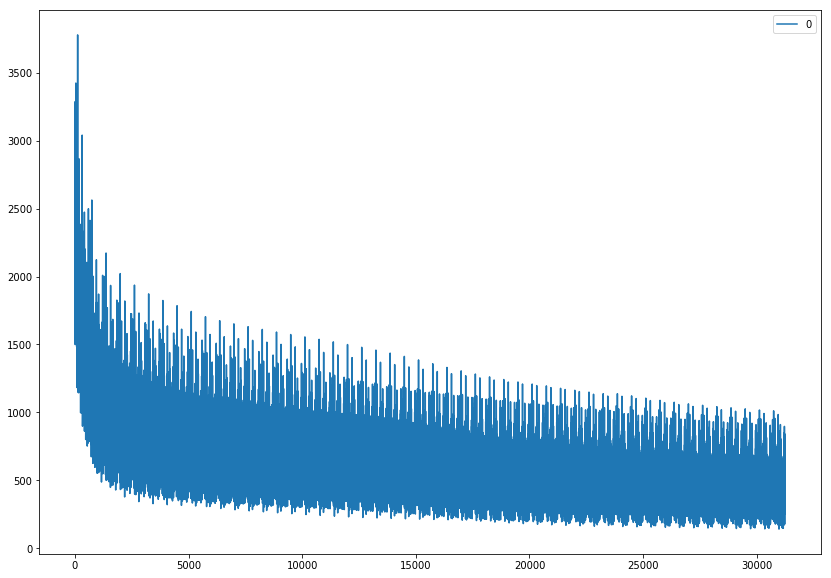

In [10]:
import pandas as pd
pd.DataFrame([c.detach().cpu().numpy() for c in collect]).plot()

In [11]:
it = iter(dl)
# model = model.eval()


/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


failed in nnms
tensor([24])


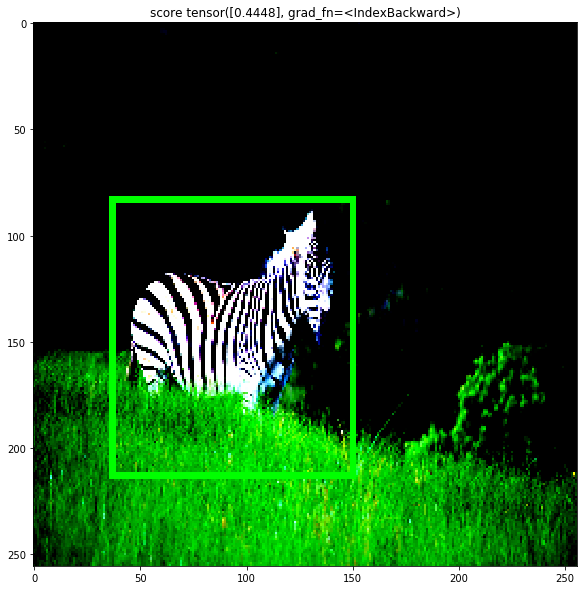

In [21]:
b = next(it)
i = 0
image, (bounding_boxes, labels) = b


loc_pred, cls_pred = model(image.cuda())

bbspred, labelpred, score  = ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))
print(labelpred)

In [8]:
mx, lab = cls_pred[0].sigmoid().max(dim=1)

In [9]:
import pandas as pd
df = pd.DataFrame(data=mx.detach().cpu().numpy())
df['lab'] = lab.detach().cpu().numpy()

In [10]:
df = df.sort_values(0, ascending=False)
df[0] = df[0] * 100
df

,0,lab
12031,35.311420,1
11588,34.022511,59
12032,33.713486,53
12025,33.456547,74
11383,33.428032,1
11384,31.917233,53
11585,31.912079,62
12029,31.866360,20
12027,31.790777,11
12028,31.151337,79


/home/i008/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:847: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/home/i008/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:849: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


In [16]:
ds.coco.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},